In [1]:
from utils import *

# to make this notebook's output stable across runs (still not fully deterministic)
SEED = 42
np.random.seed(SEED)

#
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18
#
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Define the colors for the plots
BACKGROUND_COL = '#F2F2F2'
AXIS_COLOR     = '#BEBEBE' 
LINES_COLOR    = '#BEBEBE'
sns.set_style("whitegrid", {'grid.linestyle': '--',
                            'grid.color': LINES_COLOR,
                            'axes.edgecolor': AXIS_COLOR,
                            'axes.facecolor':BACKGROUND_COL,
                            'figure.facecolor':BACKGROUND_COL,
                            })
plt.rcParams['axes.facecolor'] = BACKGROUND_COL

%matplotlib inline
%config InlineBackend.figure_format='retina' 

#articles link
#https://link.springer.com/article/10.1007/s00405-023-08299-w#Sec2 #dataset paper
#https://www.mdpi.com/2079-9292/10/16/1973 #greed search



https://link.springer.com/article/10.1007/s00405-023-08299-w#Sec2 #dataset paper
- UCI data n=383
- feature selection
- high scores
- hp tuning?

https://www.mdpi.com/2673-9585/4/4/29
- UCI data n=383
- SMOTE over-smpling
- HP tuning on test set?
- Very high scores 


https://arxiv.org/abs/2410.10907
- UCI data n=383
- DeepNN
- 80-20
- high scores
- LIME and Morris XAI
- no HP tuning

https://bmccancer.biomedcentral.com/articles/10.1186/s12885-024-12146-4
- china datset ~2000
- low scores
- different features
  

https://www.nature.com/articles/s41598-021-84504-2#Sec2
- other data ~1000
- low scores
- no HP tuning



https://www.mdpi.com/2079-9292/10/16/1973 #greed search



https://medium.com/@emilykmarsh/xgboost-feature-importance-233ee27c33a4 Why SHAP on XGBoost?


https://www.sciencedirect.com/science/article/abs/pii/S0957417421006540 Why nested Cv is overzealus

## Exploratory Data Analysis

### Data downloading

In [2]:
#! mkdir -p data
#! wget "https://archive.ics.uci.edu/static/public/915/differentiated+thyroid+cancer+recurrence.zip"
#! unzip *.zip -d ./data
#! rm -f *.zip

In [3]:
DATA = pd.read_csv('./data/Thyroid_Diff.csv')
# check nan in dataframe
assert DATA.isna().sum().sum() == 0
DATA.columns

Index(['Age', 'Gender', 'Smoking', 'Hx Smoking', 'Hx Radiothreapy',
       'Thyroid Function', 'Physical Examination', 'Adenopathy', 'Pathology',
       'Focality', 'Risk', 'T', 'N', 'M', 'Stage', 'Response', 'Recurred'],
      dtype='object')

### Order categories (Ordinal features)

In [4]:
# Define a dictionary of column names and their corresponding custom orders
custom_orders = {
    'Stage': ['I', 'II', 'III', 'IVA', 'IVB'],
    'N': ['N0', 'N1a', 'N1b'],
    'T': ['T1a', 'T1b', 'T2', 'T3a', 'T3b', 'T4a', 'T4b'],
    'Risk': ['Low', 'Intermediate', 'High'],
    'Recurred': ['Yes', 'No']
}

# Apply the custom orders using a for loop
for col, order in custom_orders.items():
    DATA[col] = pd.Categorical(DATA[col], categories=order, ordered=True)
    print(f"{col} dtype: {DATA[col].unique()}")


Stage dtype: ['I', 'II', 'IVB', 'III', 'IVA']
Categories (5, object): ['I' < 'II' < 'III' < 'IVA' < 'IVB']
N dtype: ['N0', 'N1b', 'N1a']
Categories (3, object): ['N0' < 'N1a' < 'N1b']
T dtype: ['T1a', 'T1b', 'T2', 'T3a', 'T3b', 'T4a', 'T4b']
Categories (7, object): ['T1a' < 'T1b' < 'T2' < 'T3a' < 'T3b' < 'T4a' < 'T4b']
Risk dtype: ['Low', 'Intermediate', 'High']
Categories (3, object): ['Low' < 'Intermediate' < 'High']
Recurred dtype: ['No', 'Yes']
Categories (2, object): ['Yes' < 'No']


### Plot Features Distributions


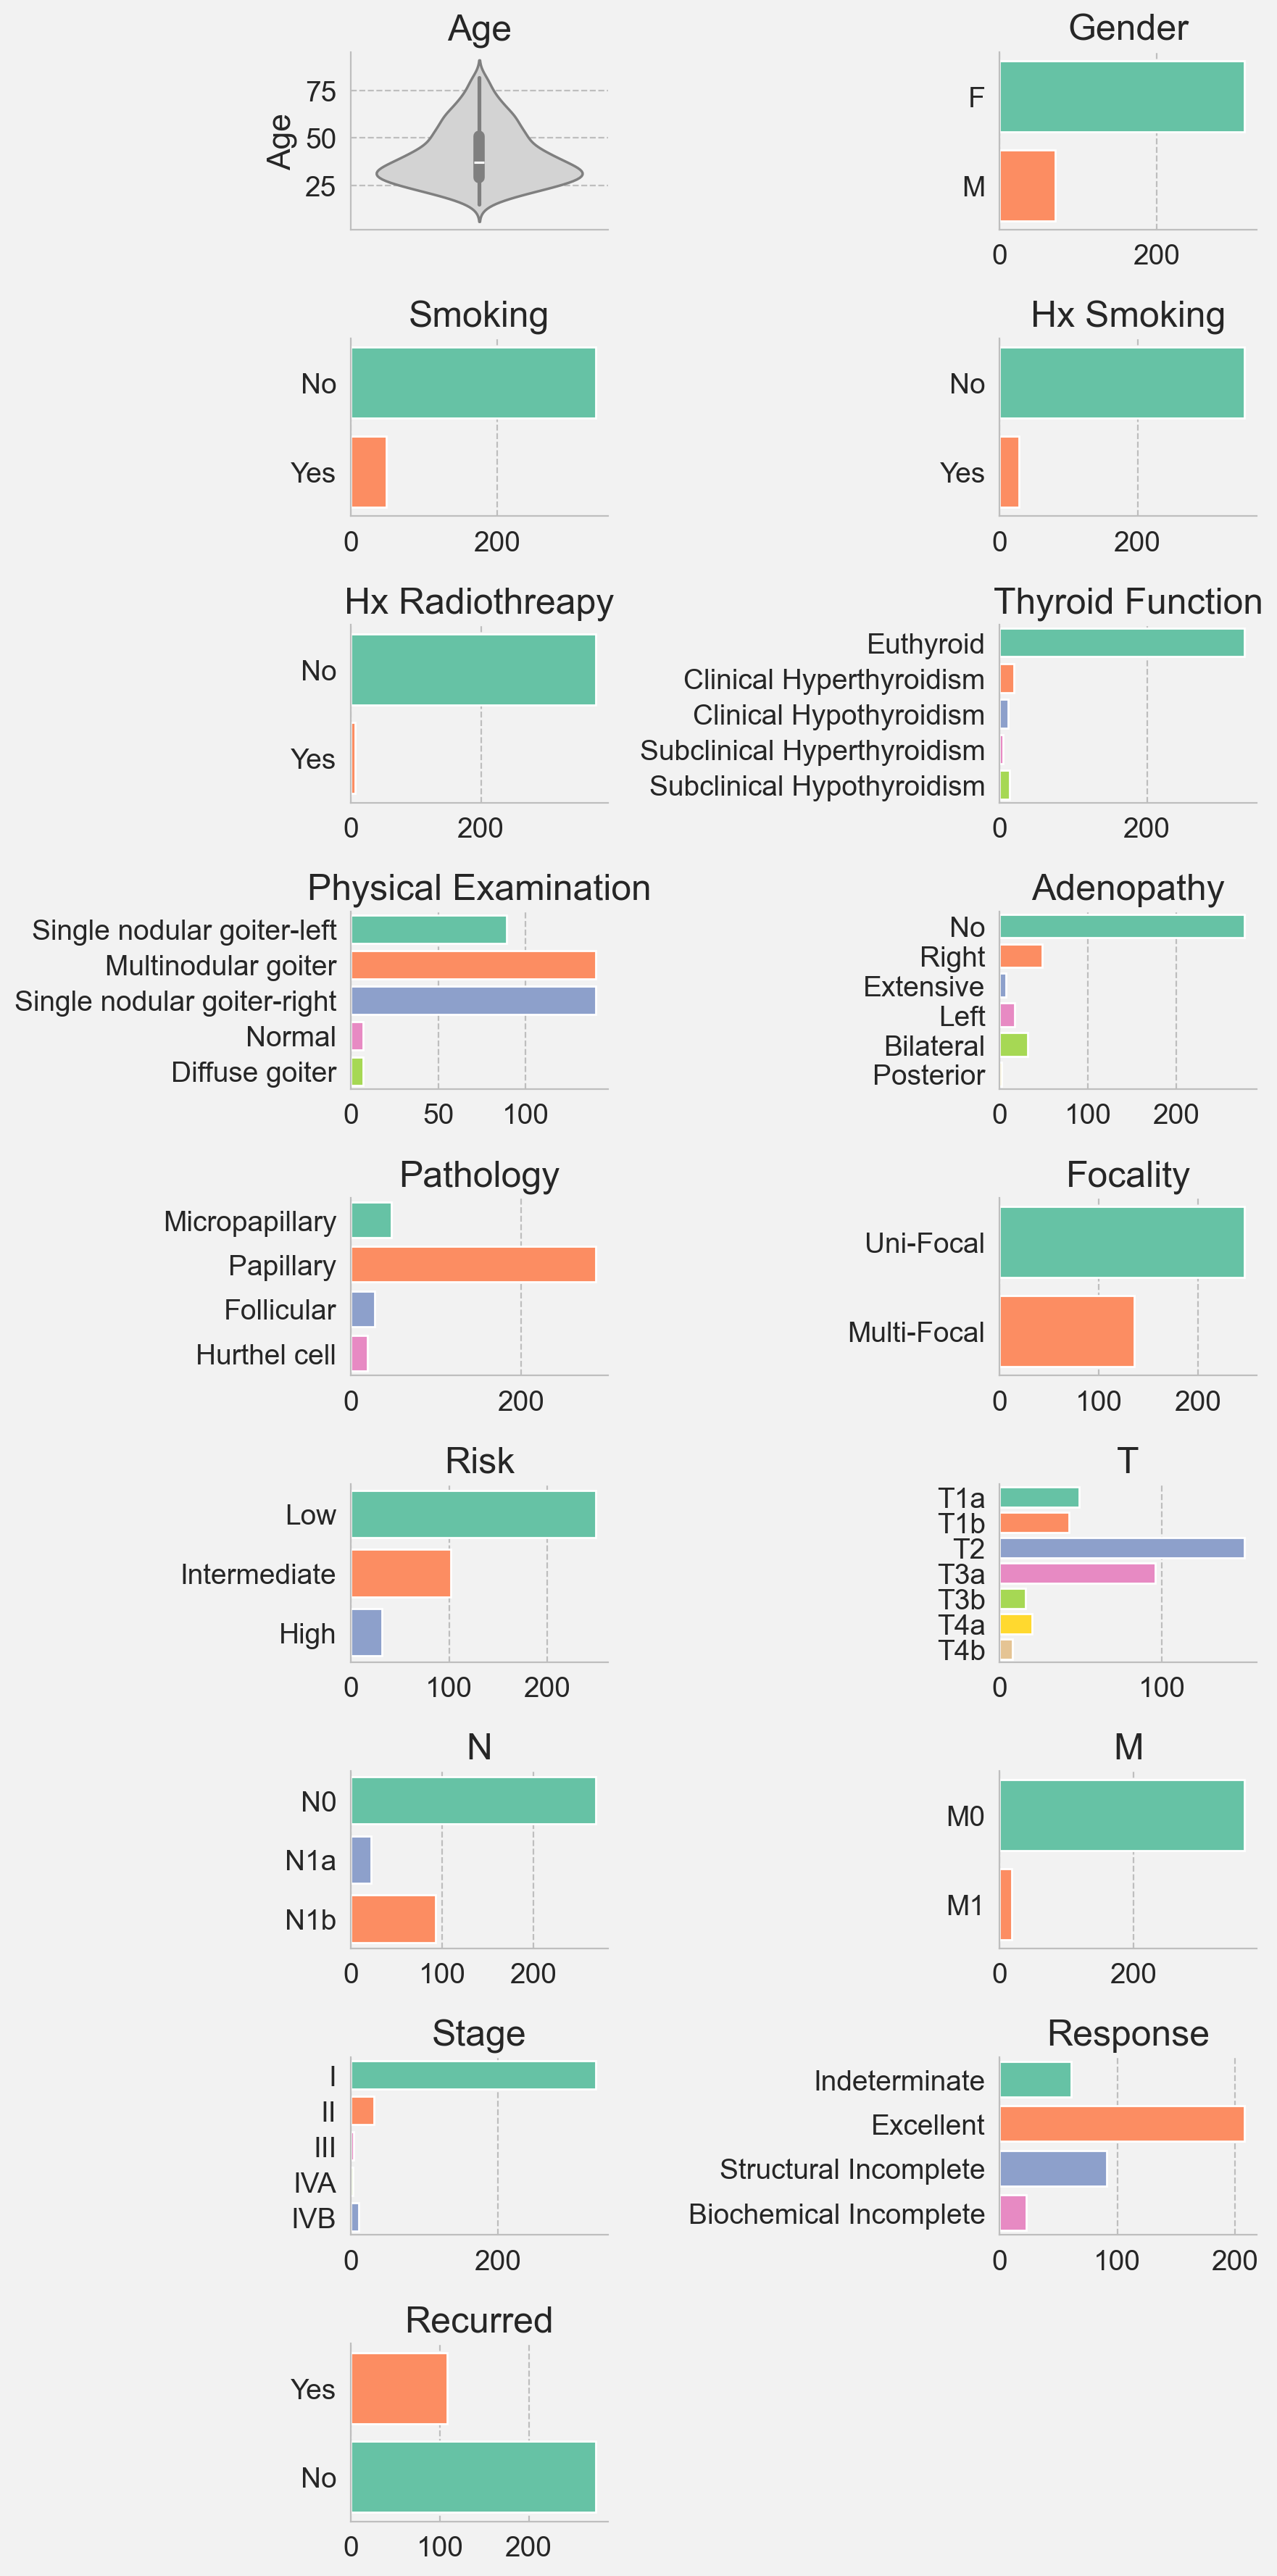

In [5]:
plot_distribution(DATA)

### Plot Feature Distributions stratified per classes (Recurred / Not Recurred)

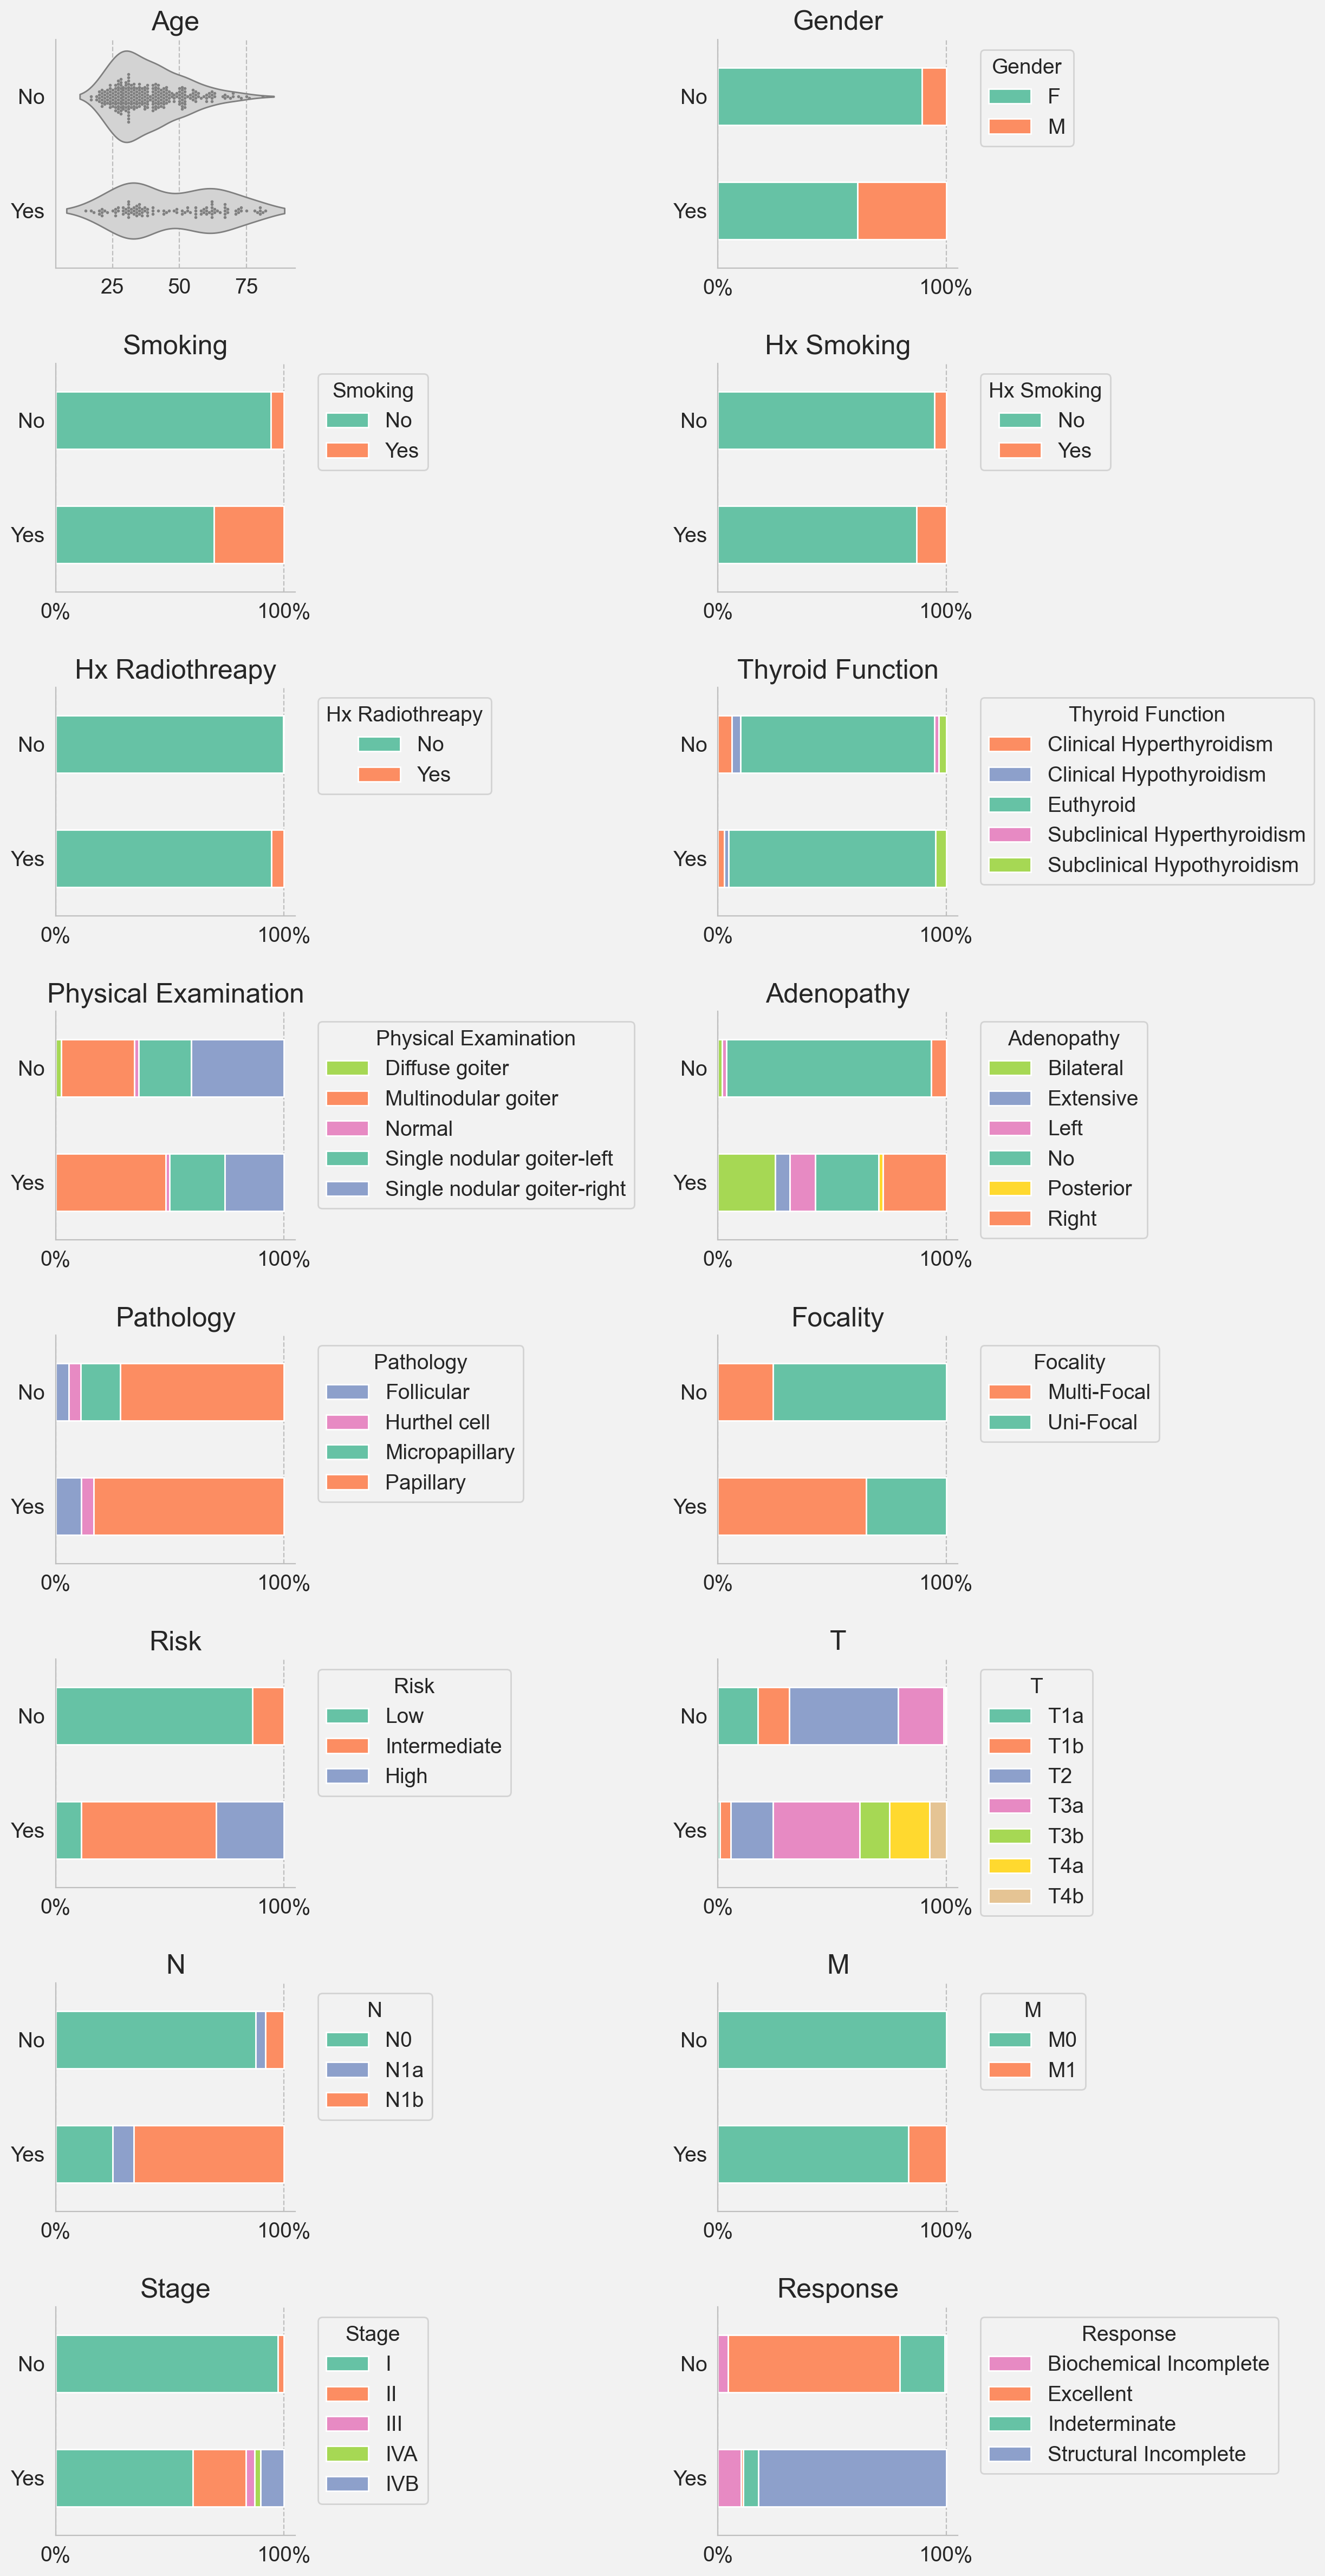

In [6]:
stratified_plots(DATA, stratify_col="Recurred")

### Feature Encoding

In [7]:


ORD_FEATURES = ['Stage','N','T','Risk']
CAT_FEATURES  = ['Thyroid Function', 'Physical Examination', 'Adenopathy', 'Pathology','Response',
                    'Gender', 'Smoking', 'Hx Smoking', 'Hx Radiothreapy','M', 'Focality']
NUM_FEATURES = ['Age']

y = LabelEncoder().fit_transform( DATA["Recurred"])

In [8]:
X = DATA.drop(columns=["Recurred"])
# Combine into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', NUM_FEATURES),  # skip
        ('ord', OrdinalEncoder(categories=[custom_orders[feature] for feature in ORD_FEATURES]), ORD_FEATURES),   # Apply OrdinalEncoder with custom order
        ('cat', OneHotEncoder(), CAT_FEATURES) # Apply OneHotEncoder to categorical features
    ]
)

# Fit and transform the data
X = preprocessor.fit_transform(X)

X_df = pd.DataFrame(
    X,
    columns=(
        NUM_FEATURES + ORD_FEATURES + 
        list(preprocessor.named_transformers_['cat'].get_feature_names_out(CAT_FEATURES))
    )
)


## Nested Cross-Validation (nCV) 

### Models hyperparameters space

In [9]:
CV_Grids = {}
#--------------------------------------------------MLP-------------------------------------------------
NUM_FEATURES = X.shape[1]
SCALING_FACTORS = [ 0.5, 0.75, 1]
N_HIDDEN_LAYERS = [1, 2, 3, 4, 5]
h_layers_sizes = []

for scaling_factor in SCALING_FACTORS:
    for num_layers in N_HIDDEN_LAYERS:
        hidden_layer_size = []
        for i in range(num_layers):
            tmp = max(int(NUM_FEATURES * scaling_factor ** (i )), 1)
            hidden_layer_size.append(tmp)
        h_layers_sizes.append(hidden_layer_size)

CV_Grids['MLP'] = {
    'model': MLPClassifier(random_state=SEED, 
                    solver='adam', max_iter=300 ,early_stopping=True, learning_rate_init=0.05 ),
    'param_grid': {
        "hidden_layer_sizes": h_layers_sizes,  # List of integers from 10 to 1000, step 50
        "activation": [ "logistic",  "relu", "tanh"],
        "batch_size": [4,8,16,32,64],
        "alpha": loguniform(1e-5,1),
    }
}

#---------------------------------------------------SVC-----------------------------------------------------
CV_Grids['SVC'] = {'model':SVC(class_weight='balanced',random_state=SEED,probability=True),
                'param_grid':{
                            "C": loguniform(1e-3, 1000),
                            "kernel": ["rbf", "linear", "sigmoid"],
                            "gamma": loguniform(1e-9, 1000),
}}

##--------------------------------------------------RandomForest-------------------------------------------------
CV_Grids['RF'] = {
    'model': RandomForestClassifier(class_weight='balanced', random_state=SEED, bootstrap=True),
    'param_grid': {
        "n_estimators": [20,50,100,200,400],  
        #"max_depth": np.arange(5, 30, step=5),         # List of integers from 5 to 50, step 5
        "min_samples_split": np.arange(2, 20, step=1), # List of integers from 2 to 20, step 2
        #"min_samples_leaf": np.arange(1, 20, step=1),  # List of integers from 1 to 20, step 2
        "criterion": ["gini", "entropy", "log_loss"],
        "max_samples": uniform(0.1,0.9),
    }
}

#--------------------------------------------------LogisticRegression-------------------------------------------------
CV_Grids['LR'] = {
    'model': LogisticRegression(class_weight='balanced', random_state=SEED, max_iter=1000, solver="newton-cholesky"),
    'param_grid': {
        "C": loguniform(1e-4, 1e2),  # Inverse of regularization strength (log-uniform distribution)
        "penalty": ["l2", None],  # Penalty types (no 'none' due to optimization)
        "tol": loguniform(1e-7,1e-3) # l1_ratio only for 'elasticnet' penalty
    }
}

#--------------------------------------------------DT-------------------------------------------------
CV_Grids['DT'] = {
    'model': DecisionTreeClassifier(class_weight='balanced',random_state=SEED,),
    'param_grid': {
        "max_depth": np.arange(5, 30, step=5),         # List of integers from 5 to 50, step 5
        "min_samples_split": np.arange(2, 20, step=1), # List of integers from 2 to 20, step 2
        "min_samples_leaf": np.arange(1, 20, step=1),  # List of integers from 1 to 20, step 2
        "criterion": ["gini", "entropy", "log_loss"]
    }
}

#--------------------------------------------------XGBoost DT-------------------------------------------------
CV_Grids['XGBoost'] = {
    'model': XGBClassifier(random_state=SEED),
    'param_grid': {
        "n_estimators": [20,50,100,200,400],  # List of integers from 10 to 1000, step 50
        #"learning_rate": loguniform(1e-5,10),
        "max_depth": np.arange(5, 30, step=5),         # List of integers from 5 to 50, step 5
        "subsample": uniform(0.1,0.9), 
        "colsample_bytree": uniform(0.5, 0.5), 

    }
}

### Stratified 5-fold nCV (3-fold inner CV)

In [10]:
nCV_results = {}
NUM_TRIALS = 5000 # Number of random search trials per model architecture

In [6]:
#--------------------------------------------------Nested Cross Validation-------------------------------------------------

cv_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
for model_name, model_dict in CV_Grids.items():
    nCV_results[model_name] = {
        'precision': list(),
        'recall': list(),
        'f1': list(),
        'mcc': list(),
        'roc_auc': list(),
        'prc_auc': list(),
        'roc_curves': list(),
        'prc_curves': list(),
        'best_params':list()
    }
    for train_ix, test_ix in cv_outer.split(X, y):
        # split data
        X_train, X_test = X[train_ix, :], X[test_ix, :]
        y_train, y_test = y[train_ix], y[test_ix]

        # Configure the pipeline
        pipeline = Pipeline([
            ('scaler', MinMaxScaler()),  # Add MinMaxScaler as the first step
            ('classifier', model_dict['model'])  # Add the model as the second step
        ])
        
        # Update param_grid keys to match the pipeline format
        param_grid = {f'classifier__{key}': value for key, value in model_dict['param_grid'].items()}
        # configure the cross-validation procedure
        cv_inner = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)
        # define search
        search = RandomizedSearchCV(pipeline, param_grid, scoring='matthews_corrcoef', 
                                    cv=cv_inner, refit=True, random_state=SEED, n_iter=NUM_TRIALS, n_jobs=8)
        # execute search on the training data (inner 3-fold CV)
        result = search.fit(X_train, y_train)
        # get the best performing pipe and fit on the whole training set
        best_pipe = result.best_estimator_
        best_pipe.fit(X_train, y_train)
        # evaluate model on the hold out dataset
        y_pred = best_pipe.predict(X_test)
        y_pred_prob = best_pipe.predict_proba(X_test)[:, 1]  # Probability scores for ROC/PRC curves
        nCV_results[model_name]['precision'].append(precision_score(y_test, y_pred, zero_division=0))
        nCV_results[model_name]['recall'].append(recall_score(y_test, y_pred, zero_division=0))
        nCV_results[model_name]['f1'].append(f1_score(y_test, y_pred, zero_division=0))
        nCV_results[model_name]['mcc'].append(matthews_corrcoef(y_test, y_pred))
        nCV_results[model_name]['roc_auc'].append(roc_auc_score(y_test, y_pred_prob))
        nCV_results[model_name]['prc_auc'].append(average_precision_score(y_test, y_pred_prob))
        # ROC curve 
        fpr, tpr, roc_thresholds = roc_curve(y_test, y_pred_prob)
        nCV_results[model_name]['roc_curves'].append({'fpr': fpr, 'tpr': tpr, 'thresholds': roc_thresholds})
        # PRC curve 
        precision, recall, prc_thresholds = precision_recall_curve(y_test, y_pred_prob)
        nCV_results[model_name]['prc_curves'].append({'precision': precision, 'recall': recall, 'thresholds': prc_thresholds})
        # save best params
        nCV_results[model_name]['best_params'].append(result.best_params_)
    # Calculate the mean and standard deviation of the metrics (among the 5 outer folds)
    metrics = ['precision', 'recall', 'f1', 'mcc', 'roc_auc', 'prc_auc']
    for metric in metrics:
        nCV_results[model_name][f'mean_{metric}'] = np.mean(nCV_results[model_name][f'{metric}'])
        nCV_results[model_name][f'std_{metric}'] = np.std(nCV_results[model_name][f'{metric}'])

    print(f"{model_name}: MCC={nCV_results[model_name]['mean_mcc']} +- {nCV_results[model_name]['std_mcc']}, "
        f"ROC_AUC={nCV_results[model_name]['mean_roc_auc']} +- {nCV_results[model_name]['std_roc_auc']}, "
        f"PRC_AUC={nCV_results[model_name]['mean_prc_auc']} +- {nCV_results[model_name]['std_prc_auc']}")


NameError: name 'CV_Grids' is not defined

#### Save or Import existing nCV_results 

In [11]:
# Avoid recomputing the results if the file already exists
import_existing = True # Set to True to import if file exists, False to overwrite 
nCV_results = save_or_import_object(nCV_results, "./results/nCV_Results.pkl", import_existing)


Imported results from './results/nCV_Results.pkl'.


### Compare models metrics on testing 

In [12]:
# barplot with models on x and mc on y
# Create a DataFrame from the Testing_Results dictionary
Testing_scores = pd.DataFrame(nCV_results).T
Testing_scores.reset_index(inplace=True, names='Model')
# Specify the numeric columns to round
numeric_columns = ['mean_mcc', 'std_mcc', 'mean_recall', 'std_recall', 'mean_precision', 'std_precision']
Testing_scores[numeric_columns] = Testing_scores[numeric_columns].apply(pd.to_numeric, errors='coerce').round(2)
Testing_scores[['Model'] + numeric_columns]


Model  mean_mcc  std_mcc  mean_recall  std_recall  mean_precision  \
0      MLP      0.85     0.06         0.86        0.08            0.92   
1      SVC      0.91     0.04         0.91        0.05            0.96   
2       RF      0.89     0.06         0.89        0.09            0.96   
3       LR      0.83     0.04         0.91        0.05            0.85   
4       DT      0.86     0.05         0.93        0.05            0.88   
5  XGBoost      0.90     0.06         0.91        0.08            0.94   

   std_precision  
0           0.04  
1           0.03  
2           0.05  
3           0.01  
4           0.07  
5           0.04

#### MCC, ROC AUC and PRC AUC

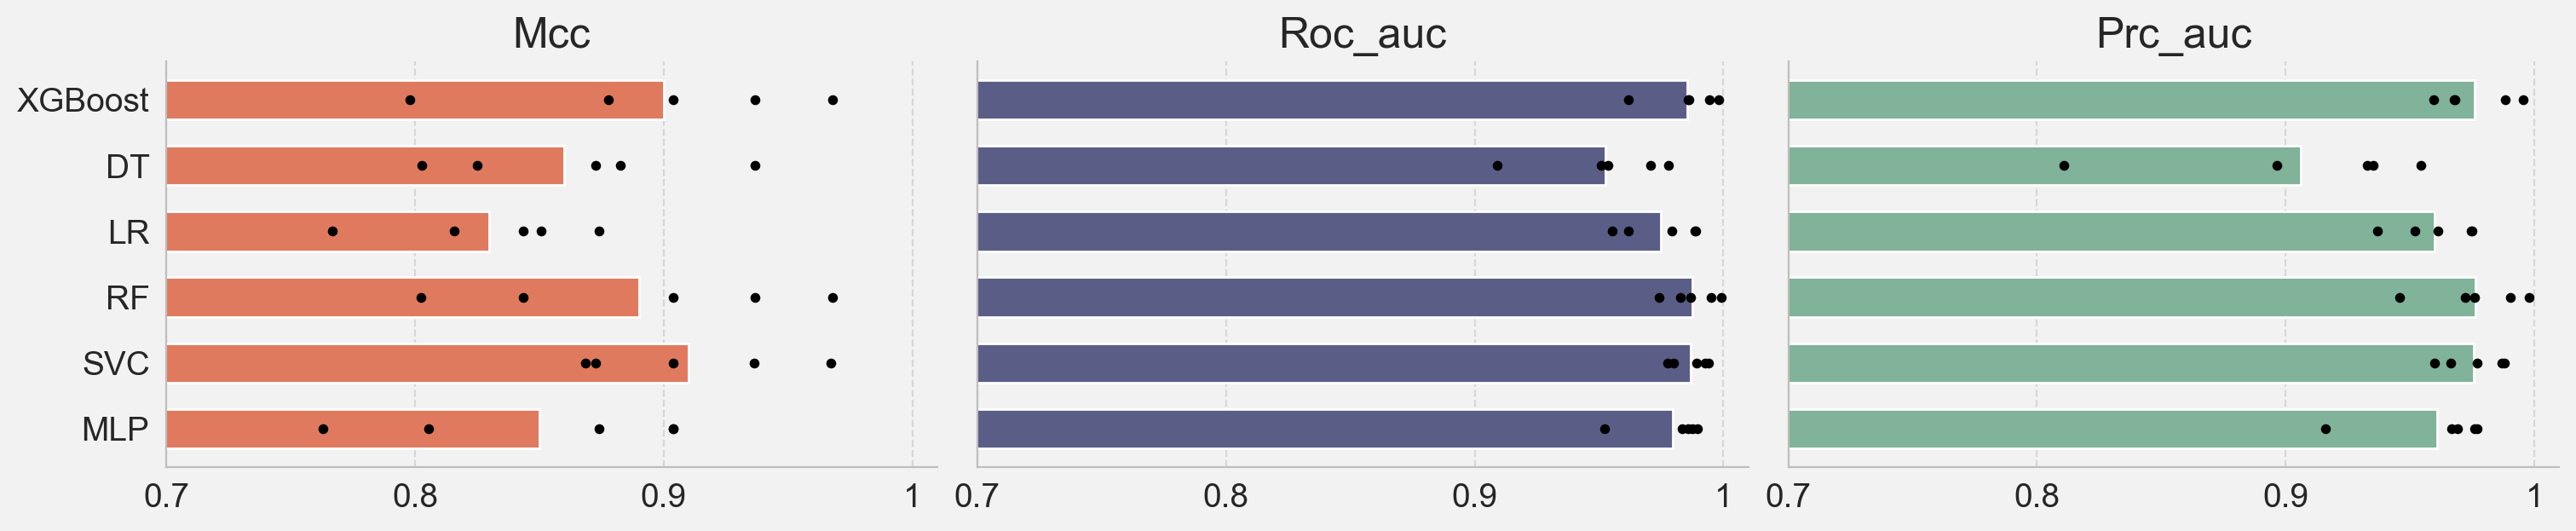

In [13]:
# Call the function to plot the grid
grid_barplot_scores(data=Testing_scores,  metrics=['mcc', 'roc_auc', 'prc_auc'], 
                    color_dict={'mcc': '#e07a5f','roc_auc': '#5A5E87','prc_auc': '#81b29a'}, n_cols=3)

#### ROC and PRC curves

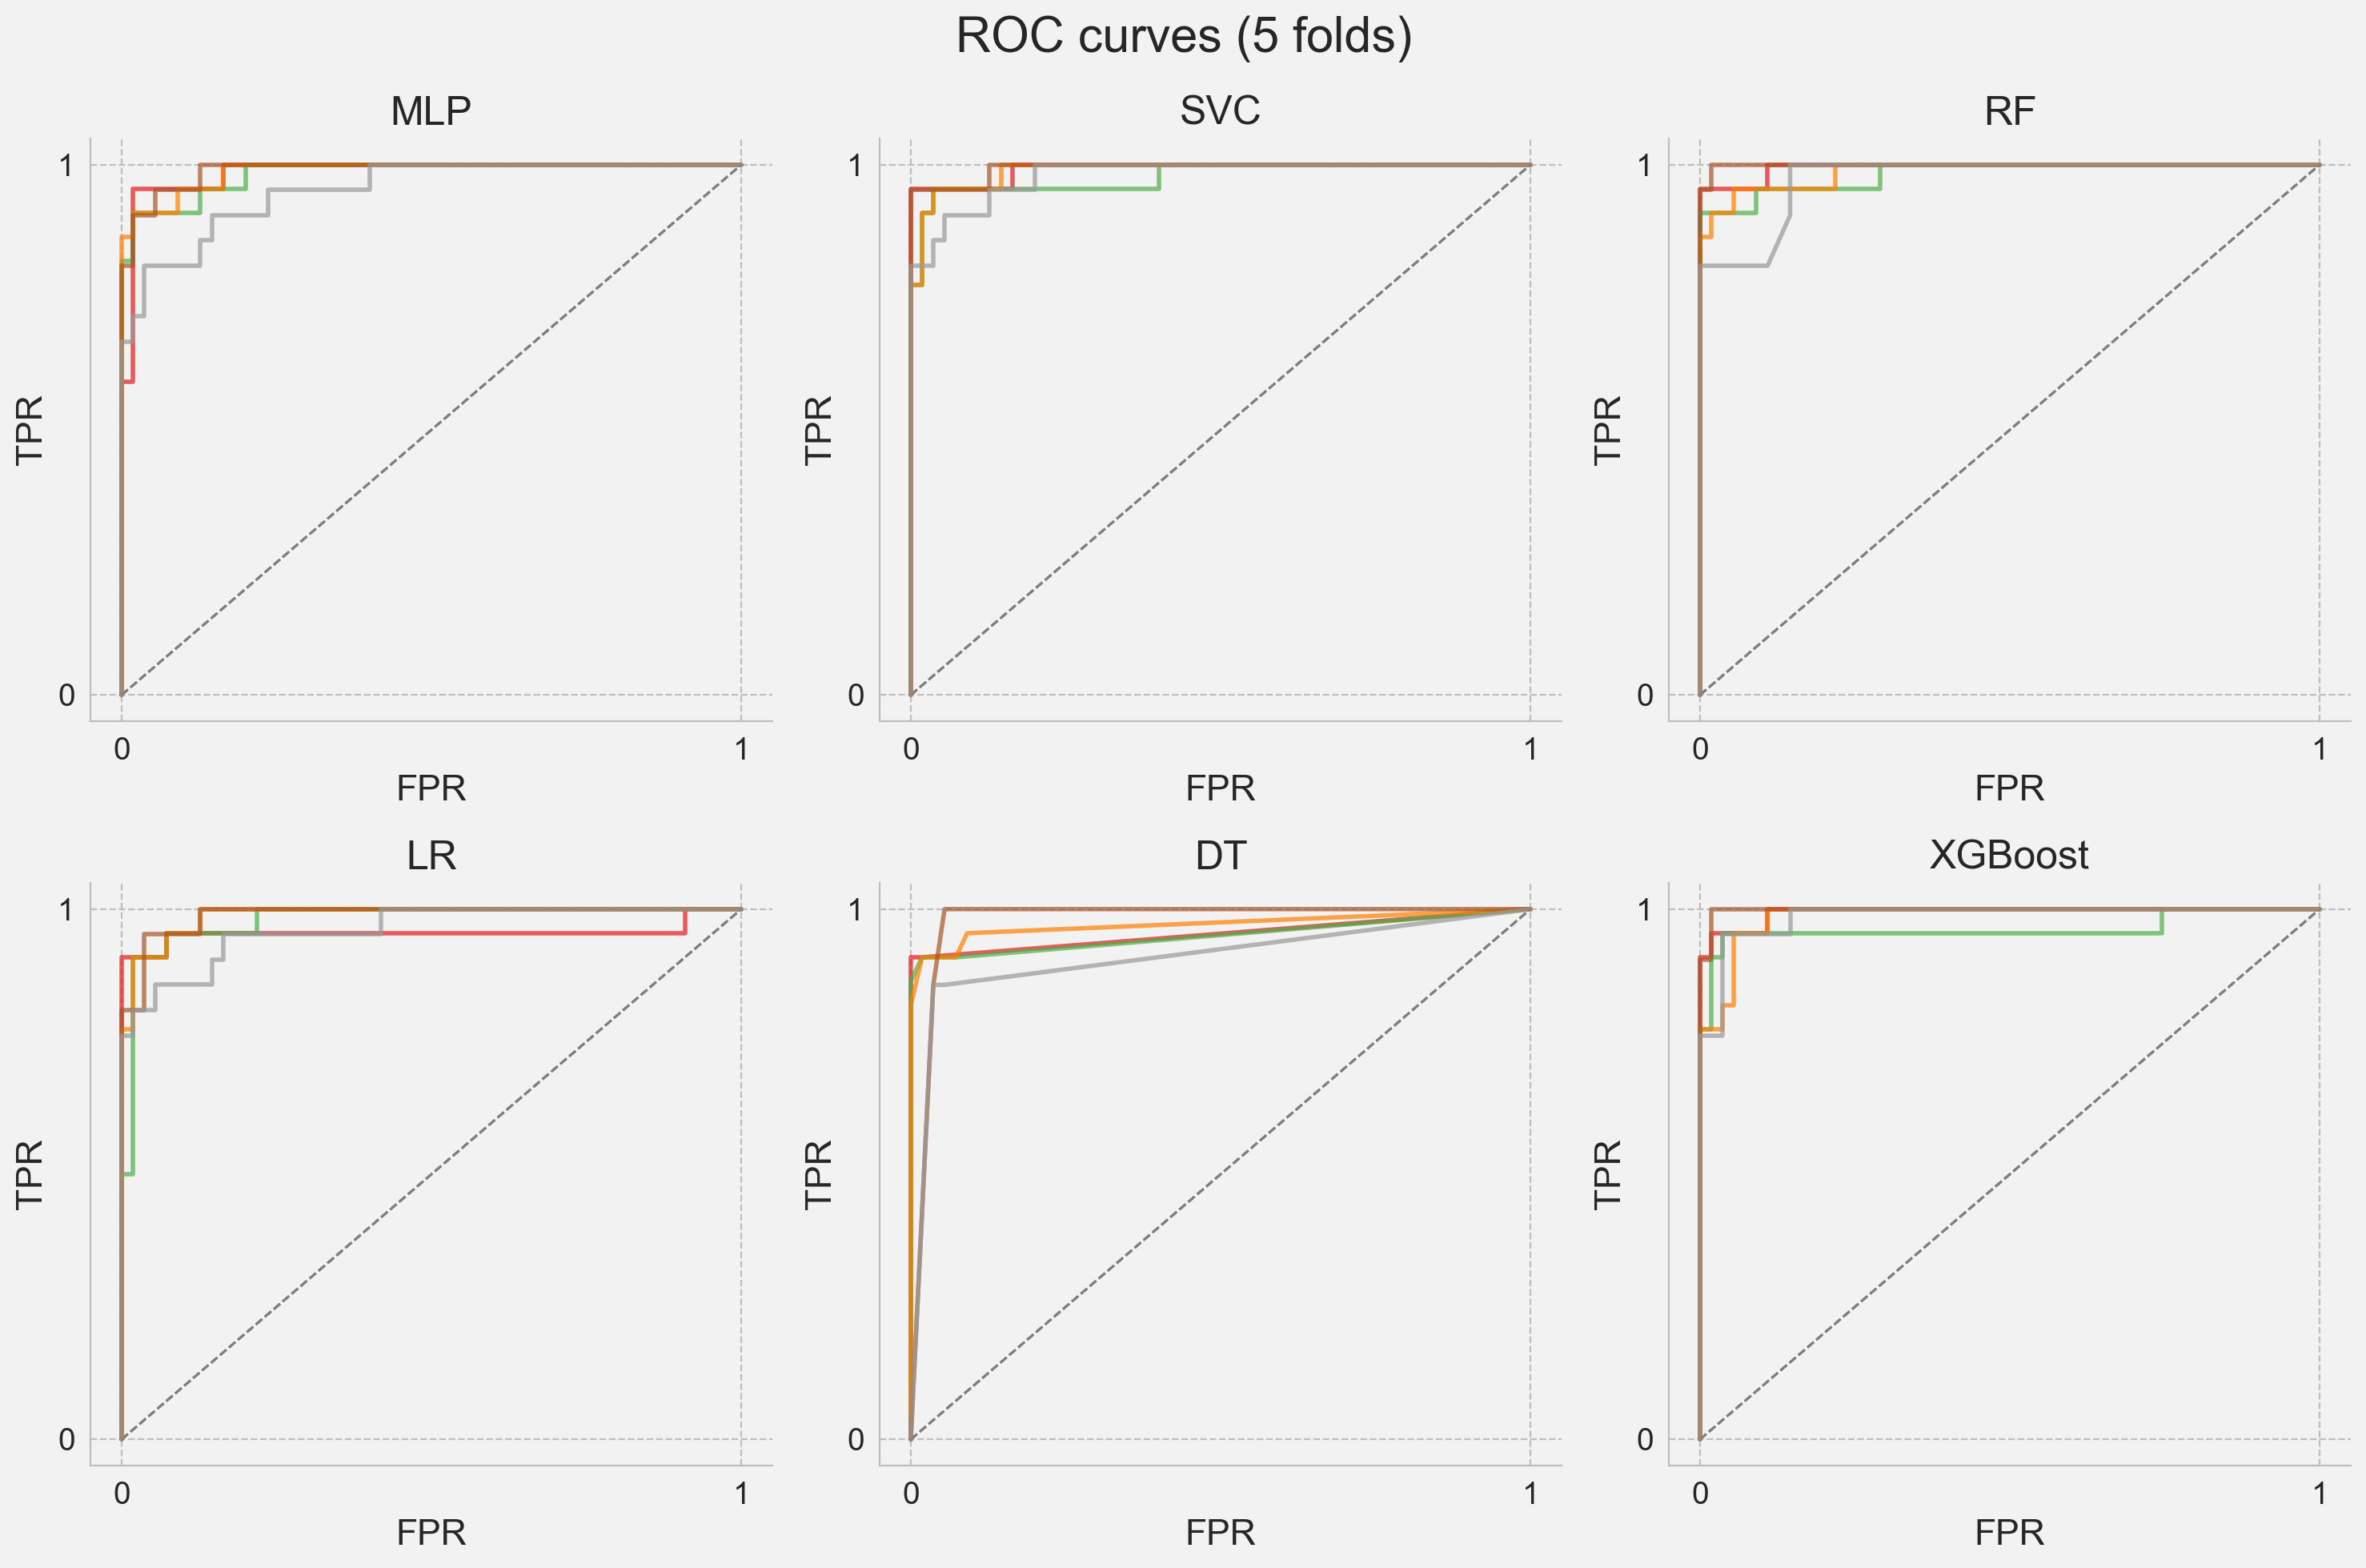

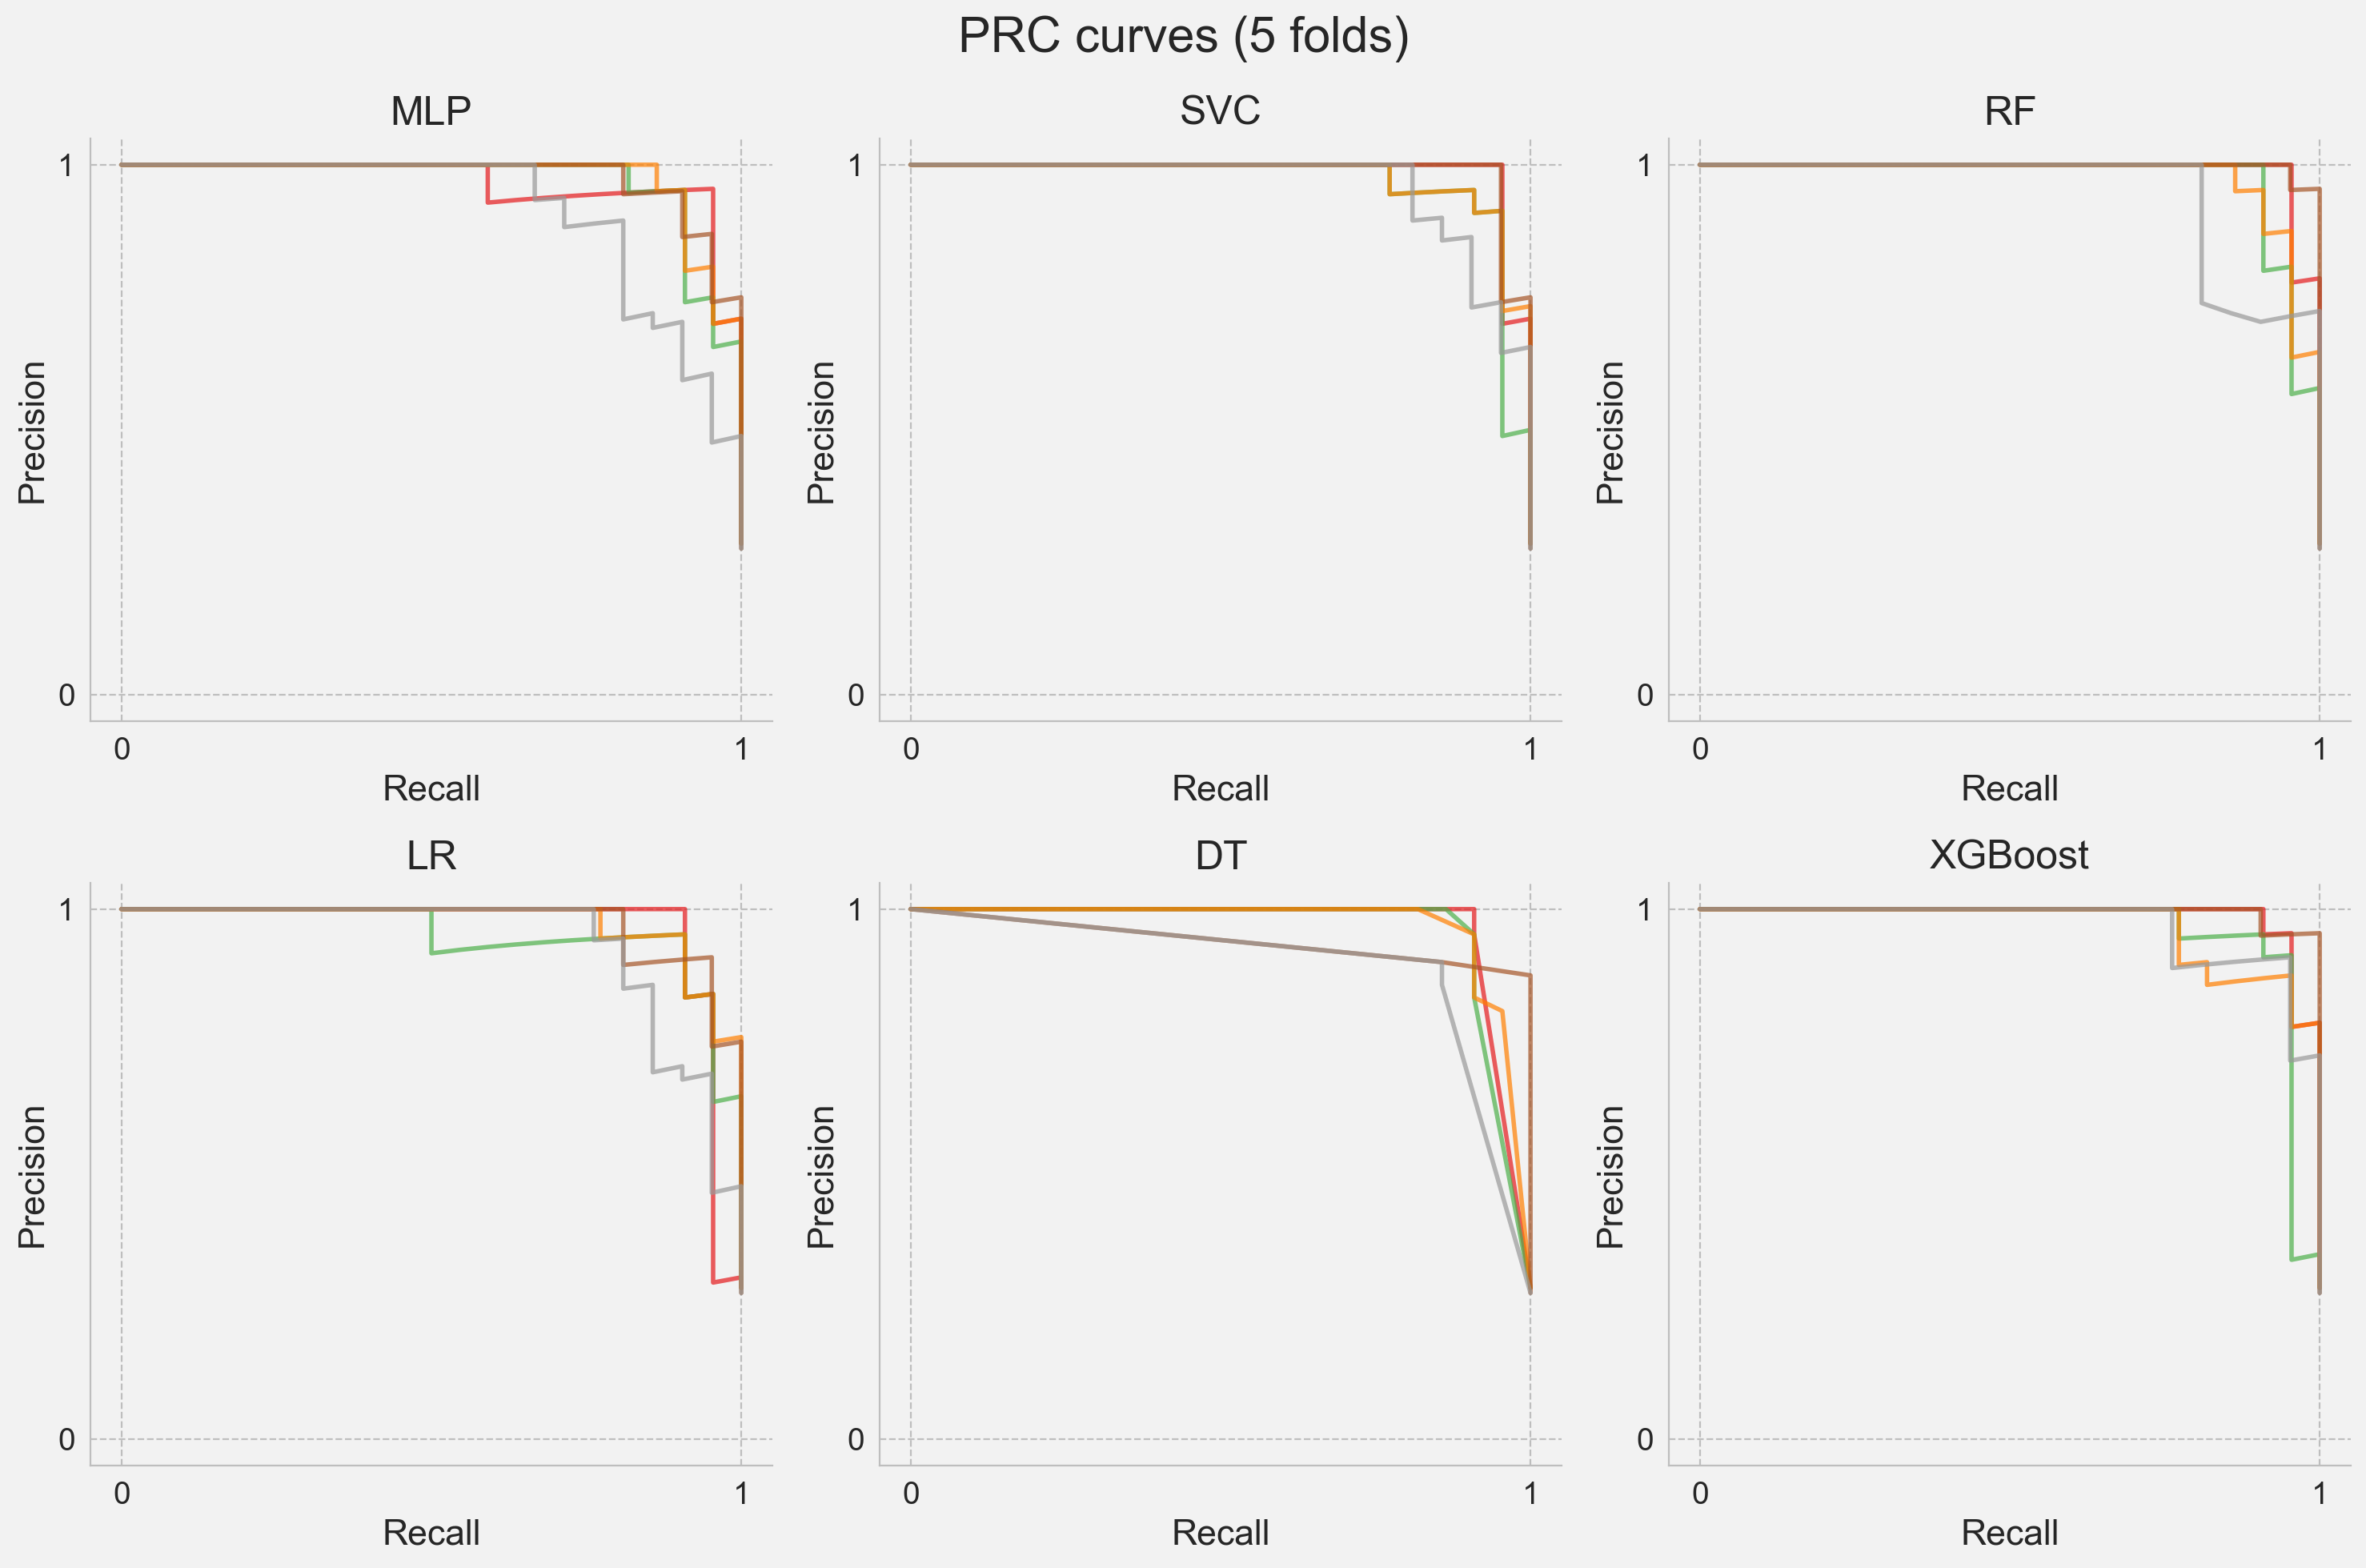

In [14]:
plot_curves_by_fold(Testing_scores, curve_type='roc')
plot_curves_by_fold(Testing_scores, curve_type='prc')

## SHAP analysis on SVM (in outer CV)

In [15]:
# Get the best model hyperparameters for each fold
best_params = Testing_scores[Testing_scores['Model'] == 'SVC']['best_params'].to_list()[0]
best_params

[{'classifier__C': 0.3743902999434125,
  'classifier__gamma': 0.06716887451894517,
  'classifier__kernel': 'rbf'},
 {'classifier__C': 2.8925921806372963,
  'classifier__gamma': 0.005848369466662318,
  'classifier__kernel': 'rbf'},
 {'classifier__C': 0.49279403578907954,
  'classifier__gamma': 0.10781639774391664,
  'classifier__kernel': 'rbf'},
 {'classifier__C': 0.03987365855896373,
  'classifier__gamma': 524.0581386545831,
  'classifier__kernel': 'linear'},
 {'classifier__C': 0.027376085211918644,
  'classifier__gamma': 5.4794688843475655e-08,
  'classifier__kernel': 'linear'}]

In [16]:
# Initialize containers for combined SHAP objects
combined_shap_values = None
# Initialize list to store misclassified indices 
misclassified_ix = []

### SHAP on testing data (loop in the outer CV)



In [74]:

cv_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
fold_ix = 0
base_index = 0 # updated as base index at each fold 
for train_ix, test_ix in cv_outer.split(X, y):
        X_train, X_test = X[train_ix, :], X[test_ix, :]
        y_train, y_test = y[train_ix], y[test_ix]
        #
        model = SVC(class_weight='balanced',random_state=SEED,probability=True)
        pipeline = Pipeline([
            ('scaler', MinMaxScaler()),  
            ('classifier', model)  
        ])
        pipeline.set_params(**best_params[fold_ix]) 

        # Fit the scaler on the training data and transform both the training and testing data
        X_train = pipeline.named_steps['scaler'].fit_transform(X_train)
        X_test = pipeline.named_steps['scaler'].transform(X_test)
        # Fit the model on the training data and predict the testing data
        model = pipeline.named_steps['classifier']
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        # Loop predictions to find misclassified samples
        for i, (true_label, predicted_label) in enumerate(zip(y_test, y_pred)):
            if true_label != predicted_label:
                global_index = i + base_index
                misclassification_type = "FN" if true_label == 1 and predicted_label == 0 else "FP"
                misclassified_ix.append((global_index, misclassification_type))
        base_index += len(y_test)
        
        #------------------------------------------------SHAP-------------------------------------------------
        explainer = shap.KernelExplainer(model.predict, X_train,feature_names=X_df.columns)
        # Calculate SHAP values for the testing data
        shap_values = explainer(X_test)
        
        # Loop through one-hot encoded features and for each combine SHAP values and data 
        # (Dummies -> Originals)
        for FEATURE in CAT_FEATURES:
            mask = [item.startswith(FEATURE + "_") for item in shap_values.feature_names]
            #mask_col_names = np.array(shap_values.feature_names, dtype='object')[mask]
            shap_values = combine_one_hot(shap_values, FEATURE, mask)
        
        # Combine SHAP values across folds
        if combined_shap_values is None:
            combined_shap_values = shap_values  # Initialize with the first fold's SHAP values
        else:
            combined_shap_values = concatenate_shap_objects(combined_shap_values, shap_values)
        
        fold_ix += 1


Using 306 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/77 [00:00<?, ?it/s]

Using 306 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/77 [00:00<?, ?it/s]

Using 306 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/77 [00:00<?, ?it/s]

Using 307 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/76 [00:00<?, ?it/s]

Using 307 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/76 [00:00<?, ?it/s]

### Save or Import existing results

In [17]:
import_existing = True

combined_shap_values = save_or_import_object(combined_shap_values, './results/SHAP.pkl', import_existing)
misclassified_ix = save_or_import_object(misclassified_ix, './results/misclassified_ix.pkl', import_existing)

Imported results from './results/SHAP.pkl'.
Imported results from './results/misclassified_ix.pkl'.


### SHAP Visualization

#### mean |SHAP| per feature

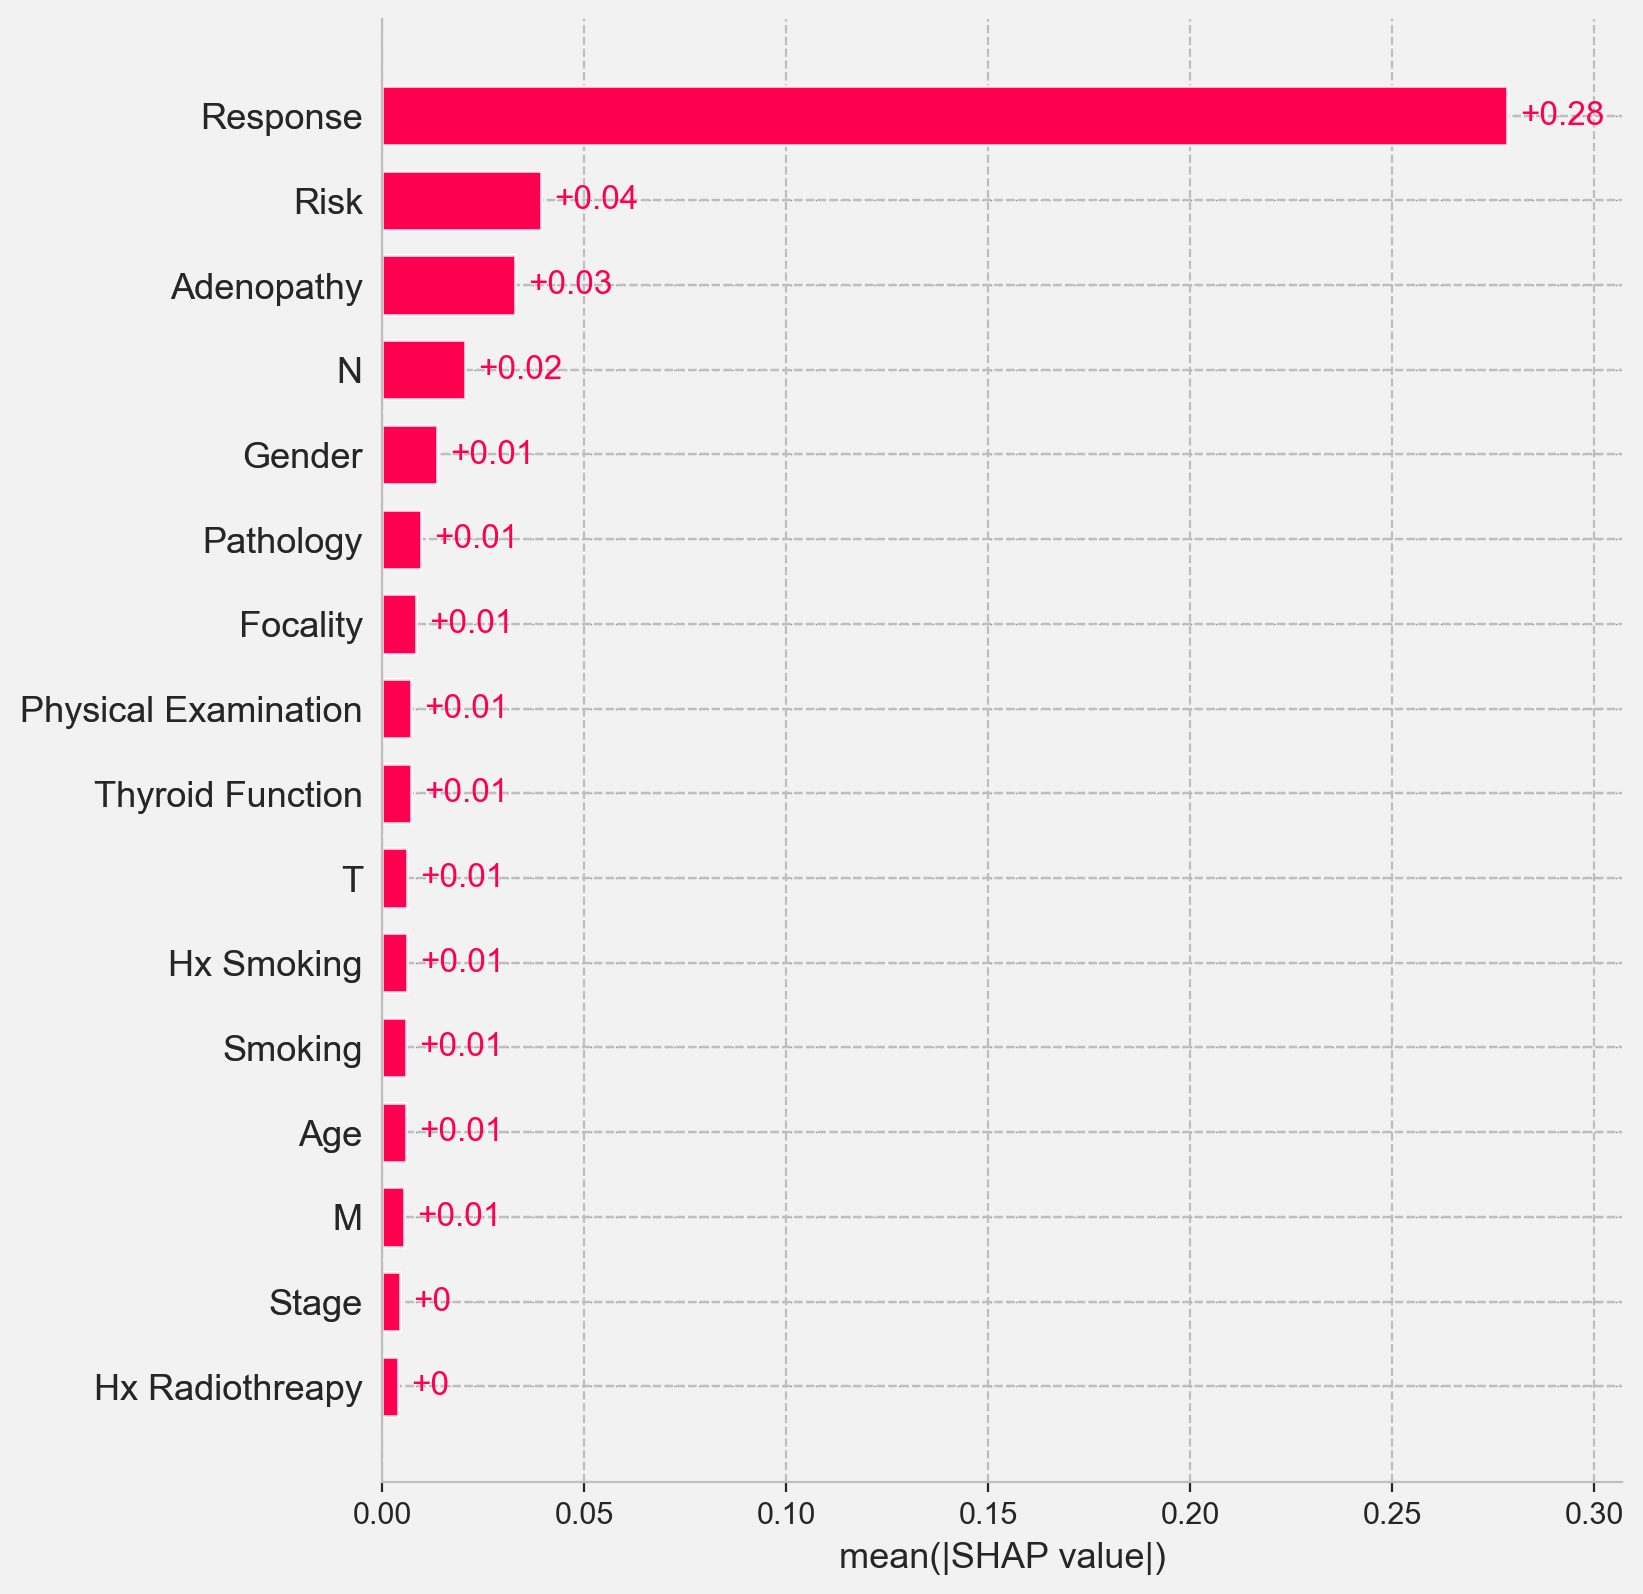

In [18]:
shap.plots.bar(combined_shap_values, max_display=20)

#### SHAP values per features (sample-wise)

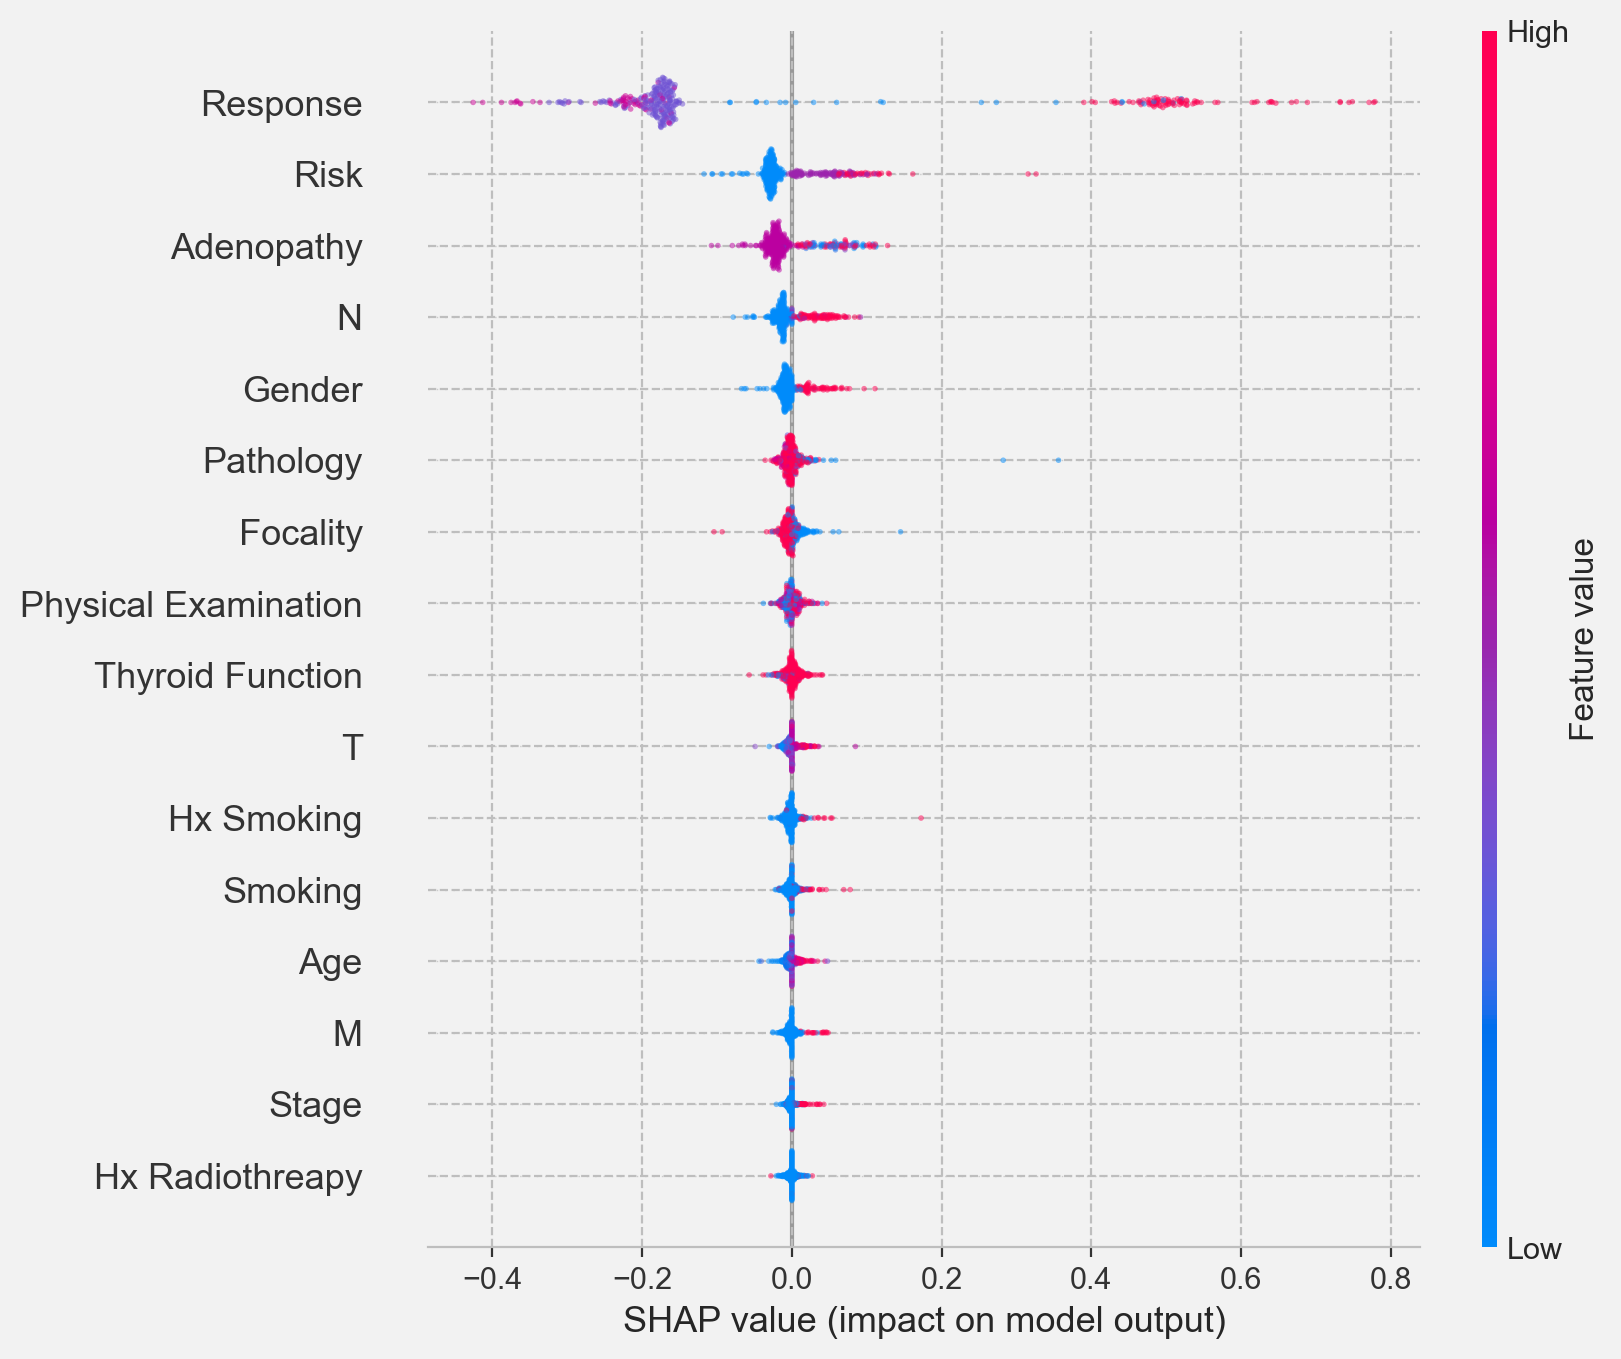

In [19]:
shap.plots.beeswarm(combined_shap_values, max_display=20, alpha=0.5, s=4)

#### Feature values effect on prediction (sorted by average feature importance)


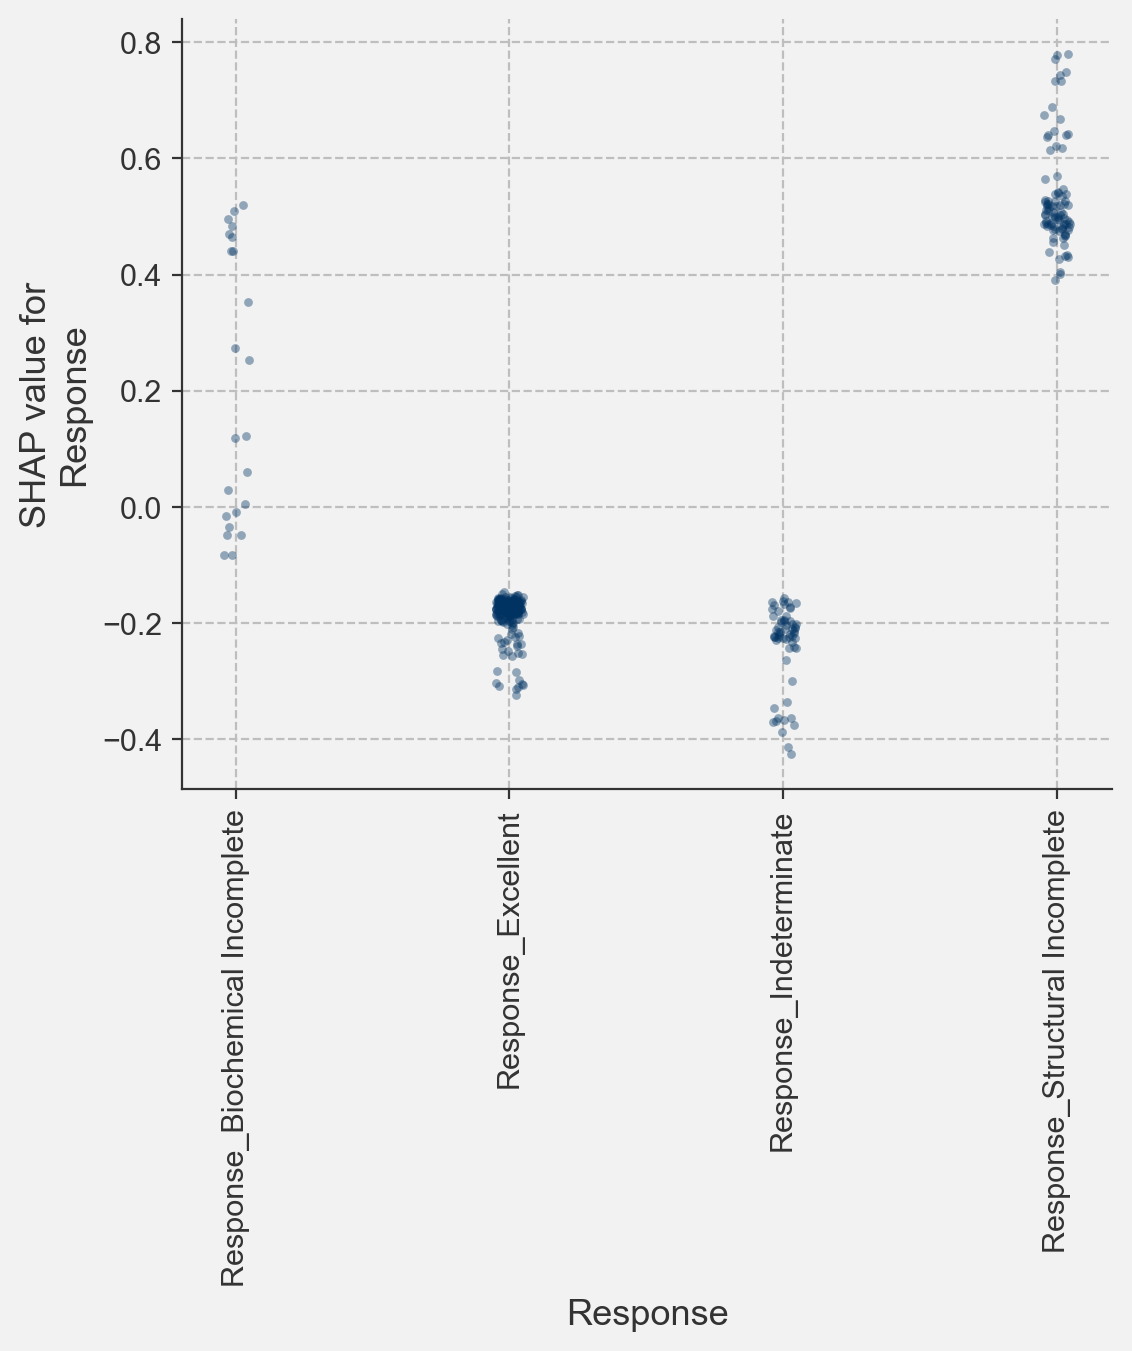

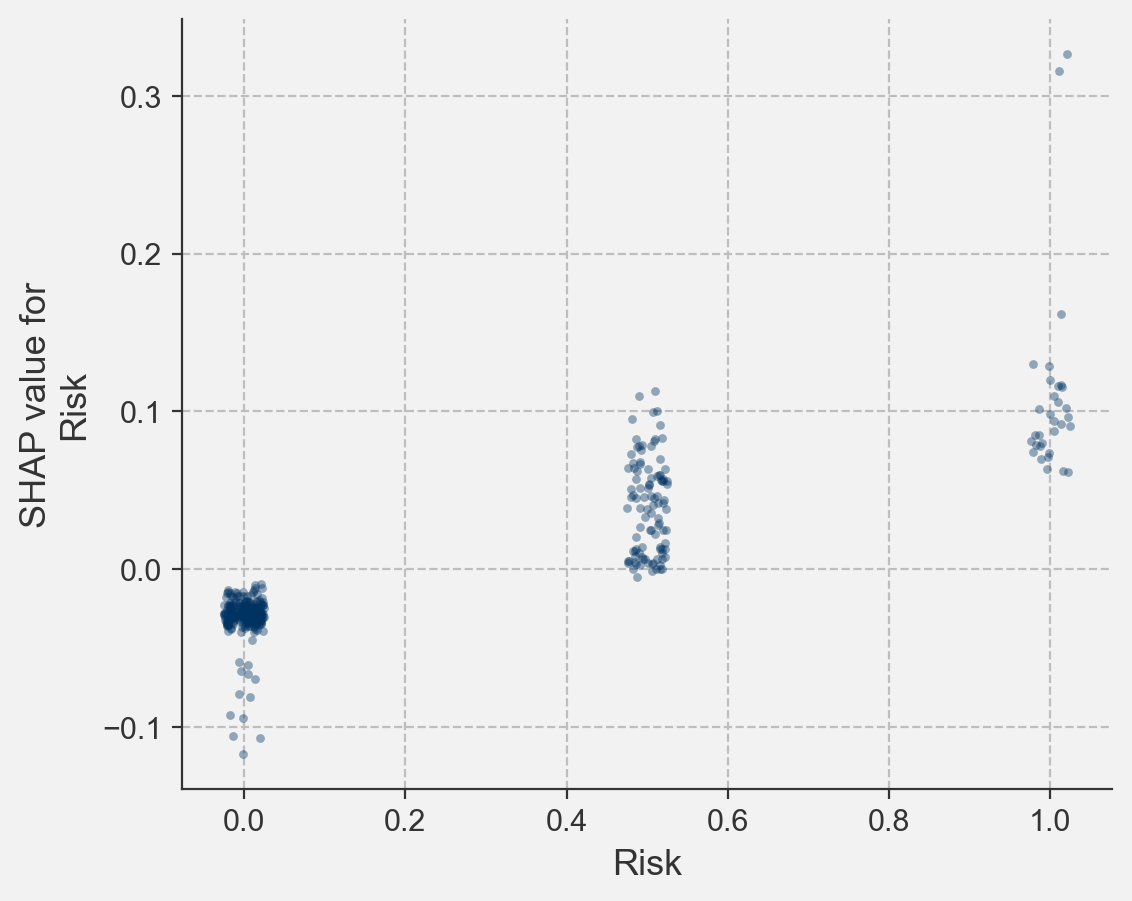

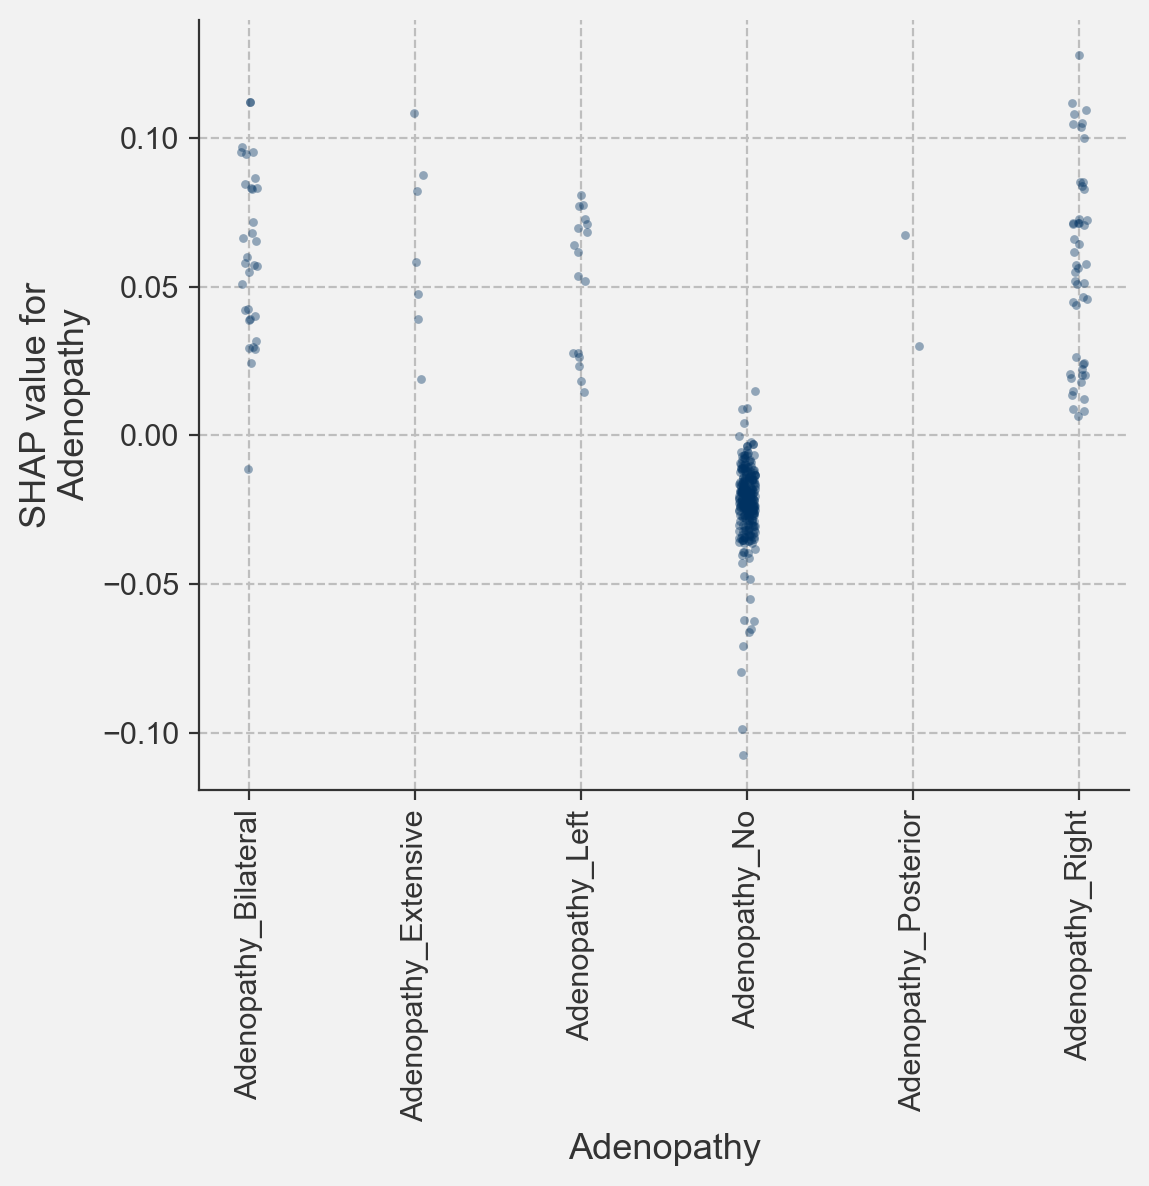

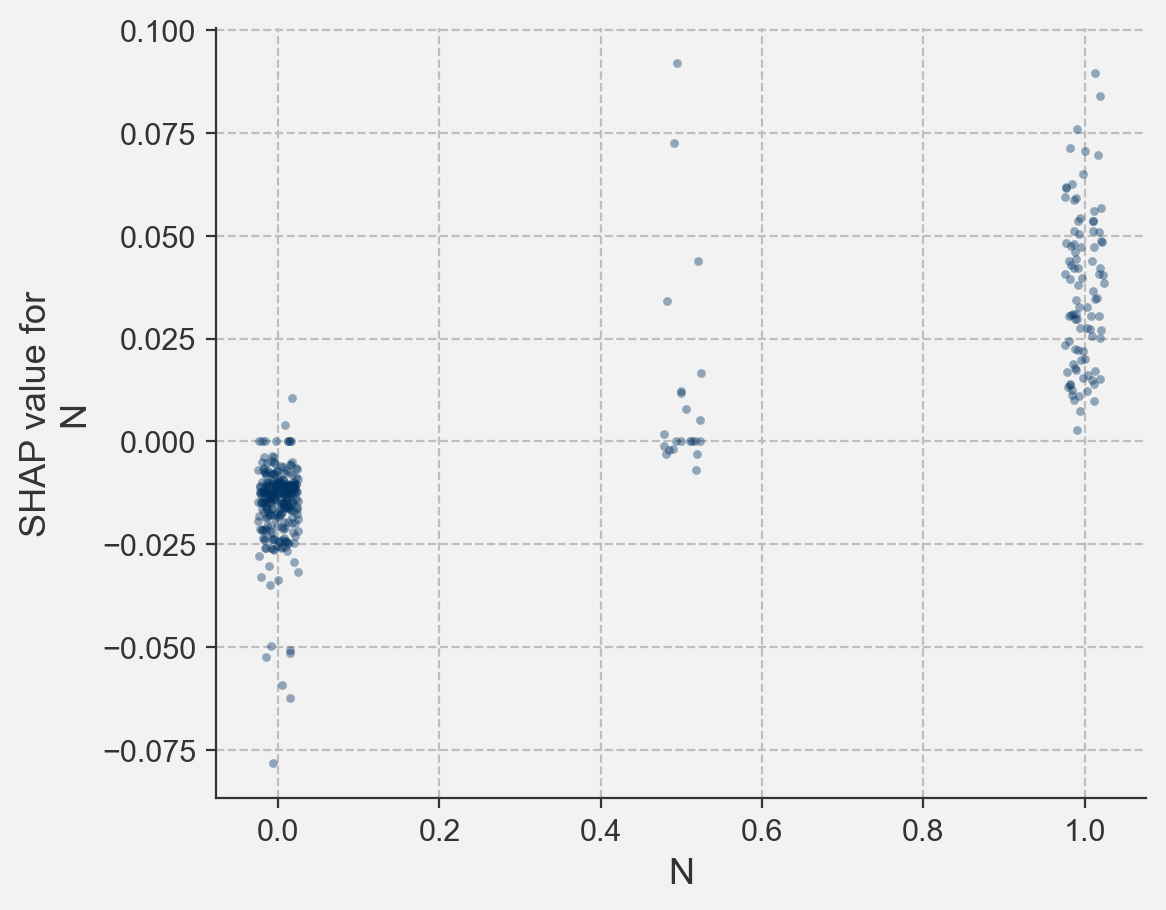

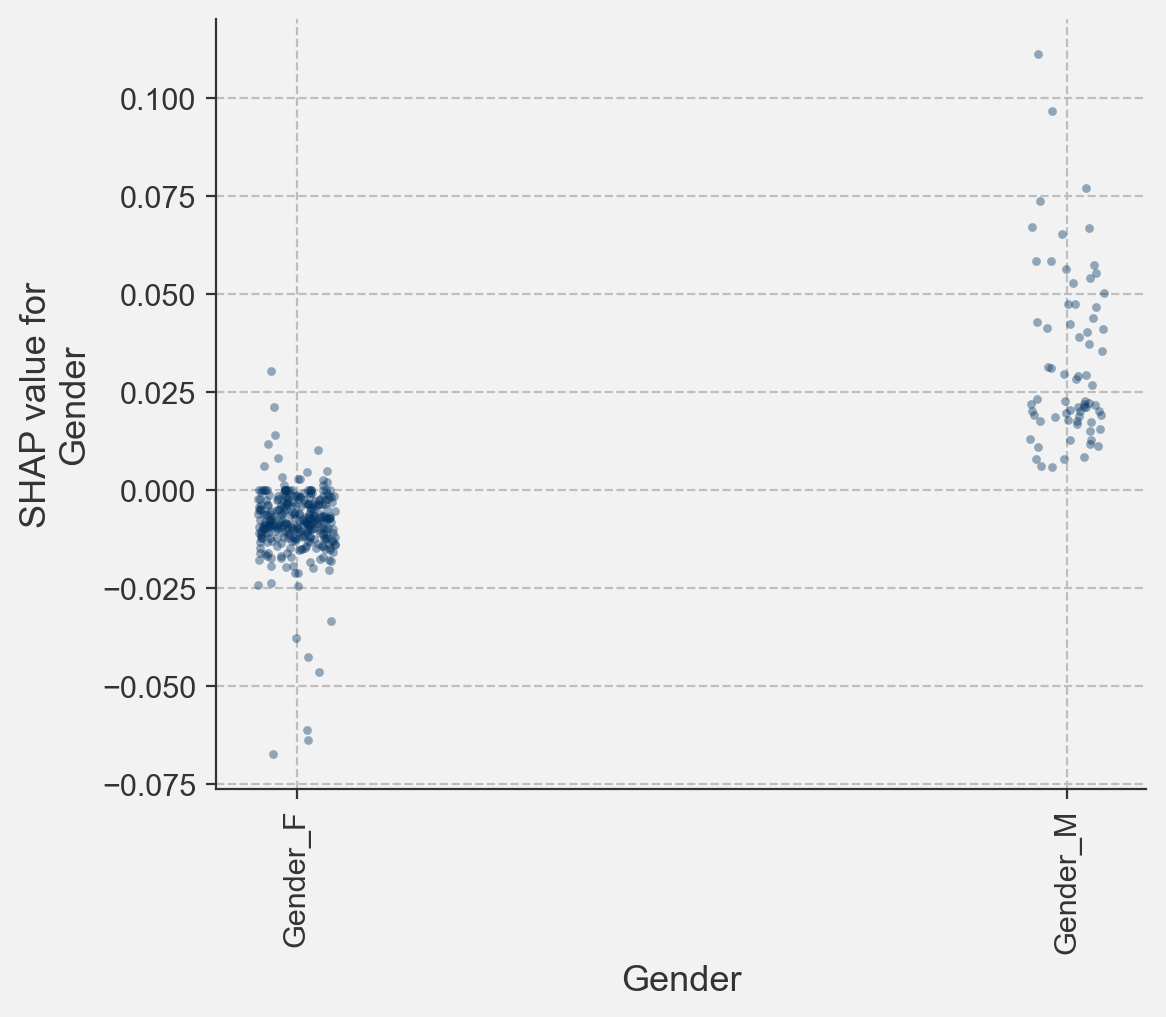

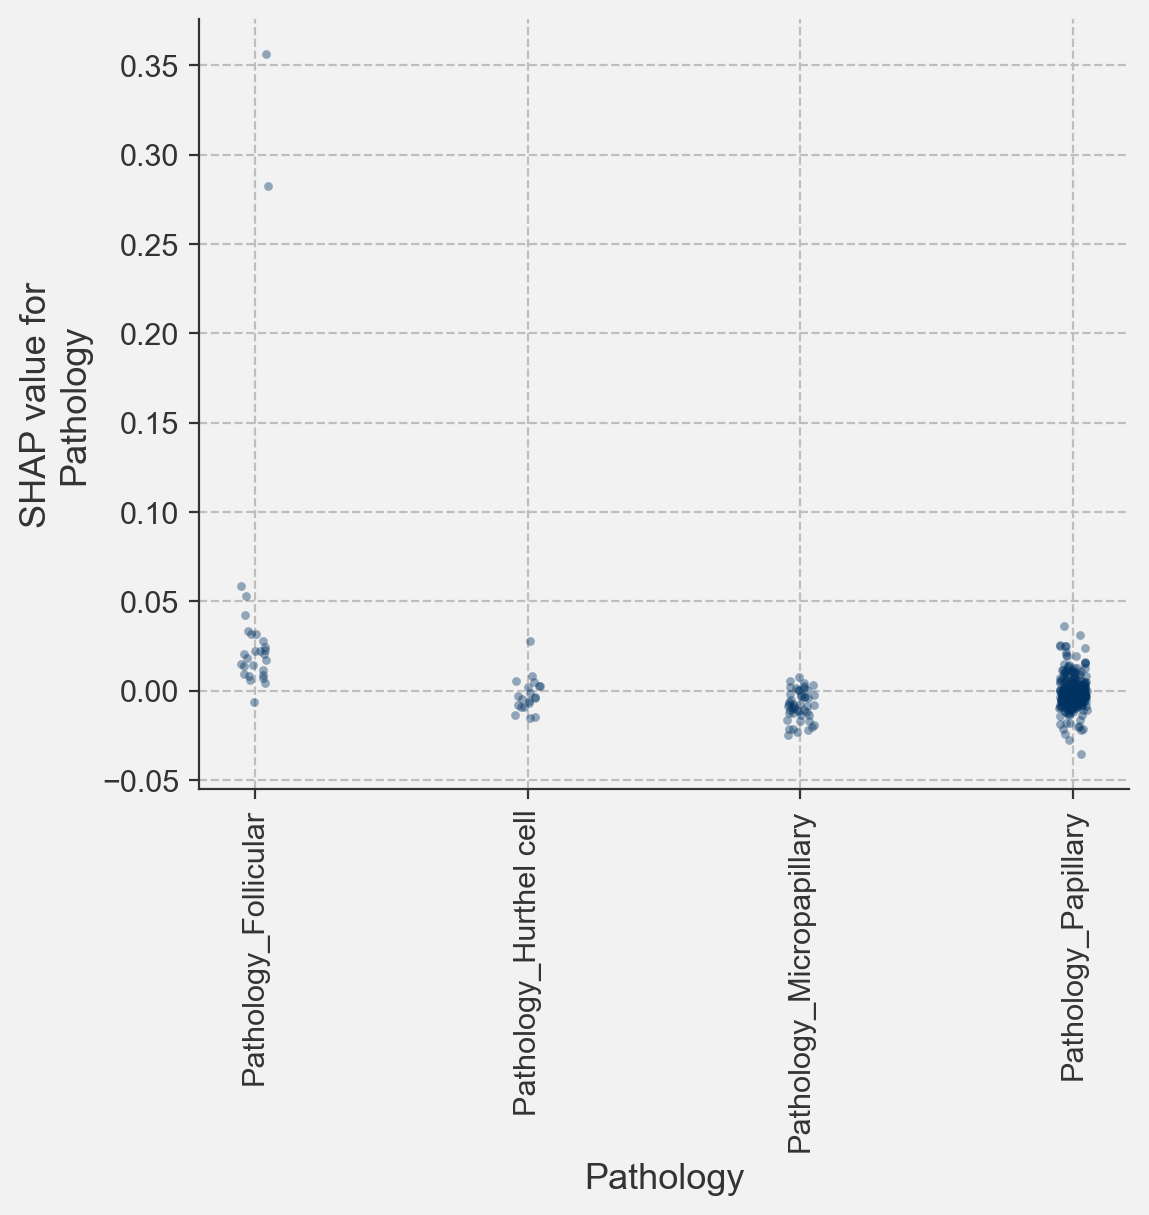

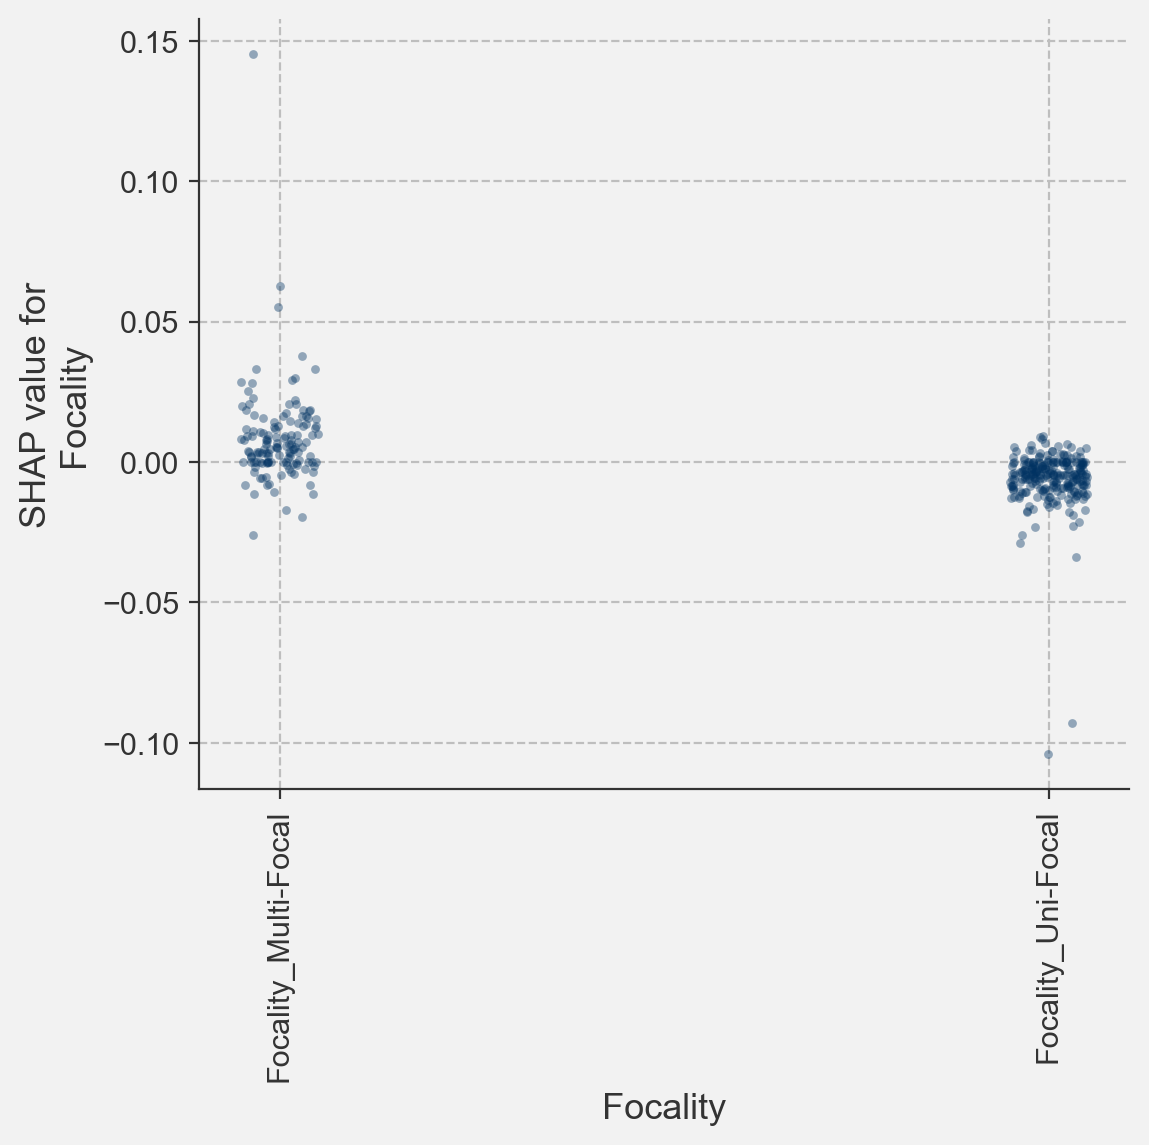

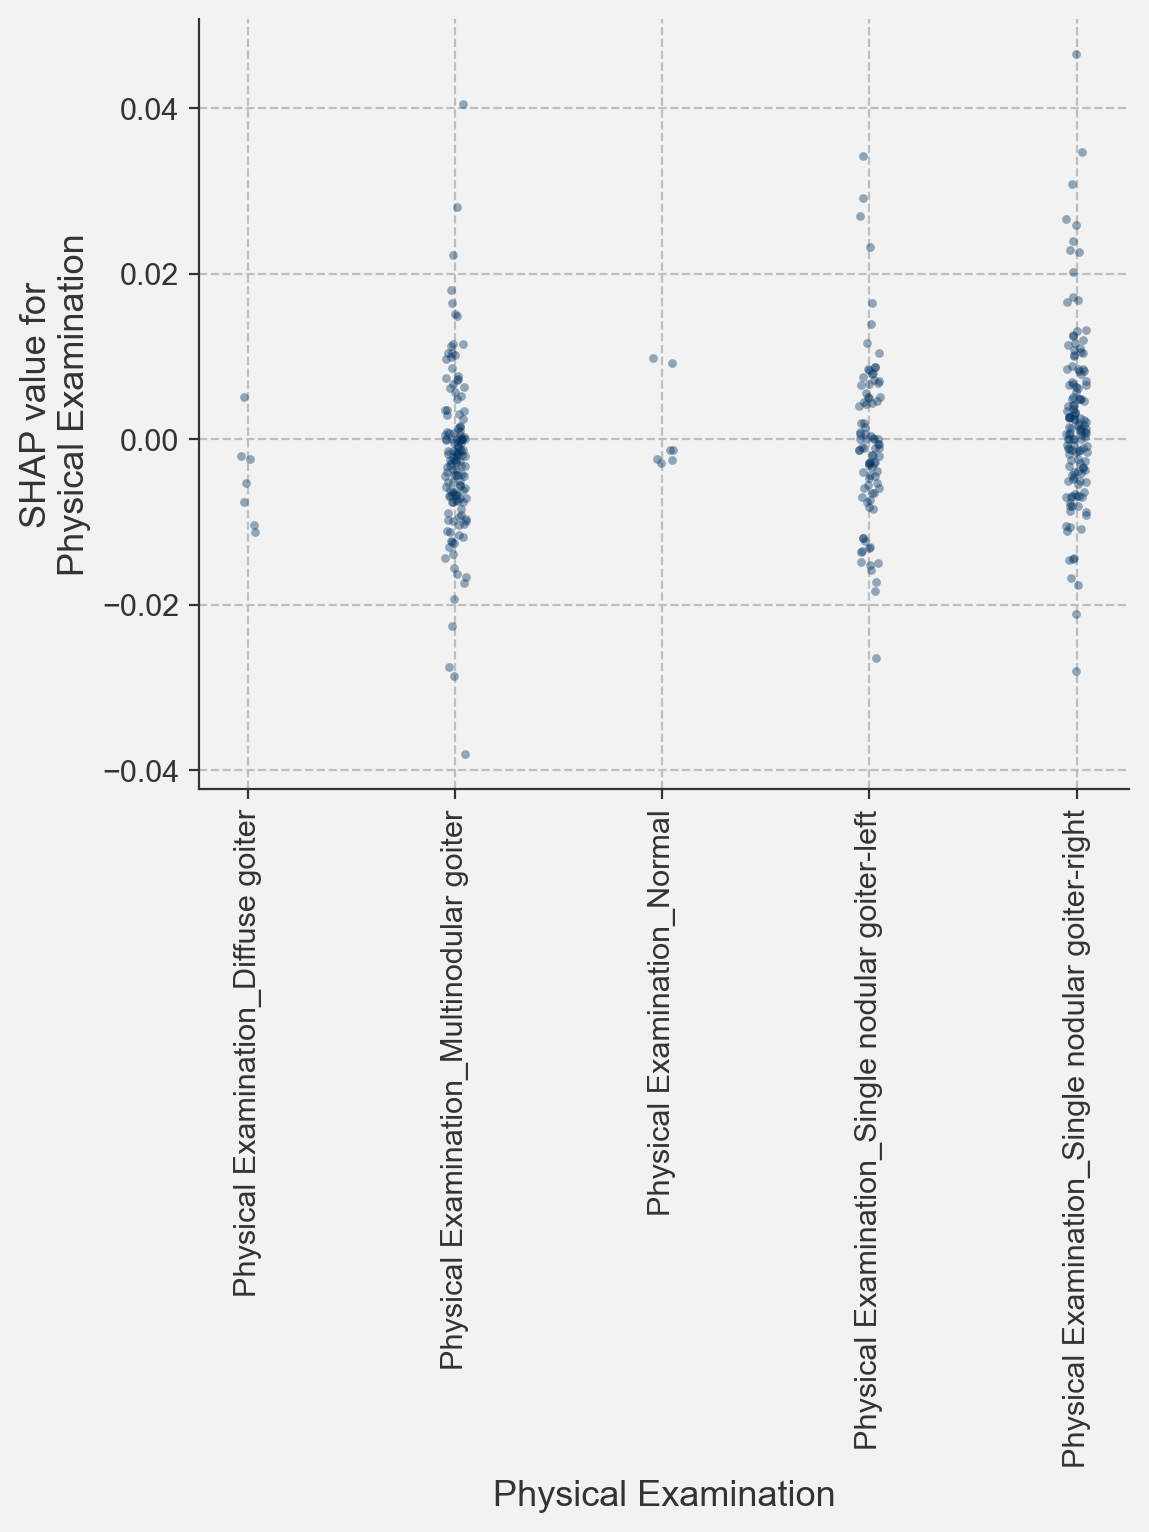

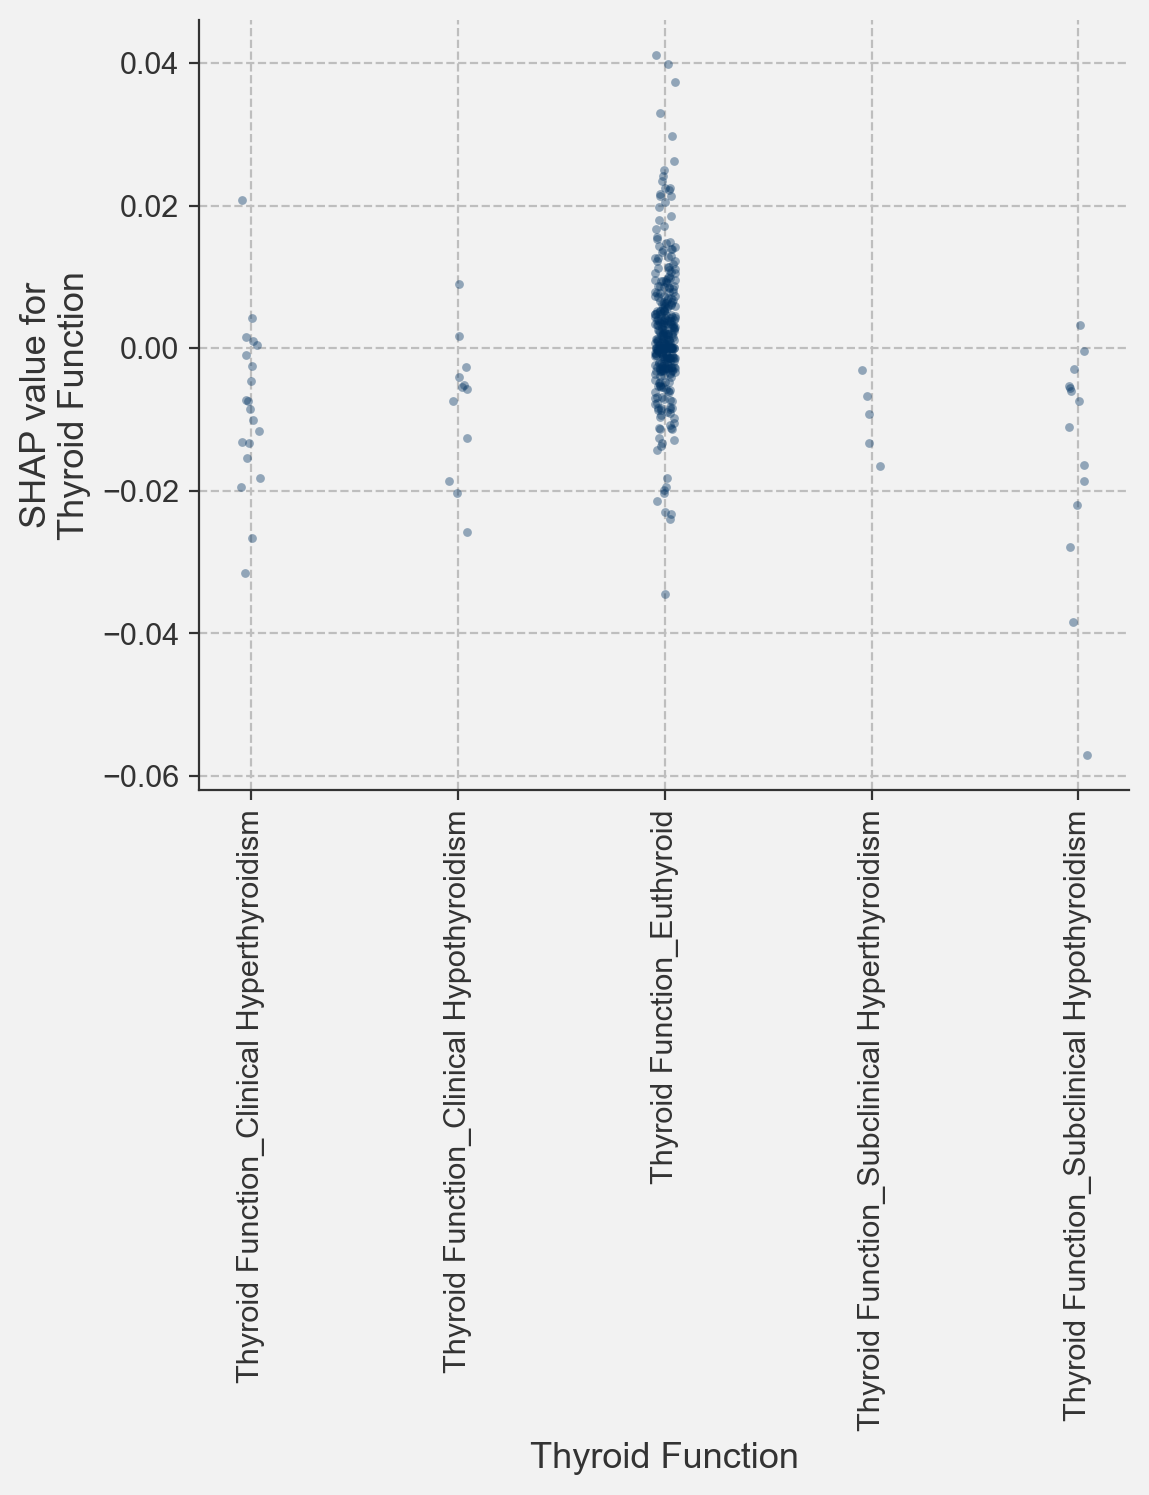

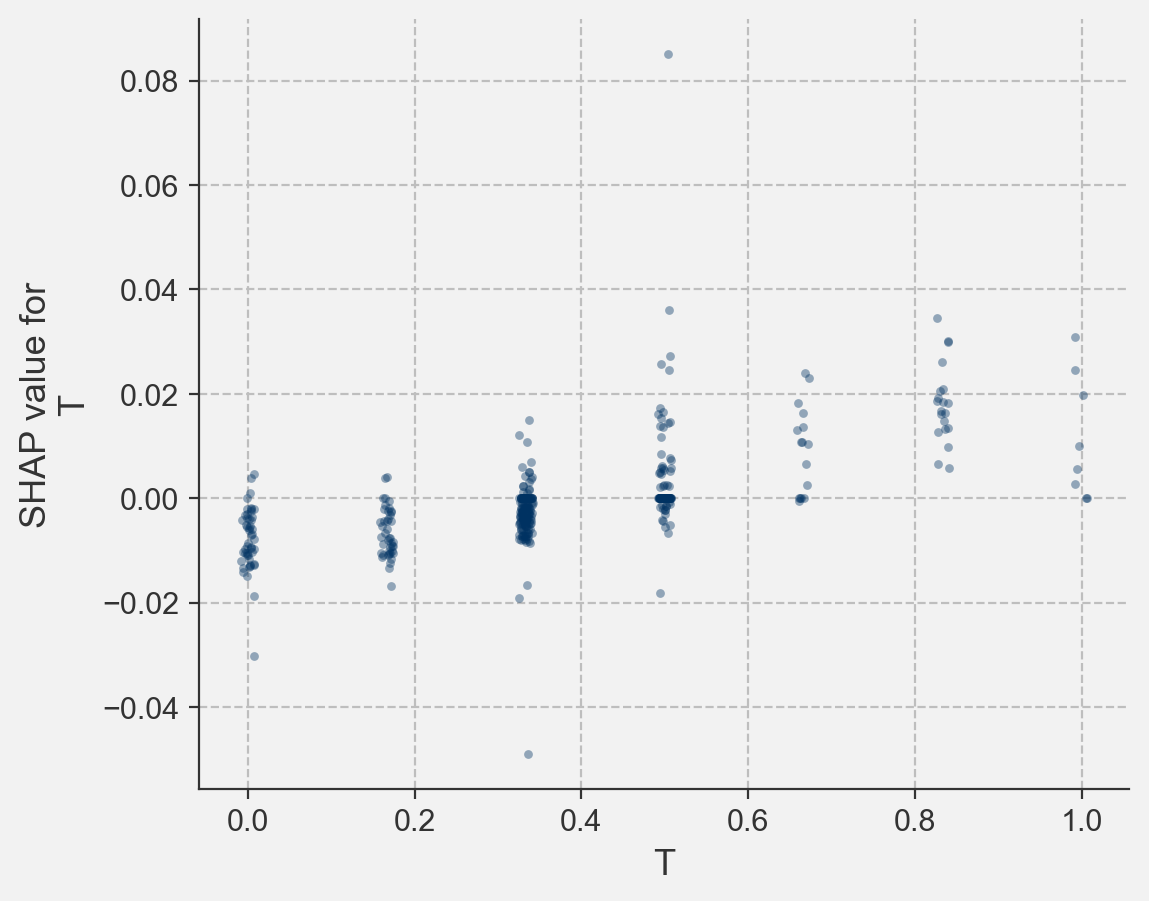

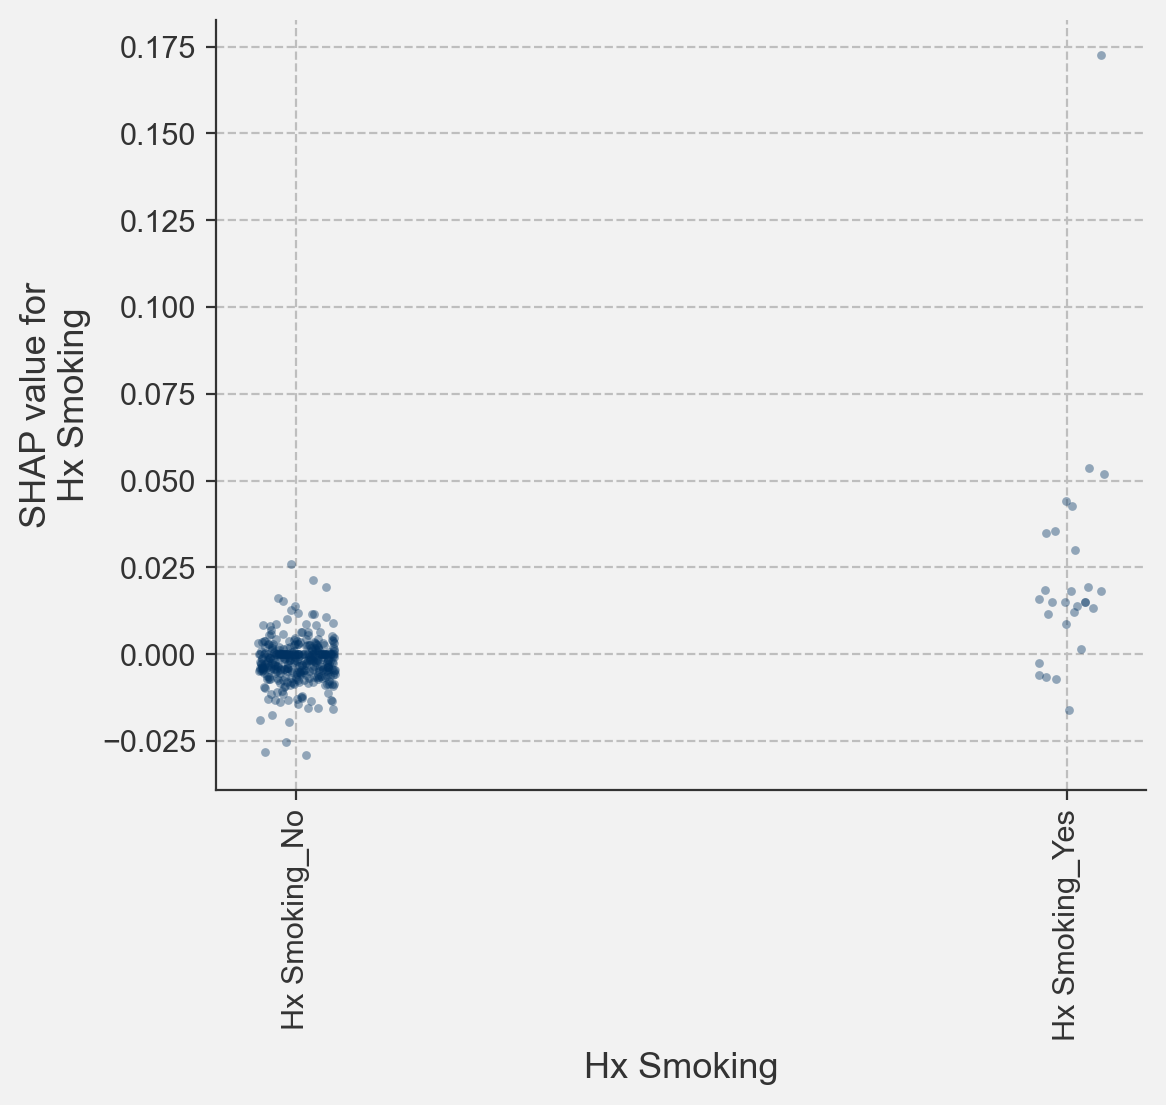

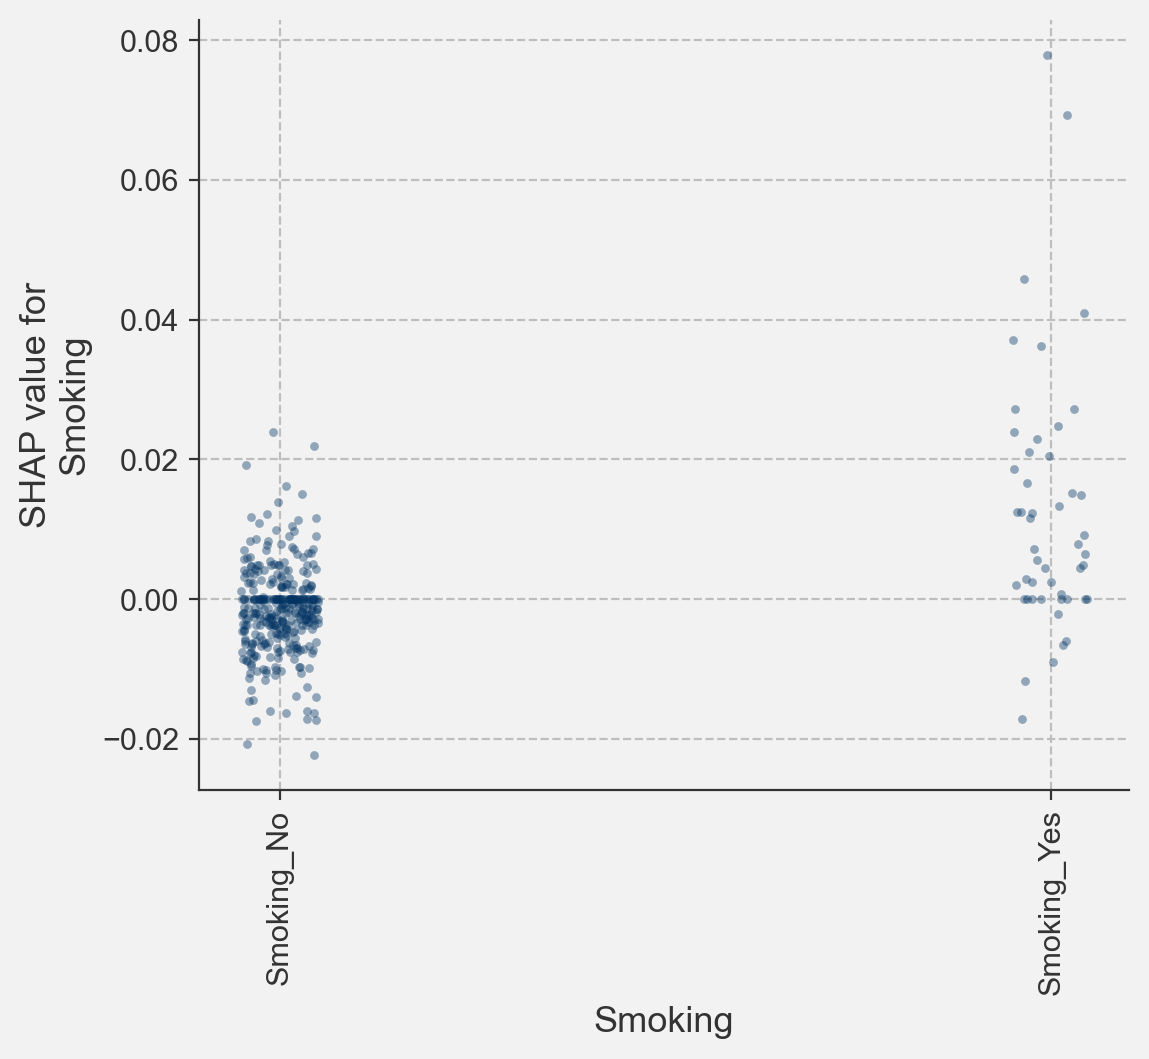

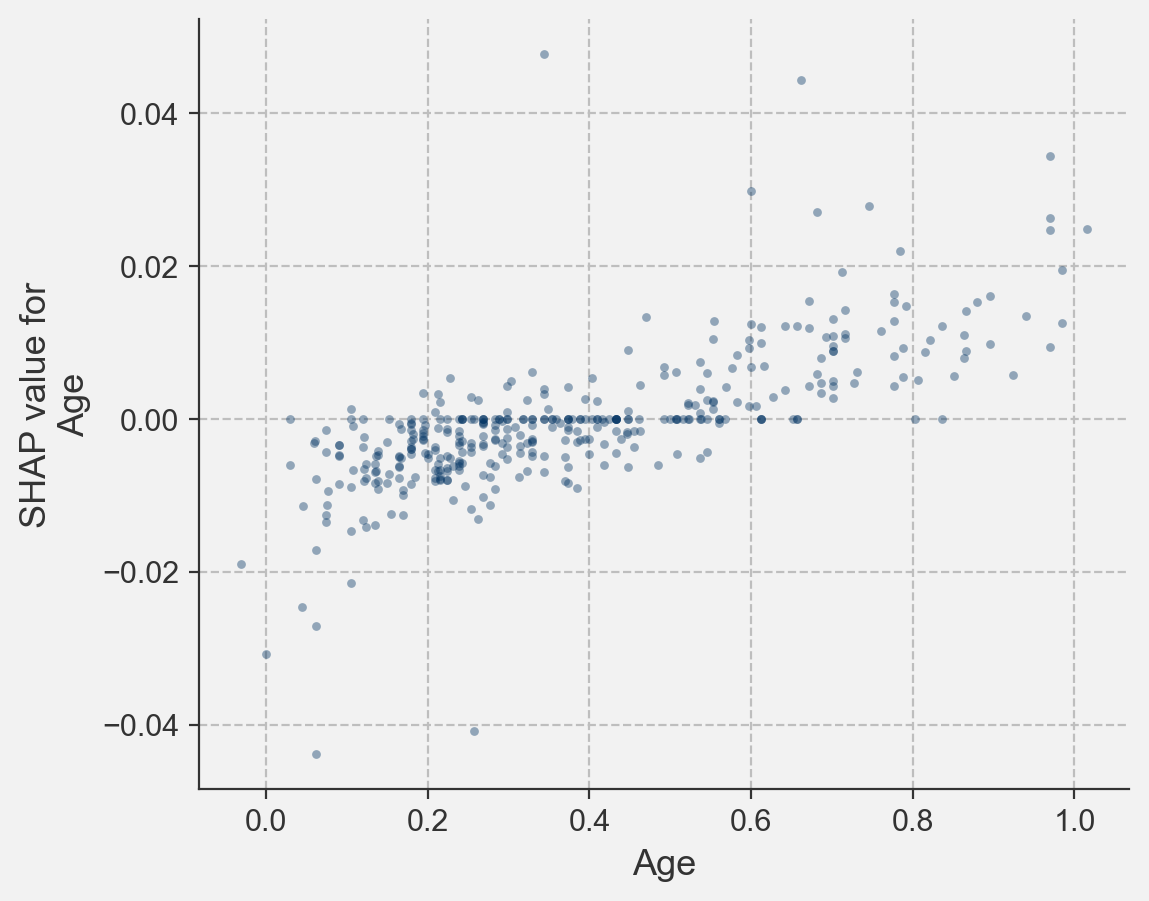

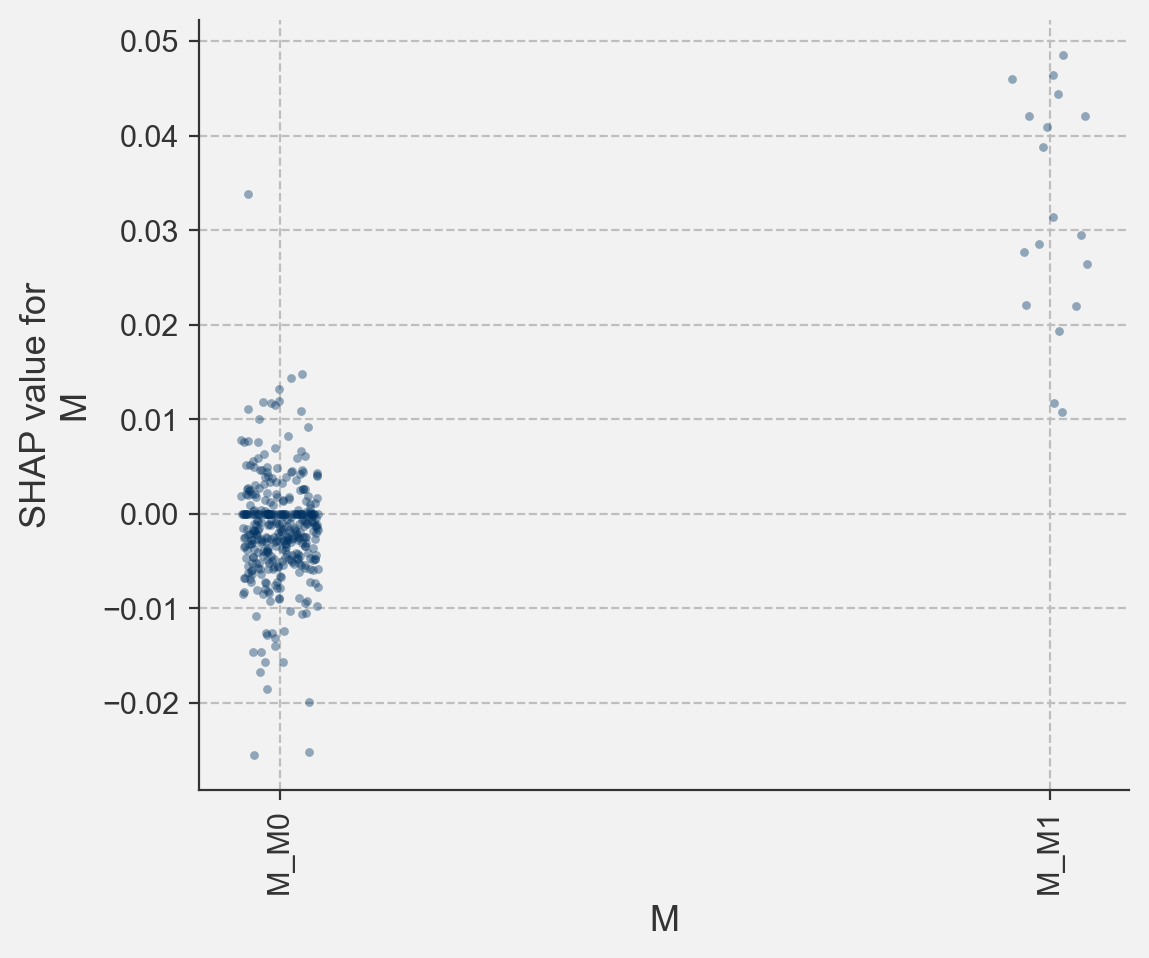

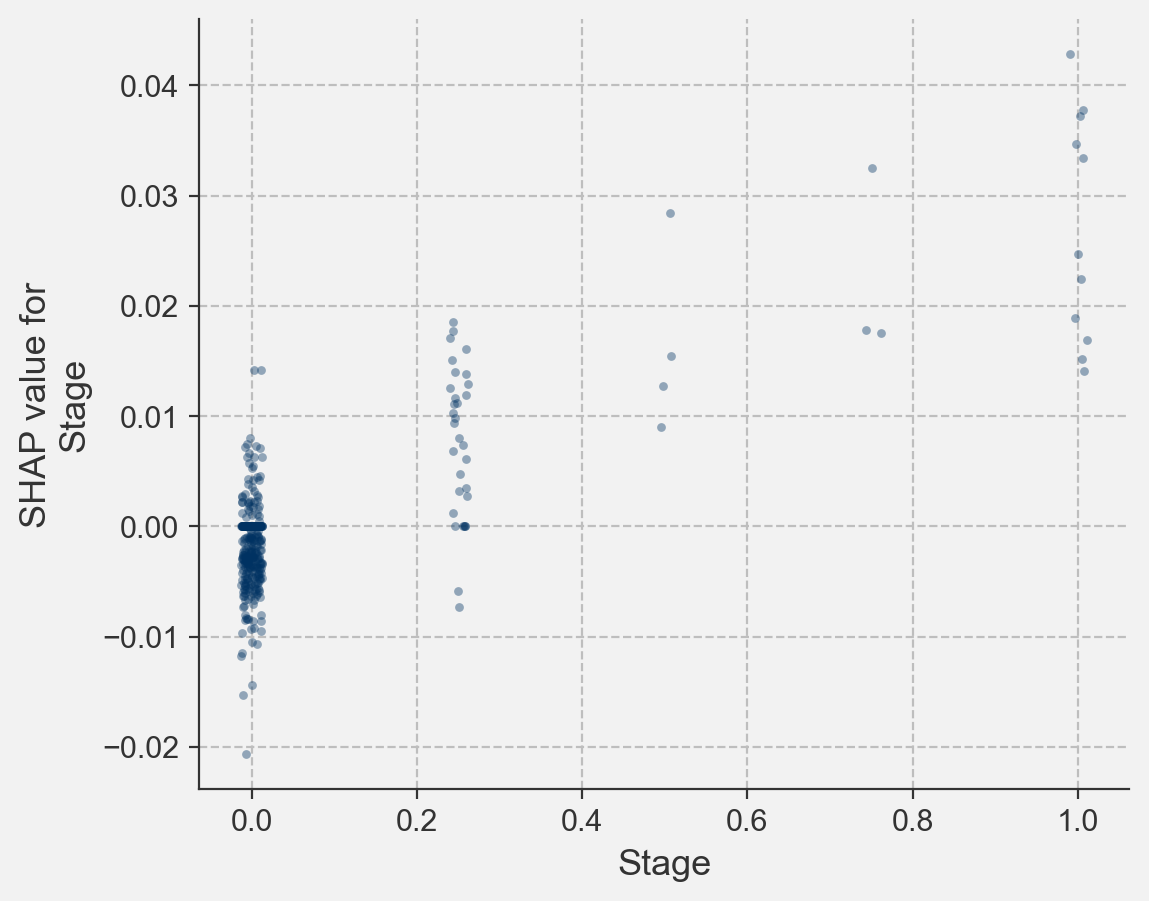

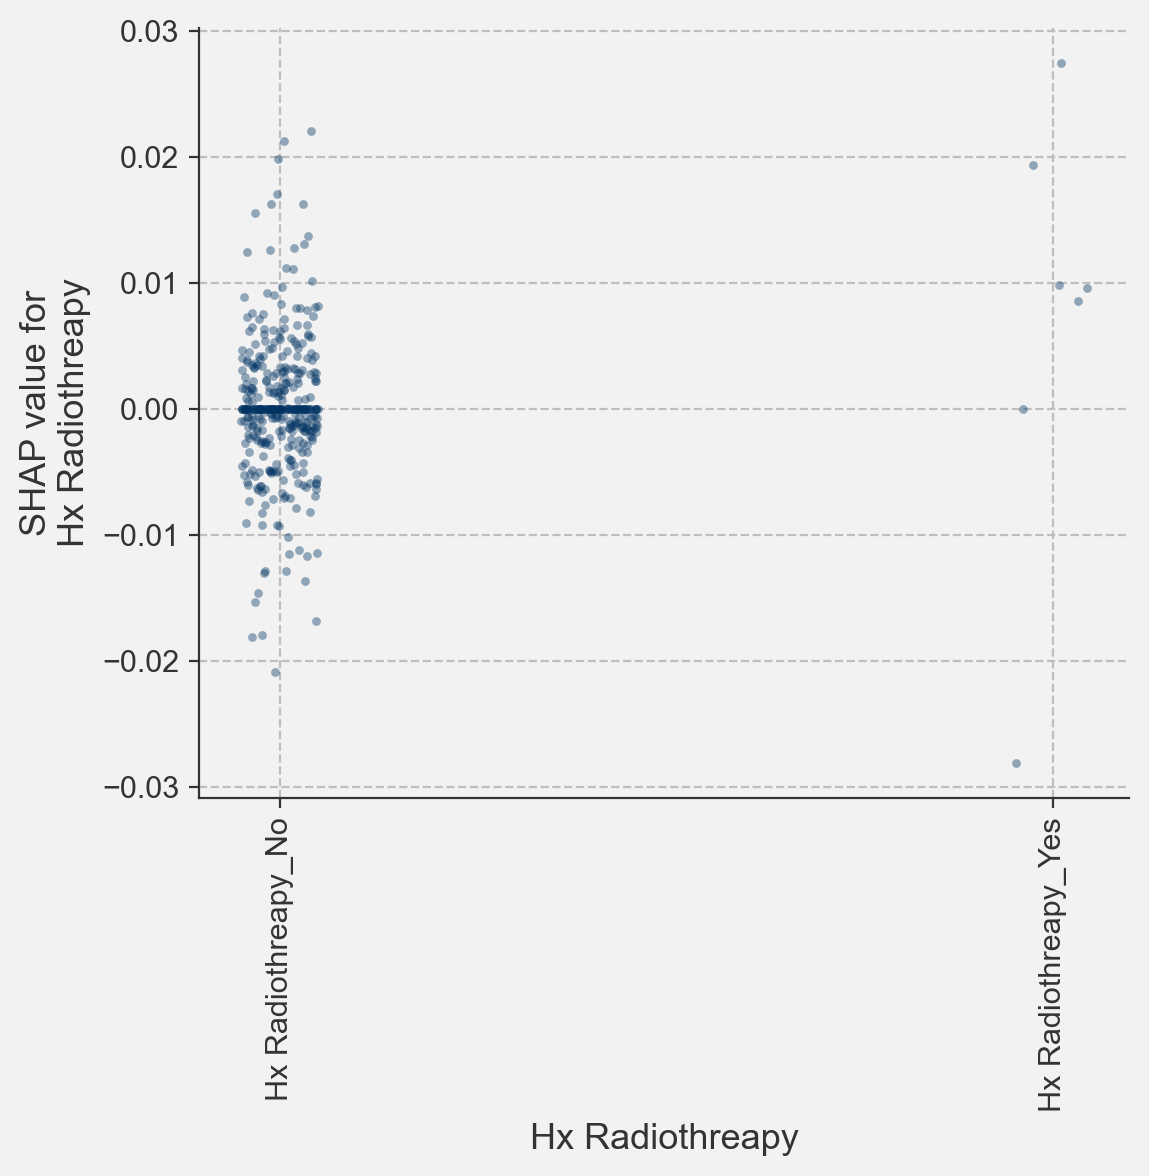

In [84]:
for i in range(len(combined_shap_values.abs.mean(0).argsort)):
    # Get the index of the feature with the (i+1)-th highest mean absolute SHAP value
    feature_index = combined_shap_values.abs.mean(0).argsort[-(i+1)]
    

    shap.plots.scatter(
        combined_shap_values[:, feature_index],
        alpha=0.4,
        x_jitter=0.1,
        hist=False,
        dot_size=10,
        color='#003262'
    )
    

# misclassified

FN


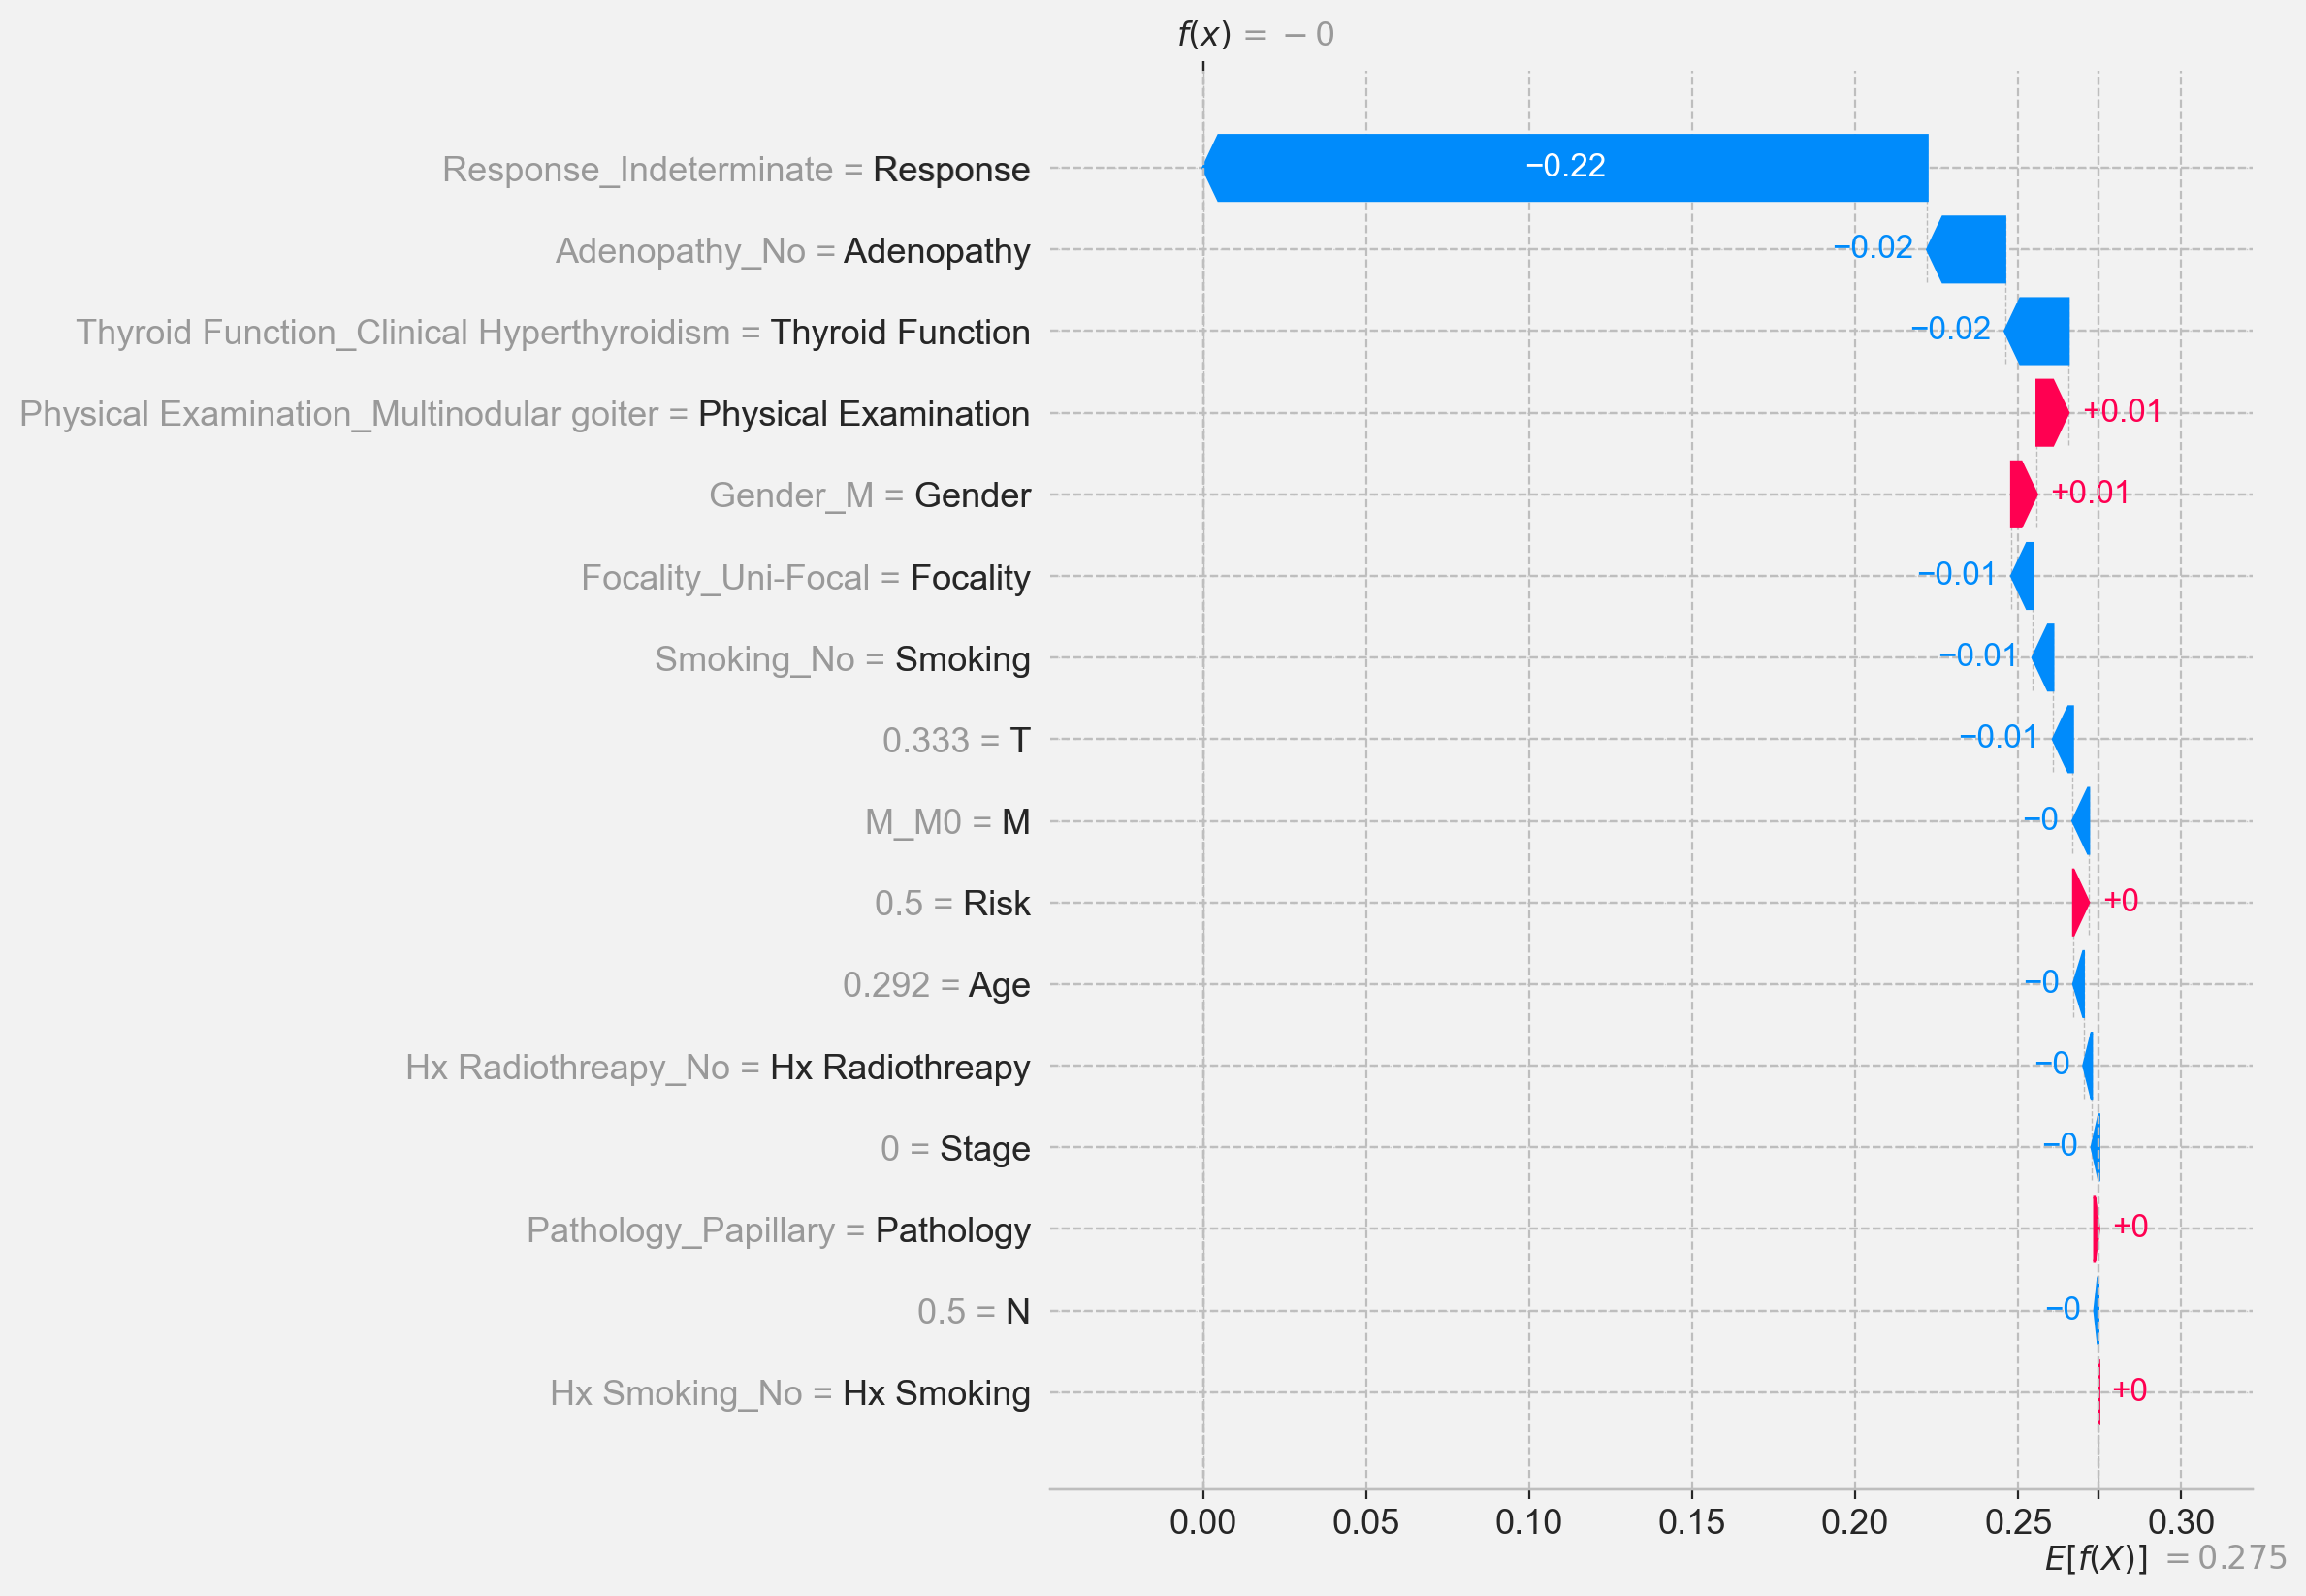

FP


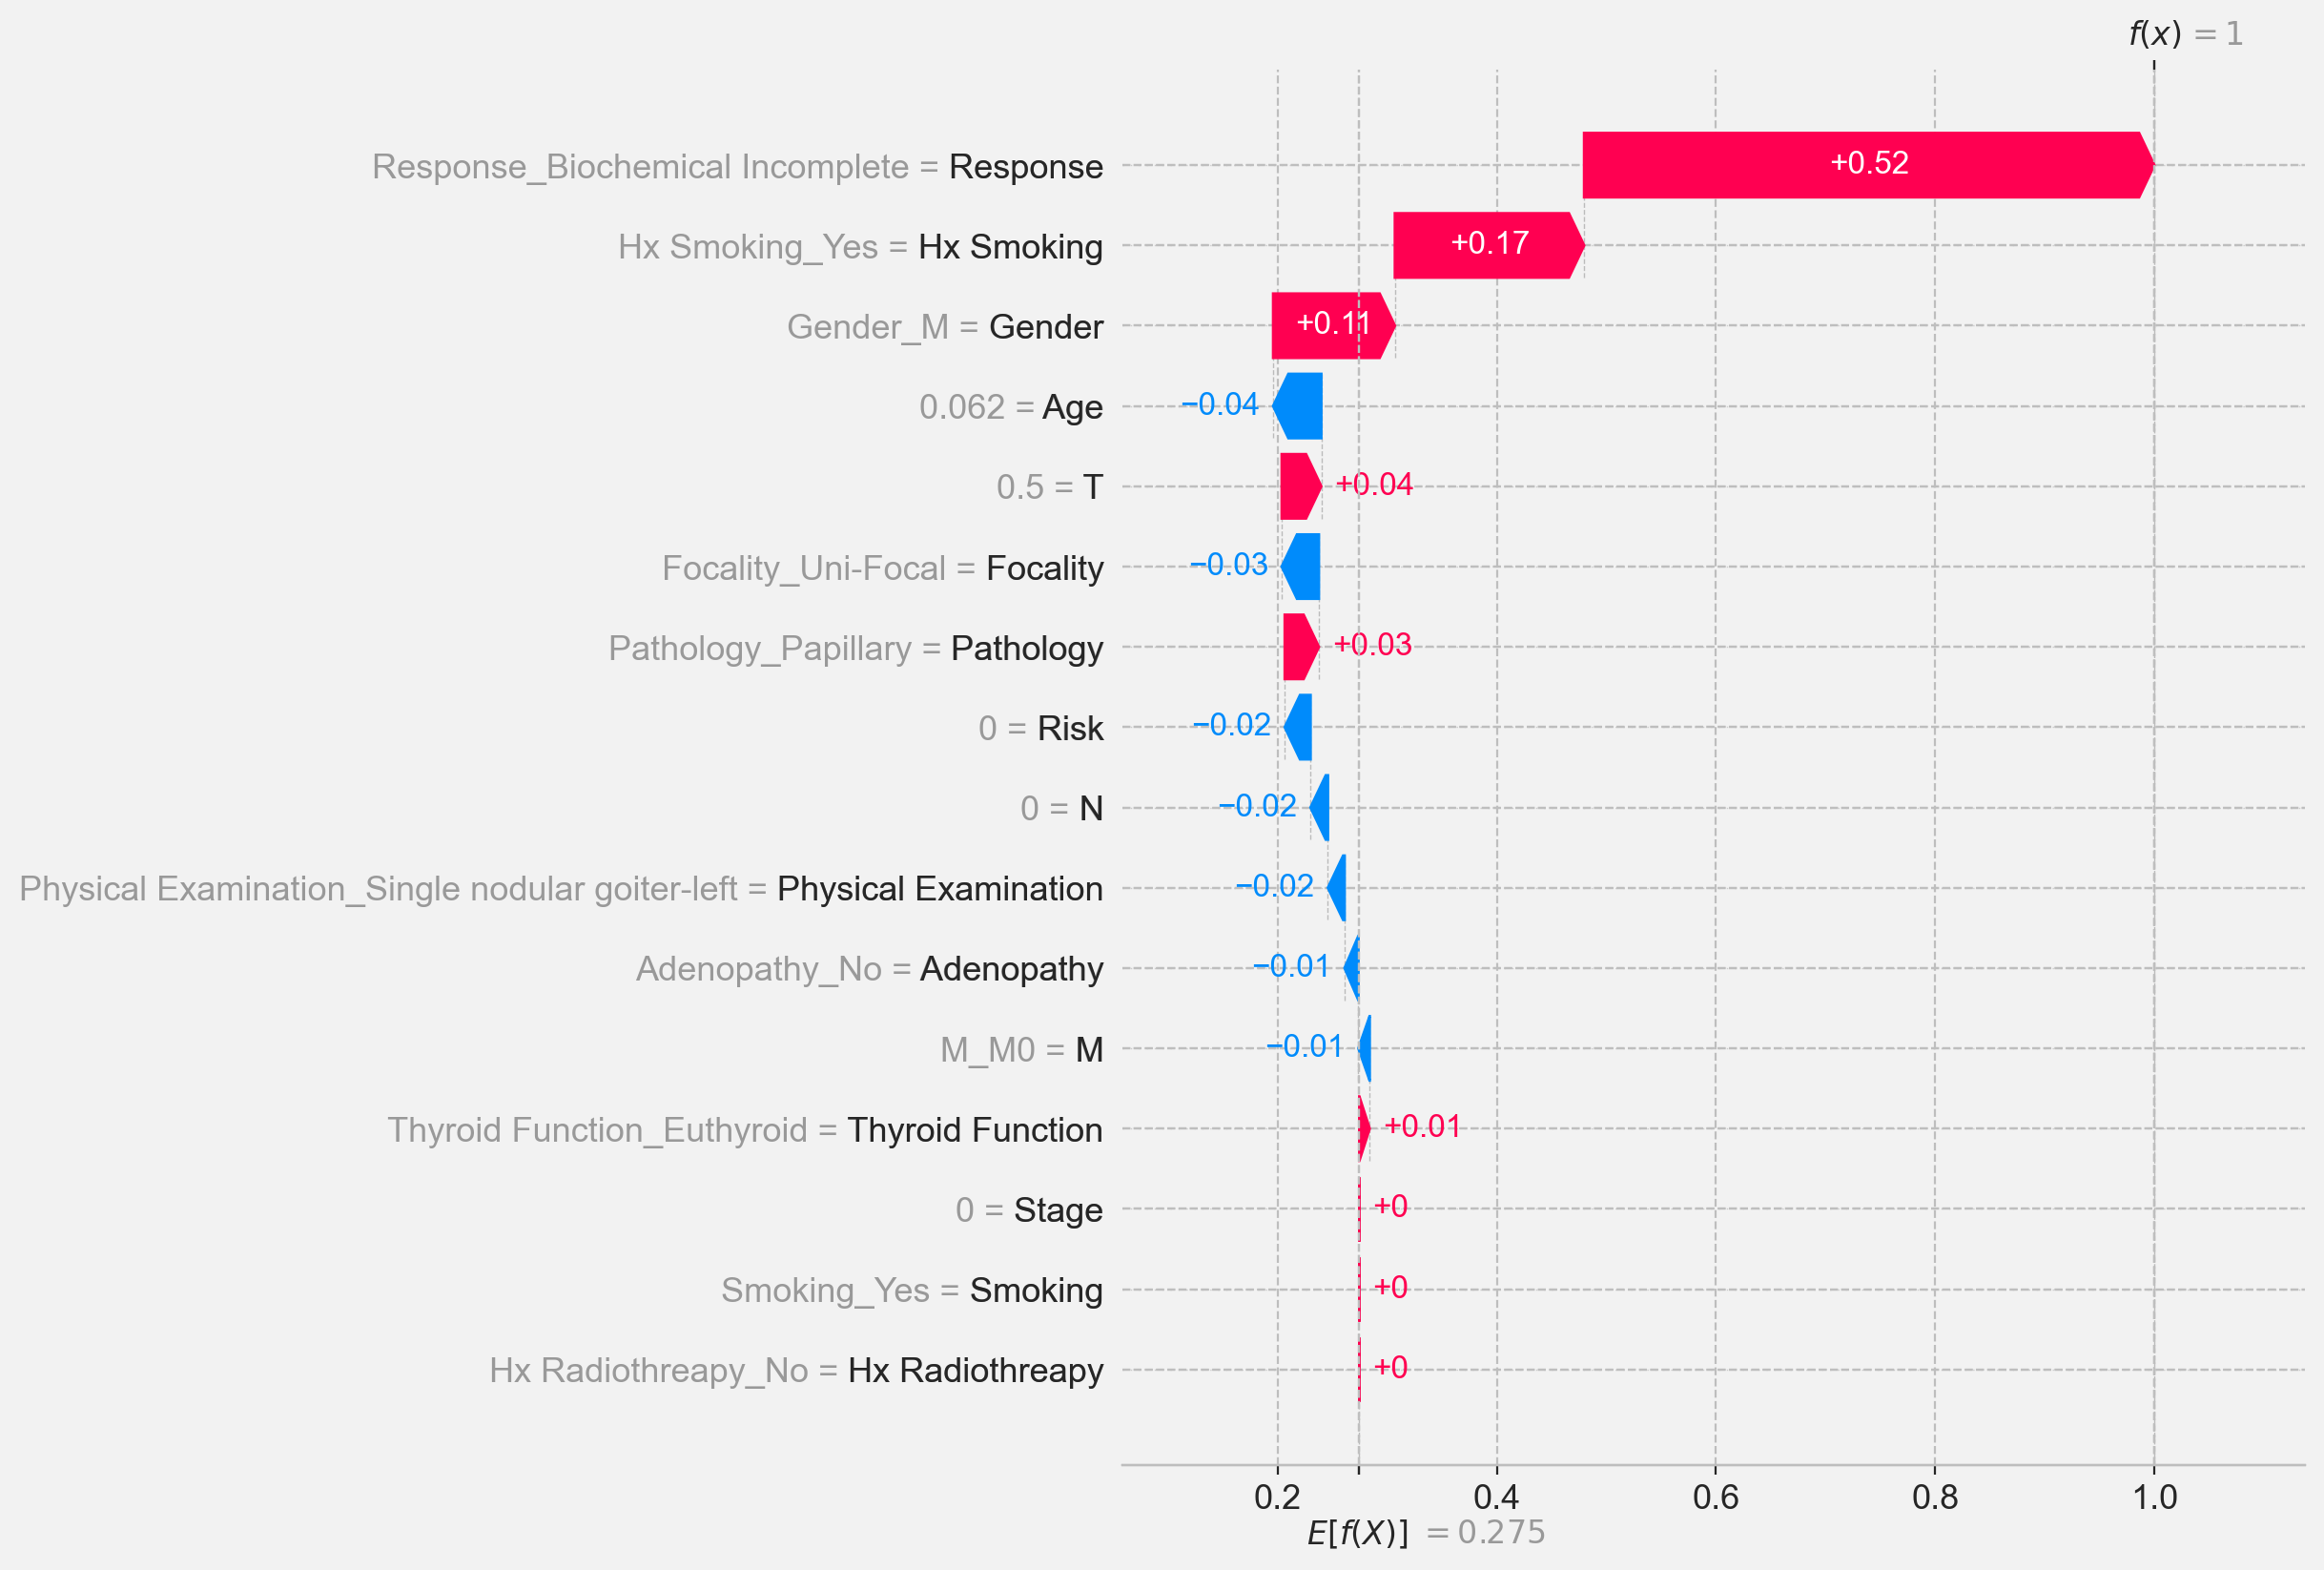

FN


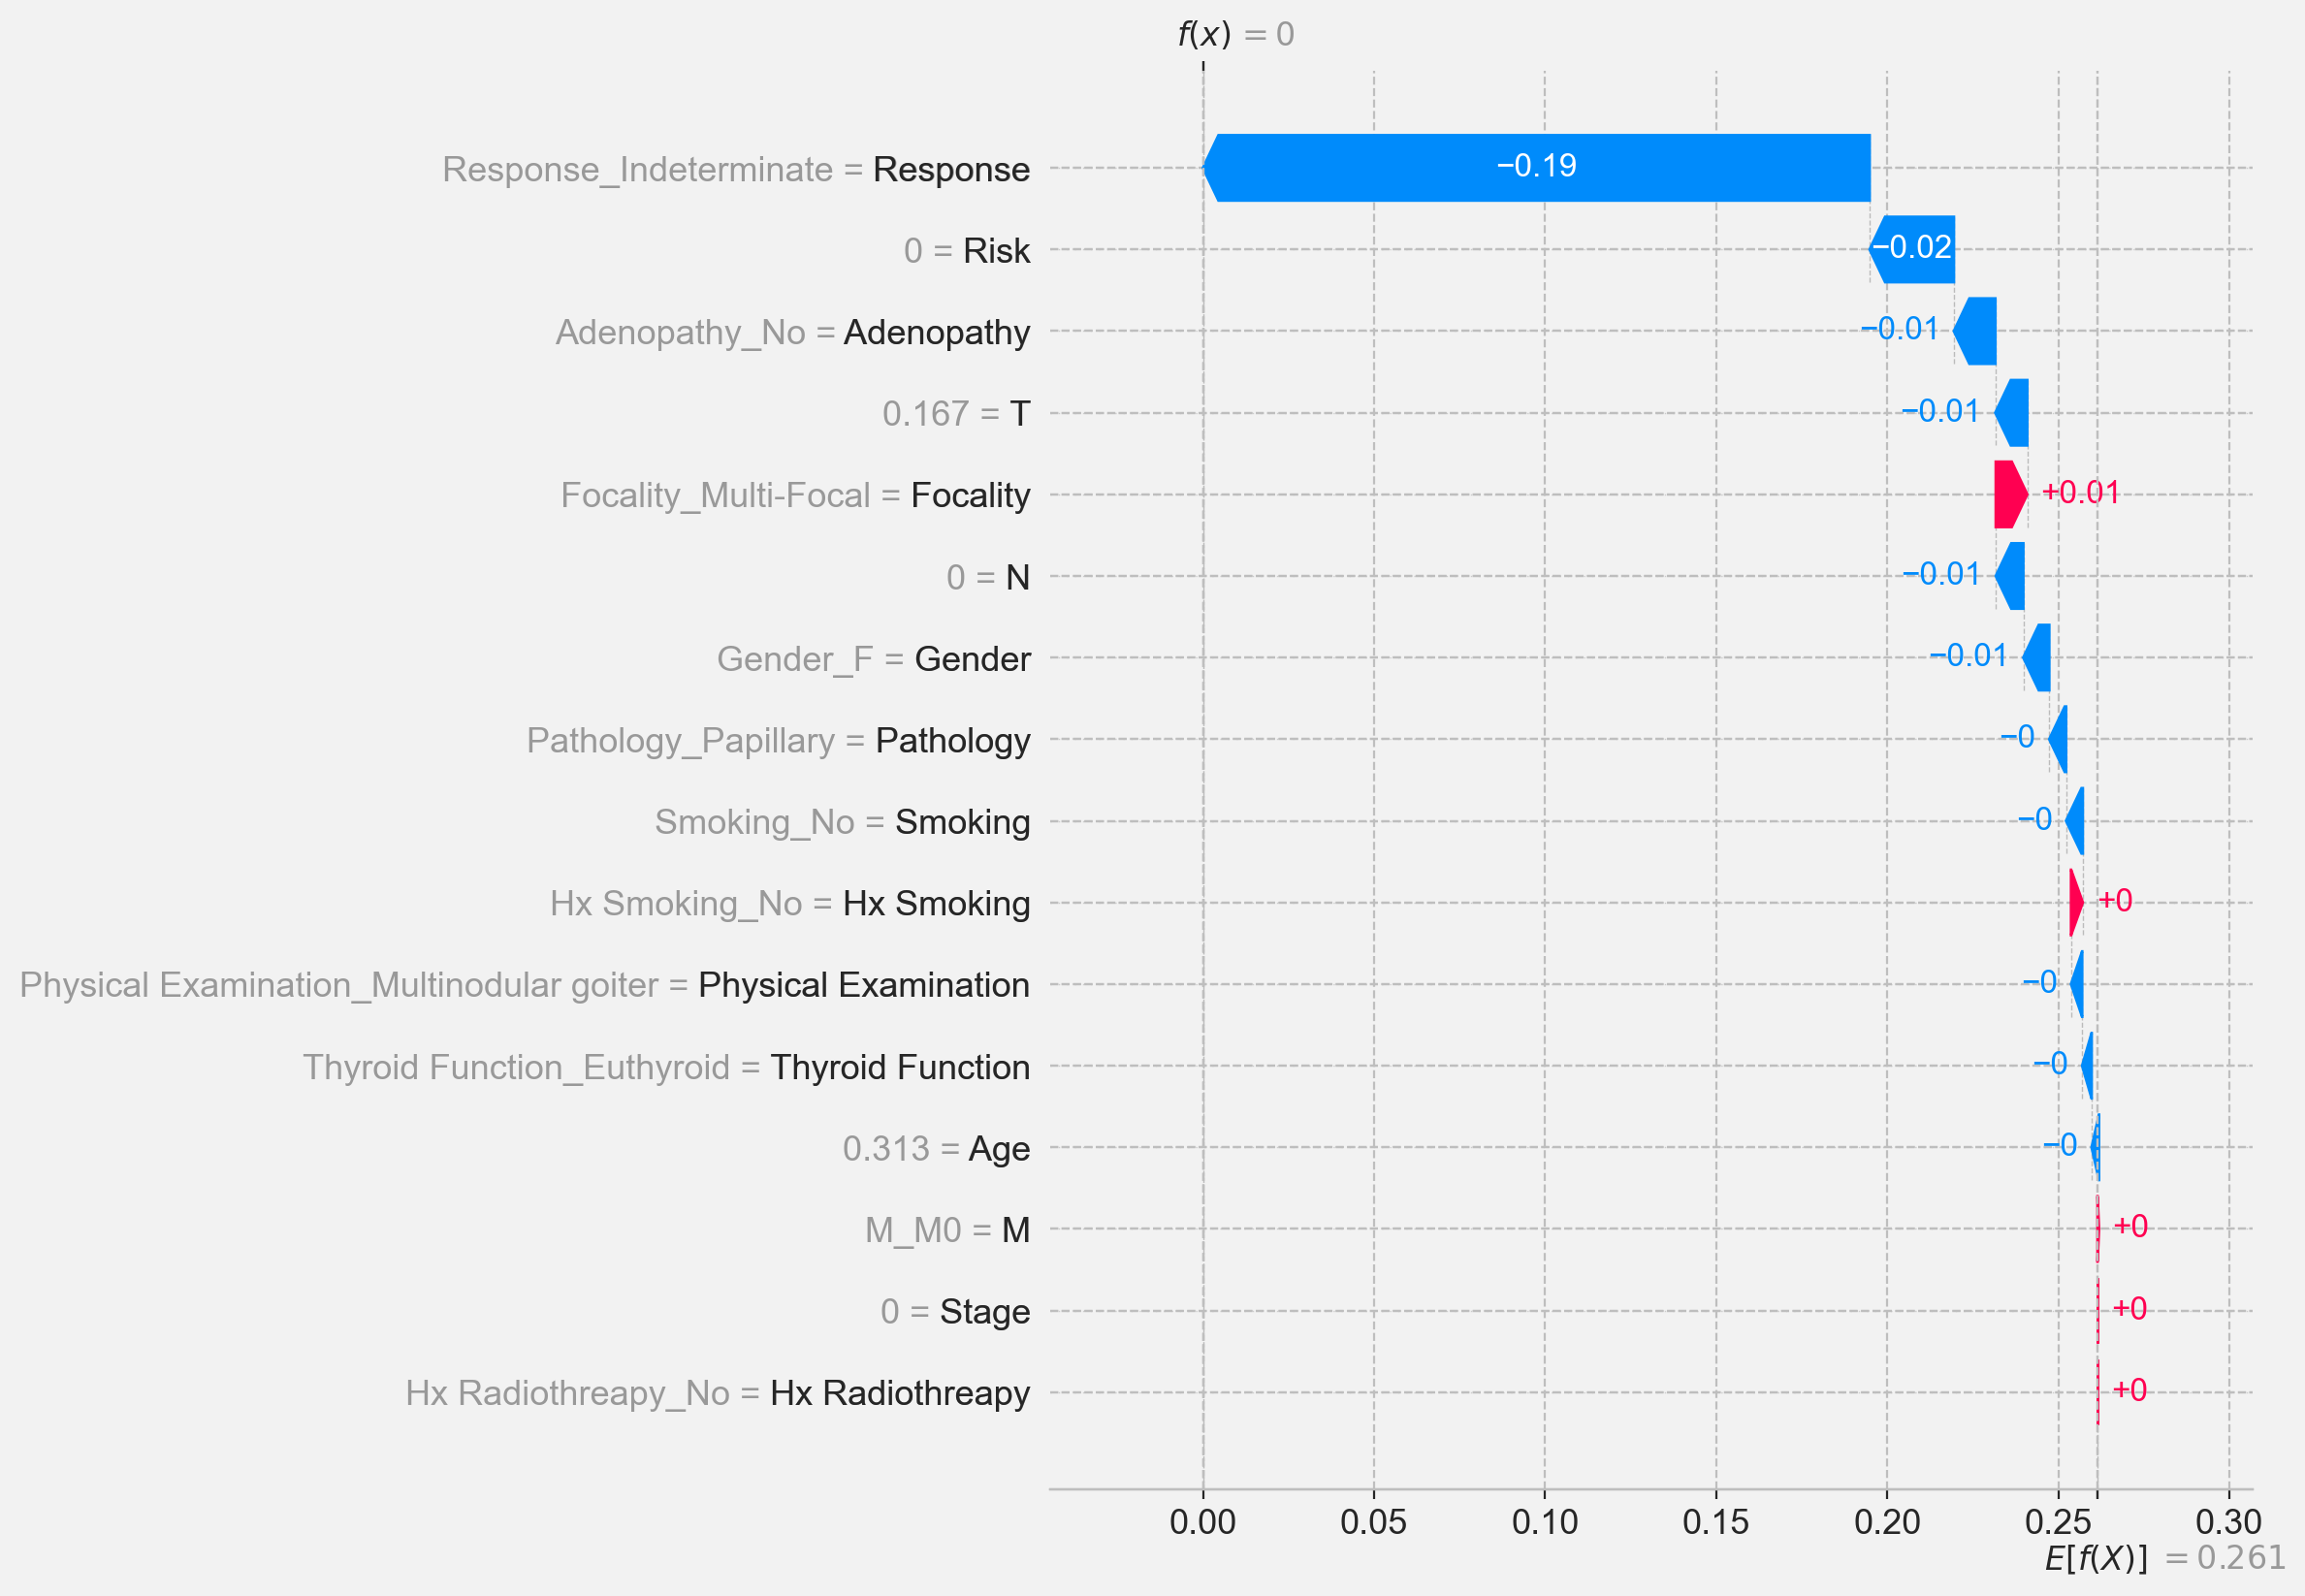

FN


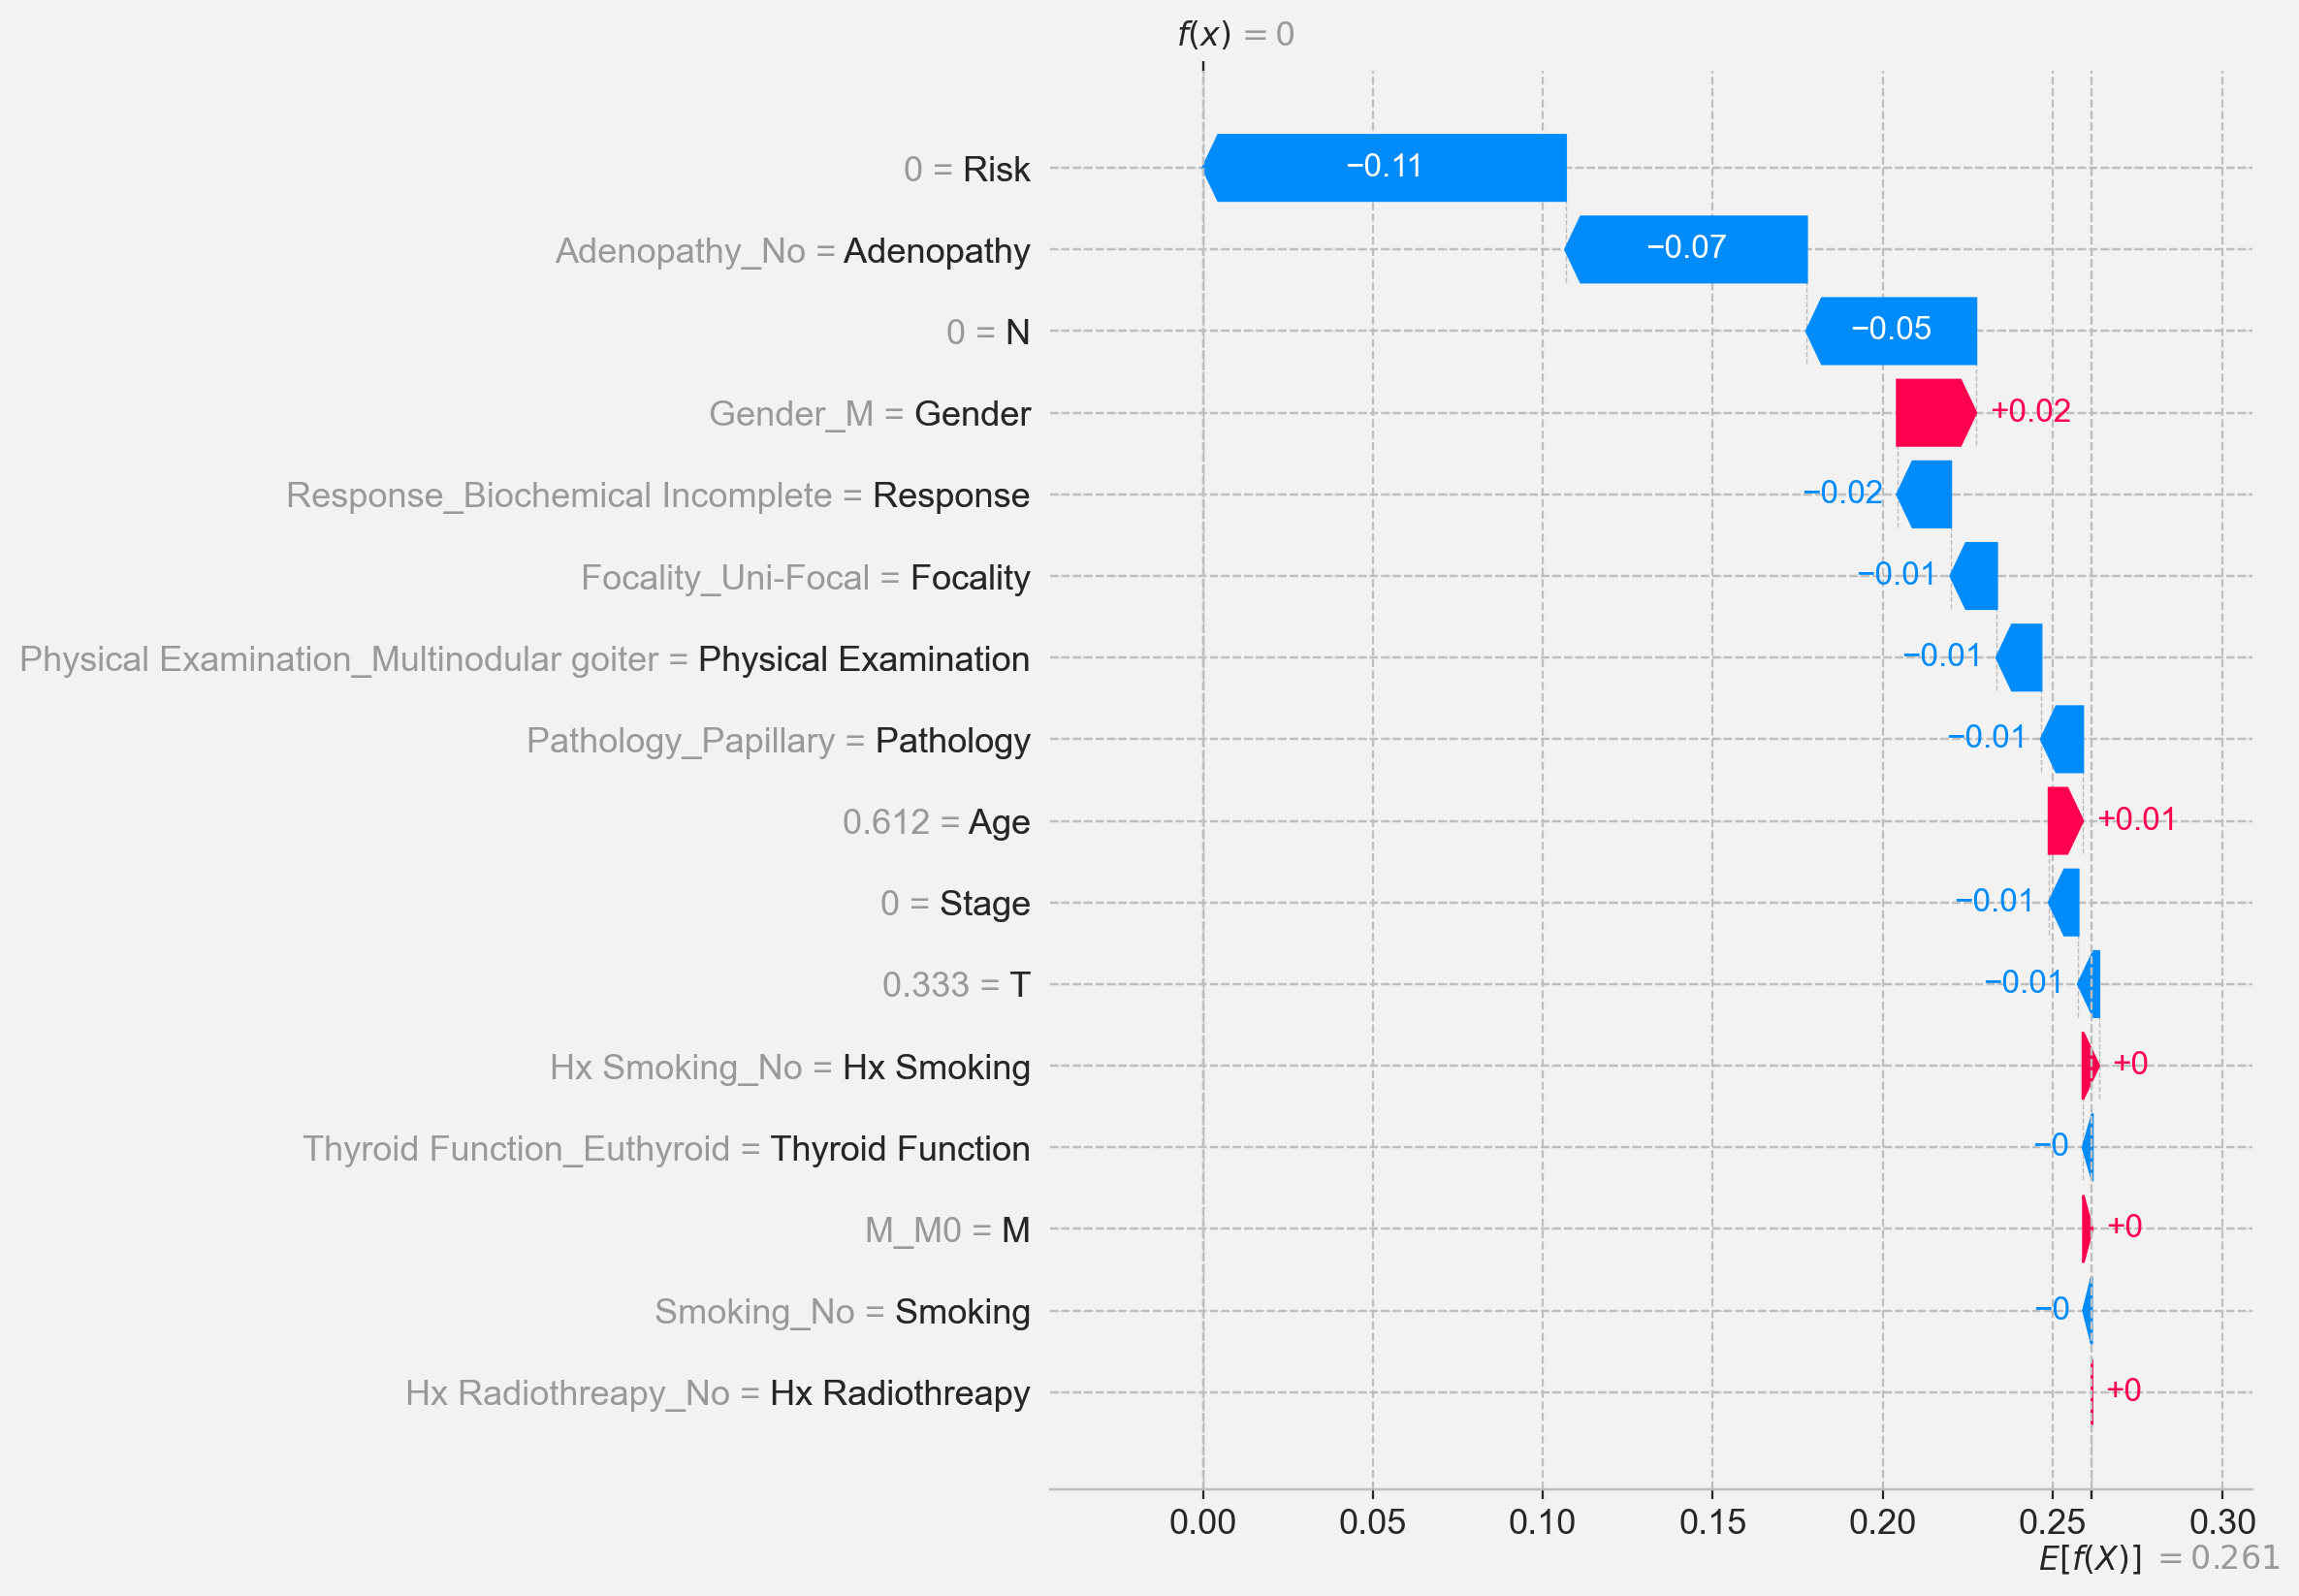

FP


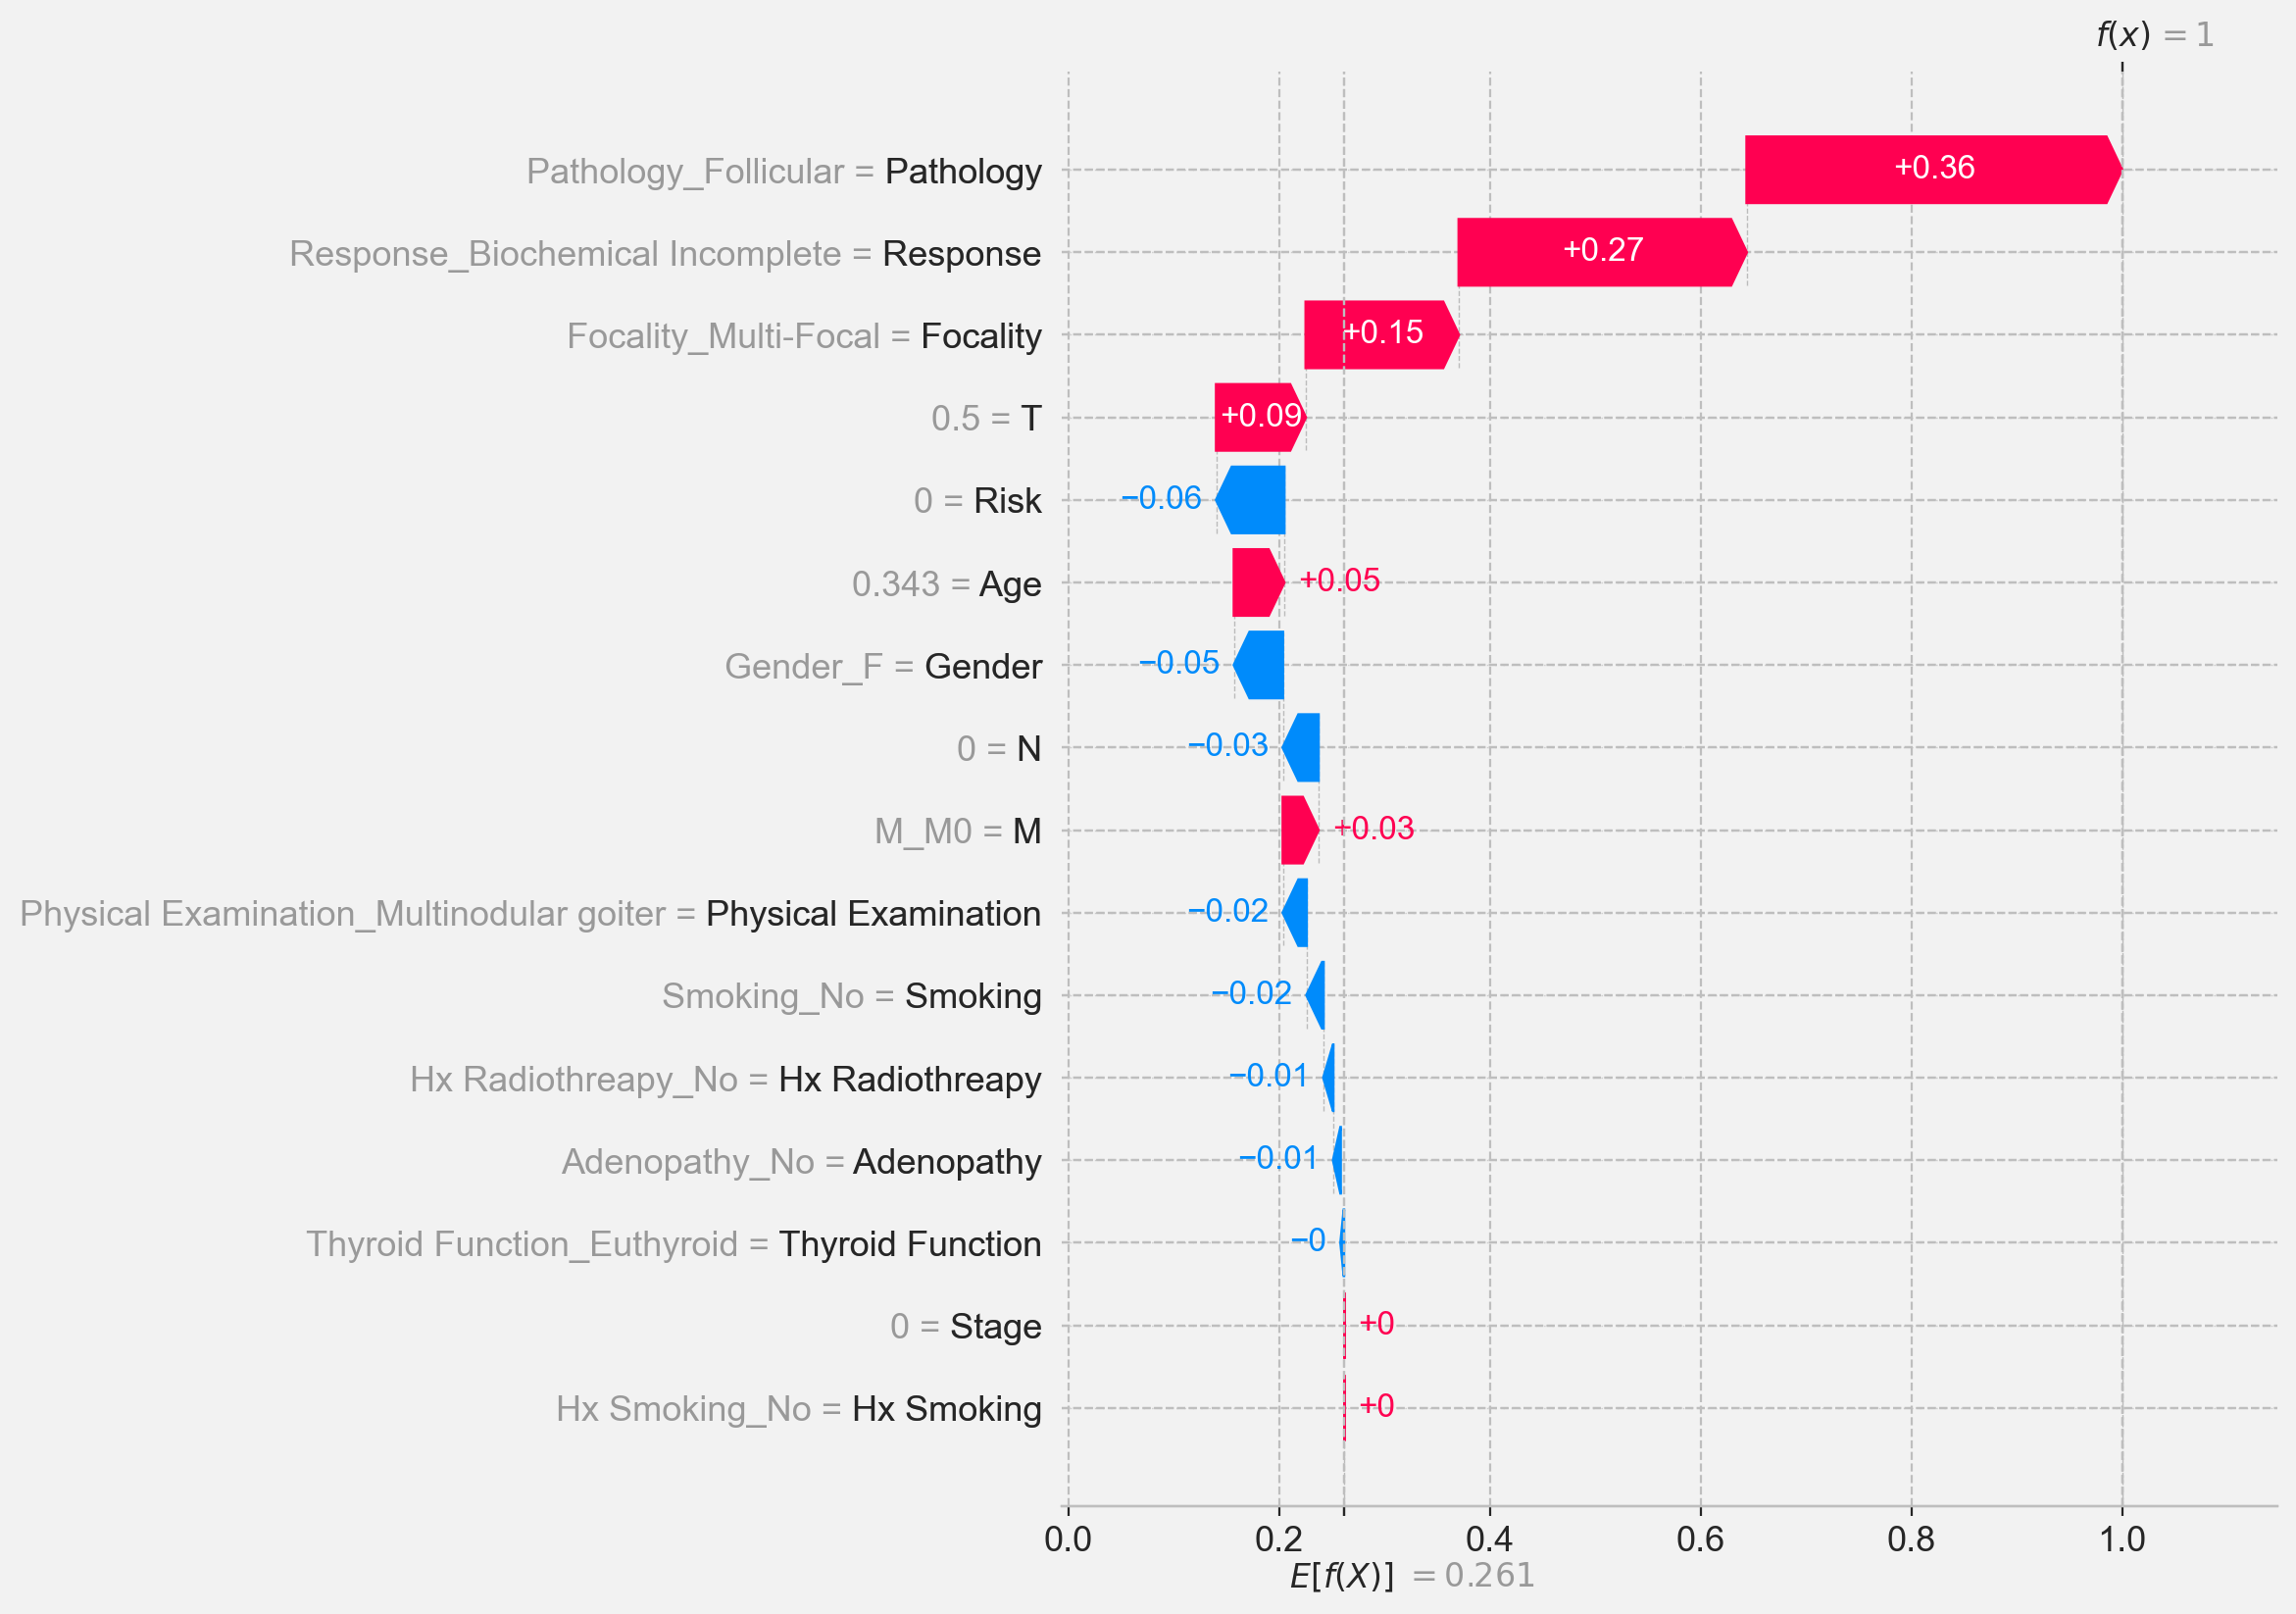

FP


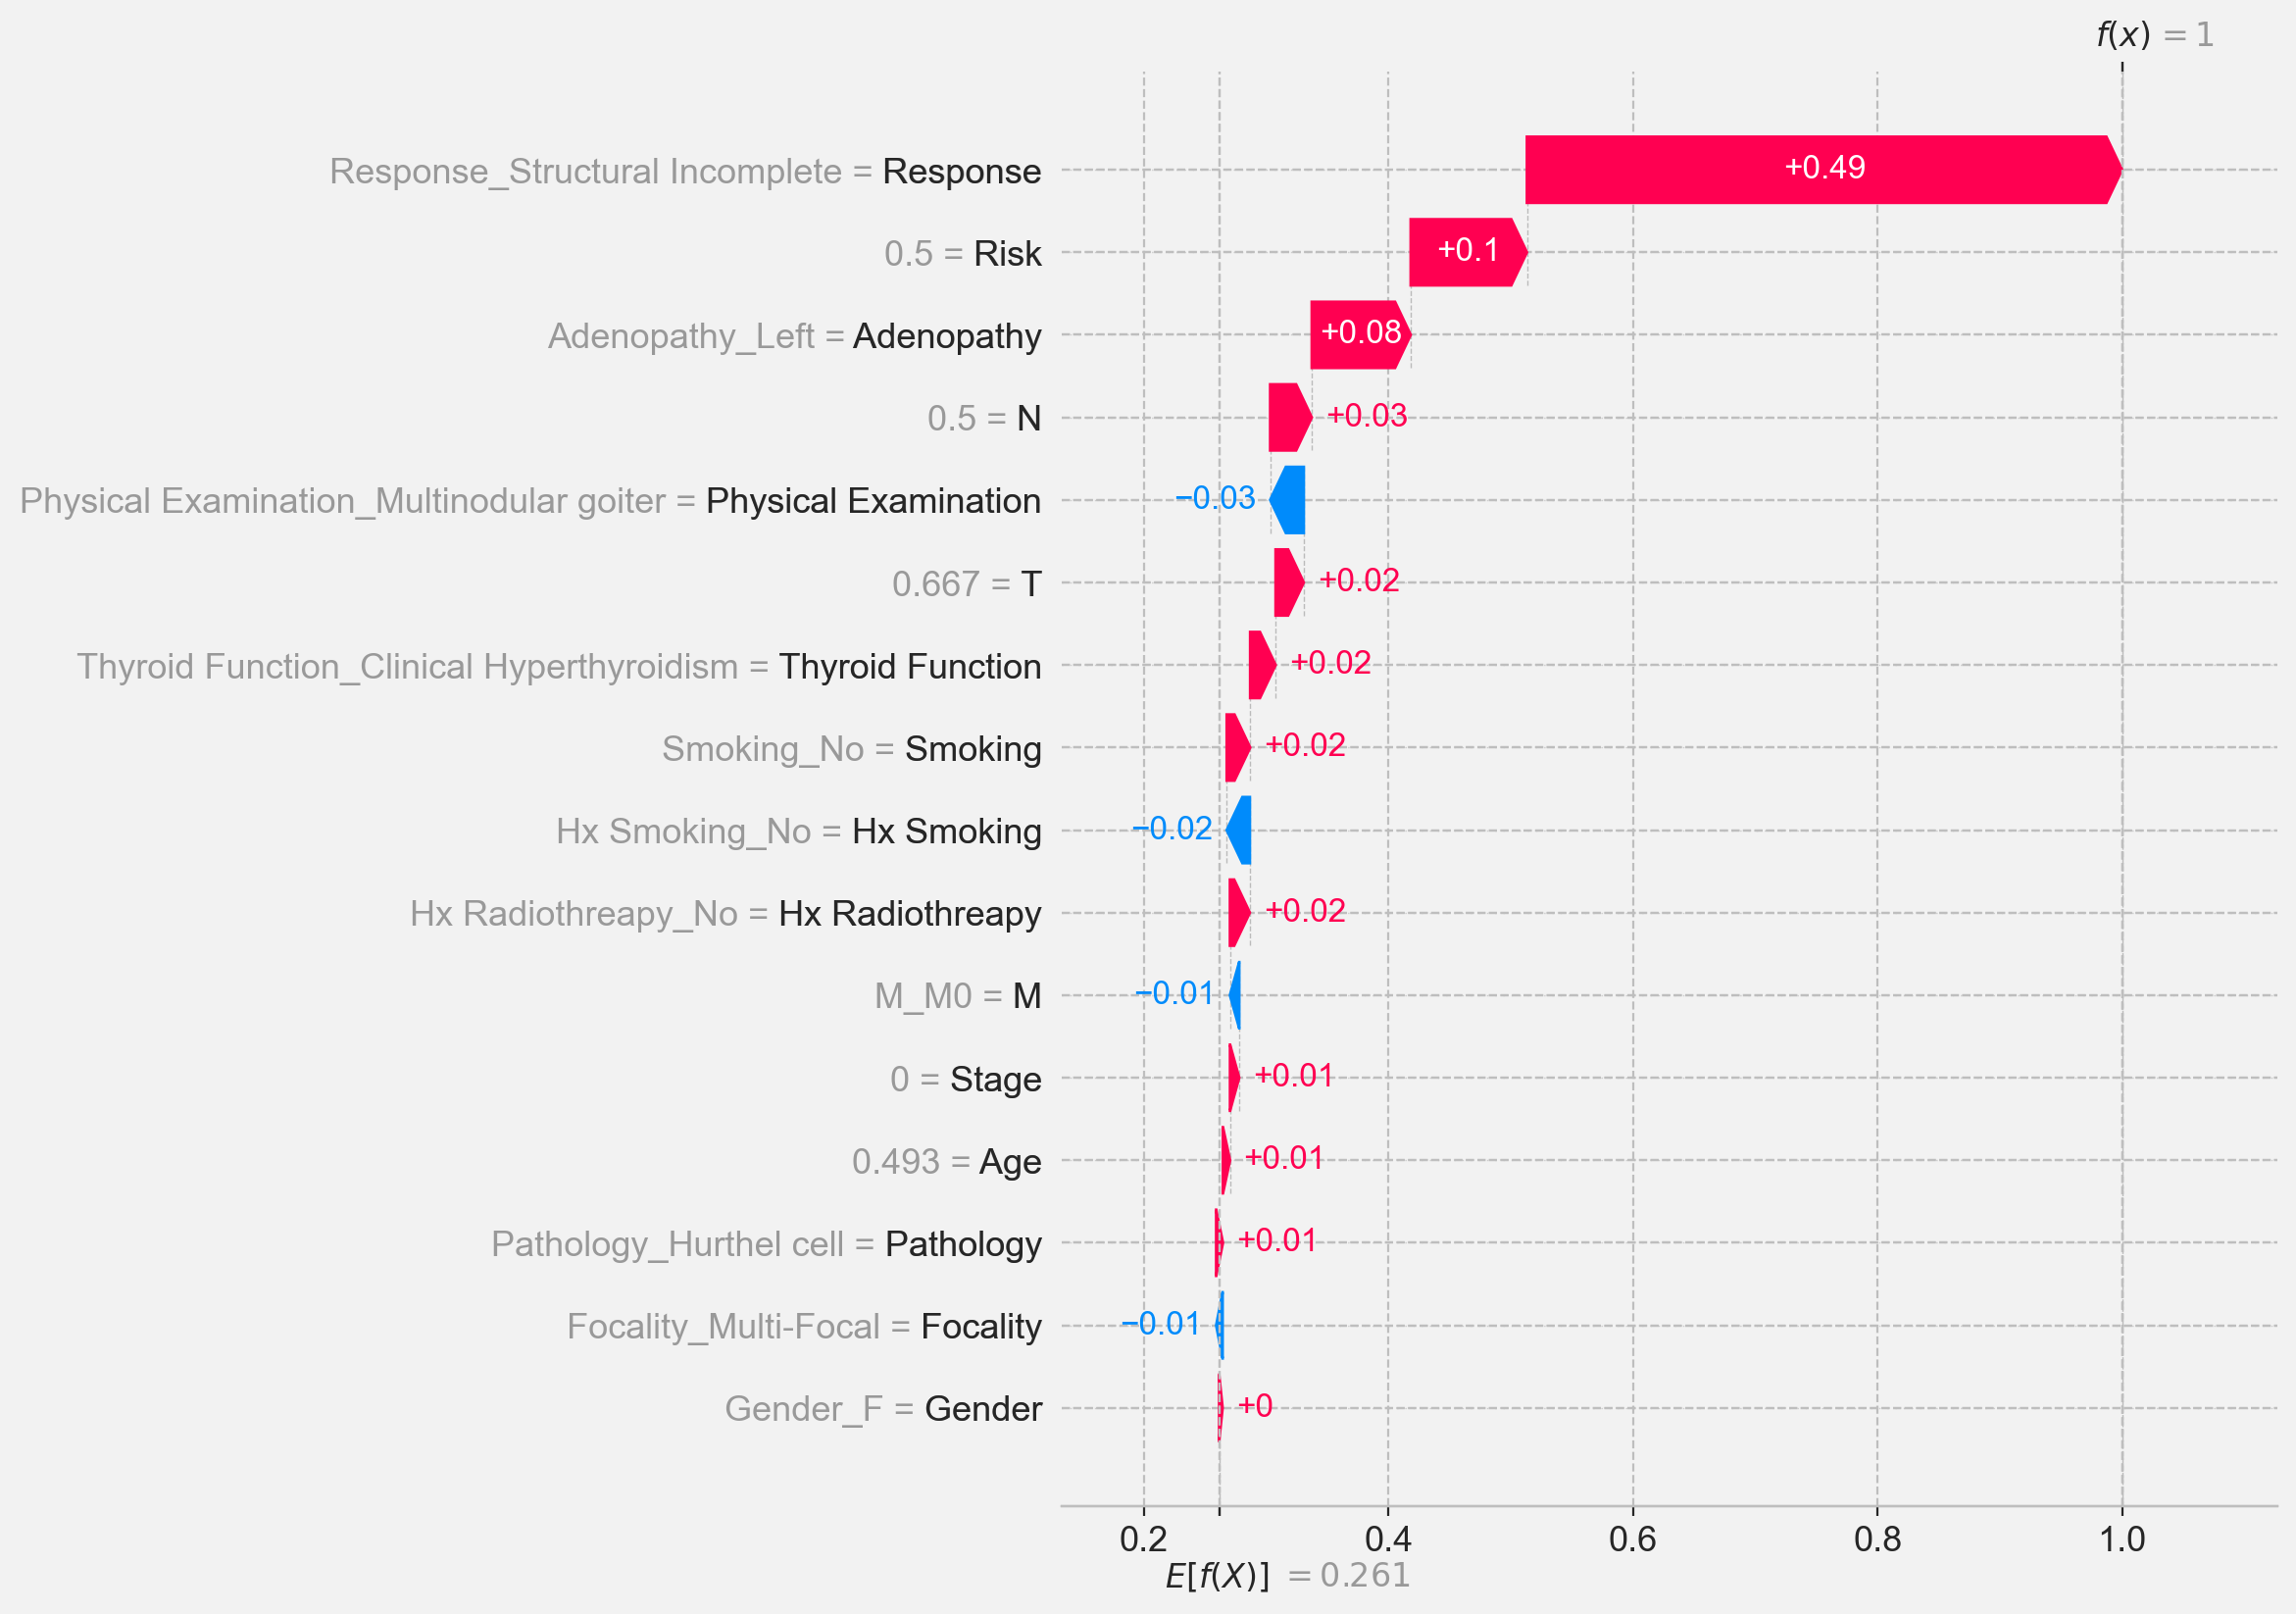

FN


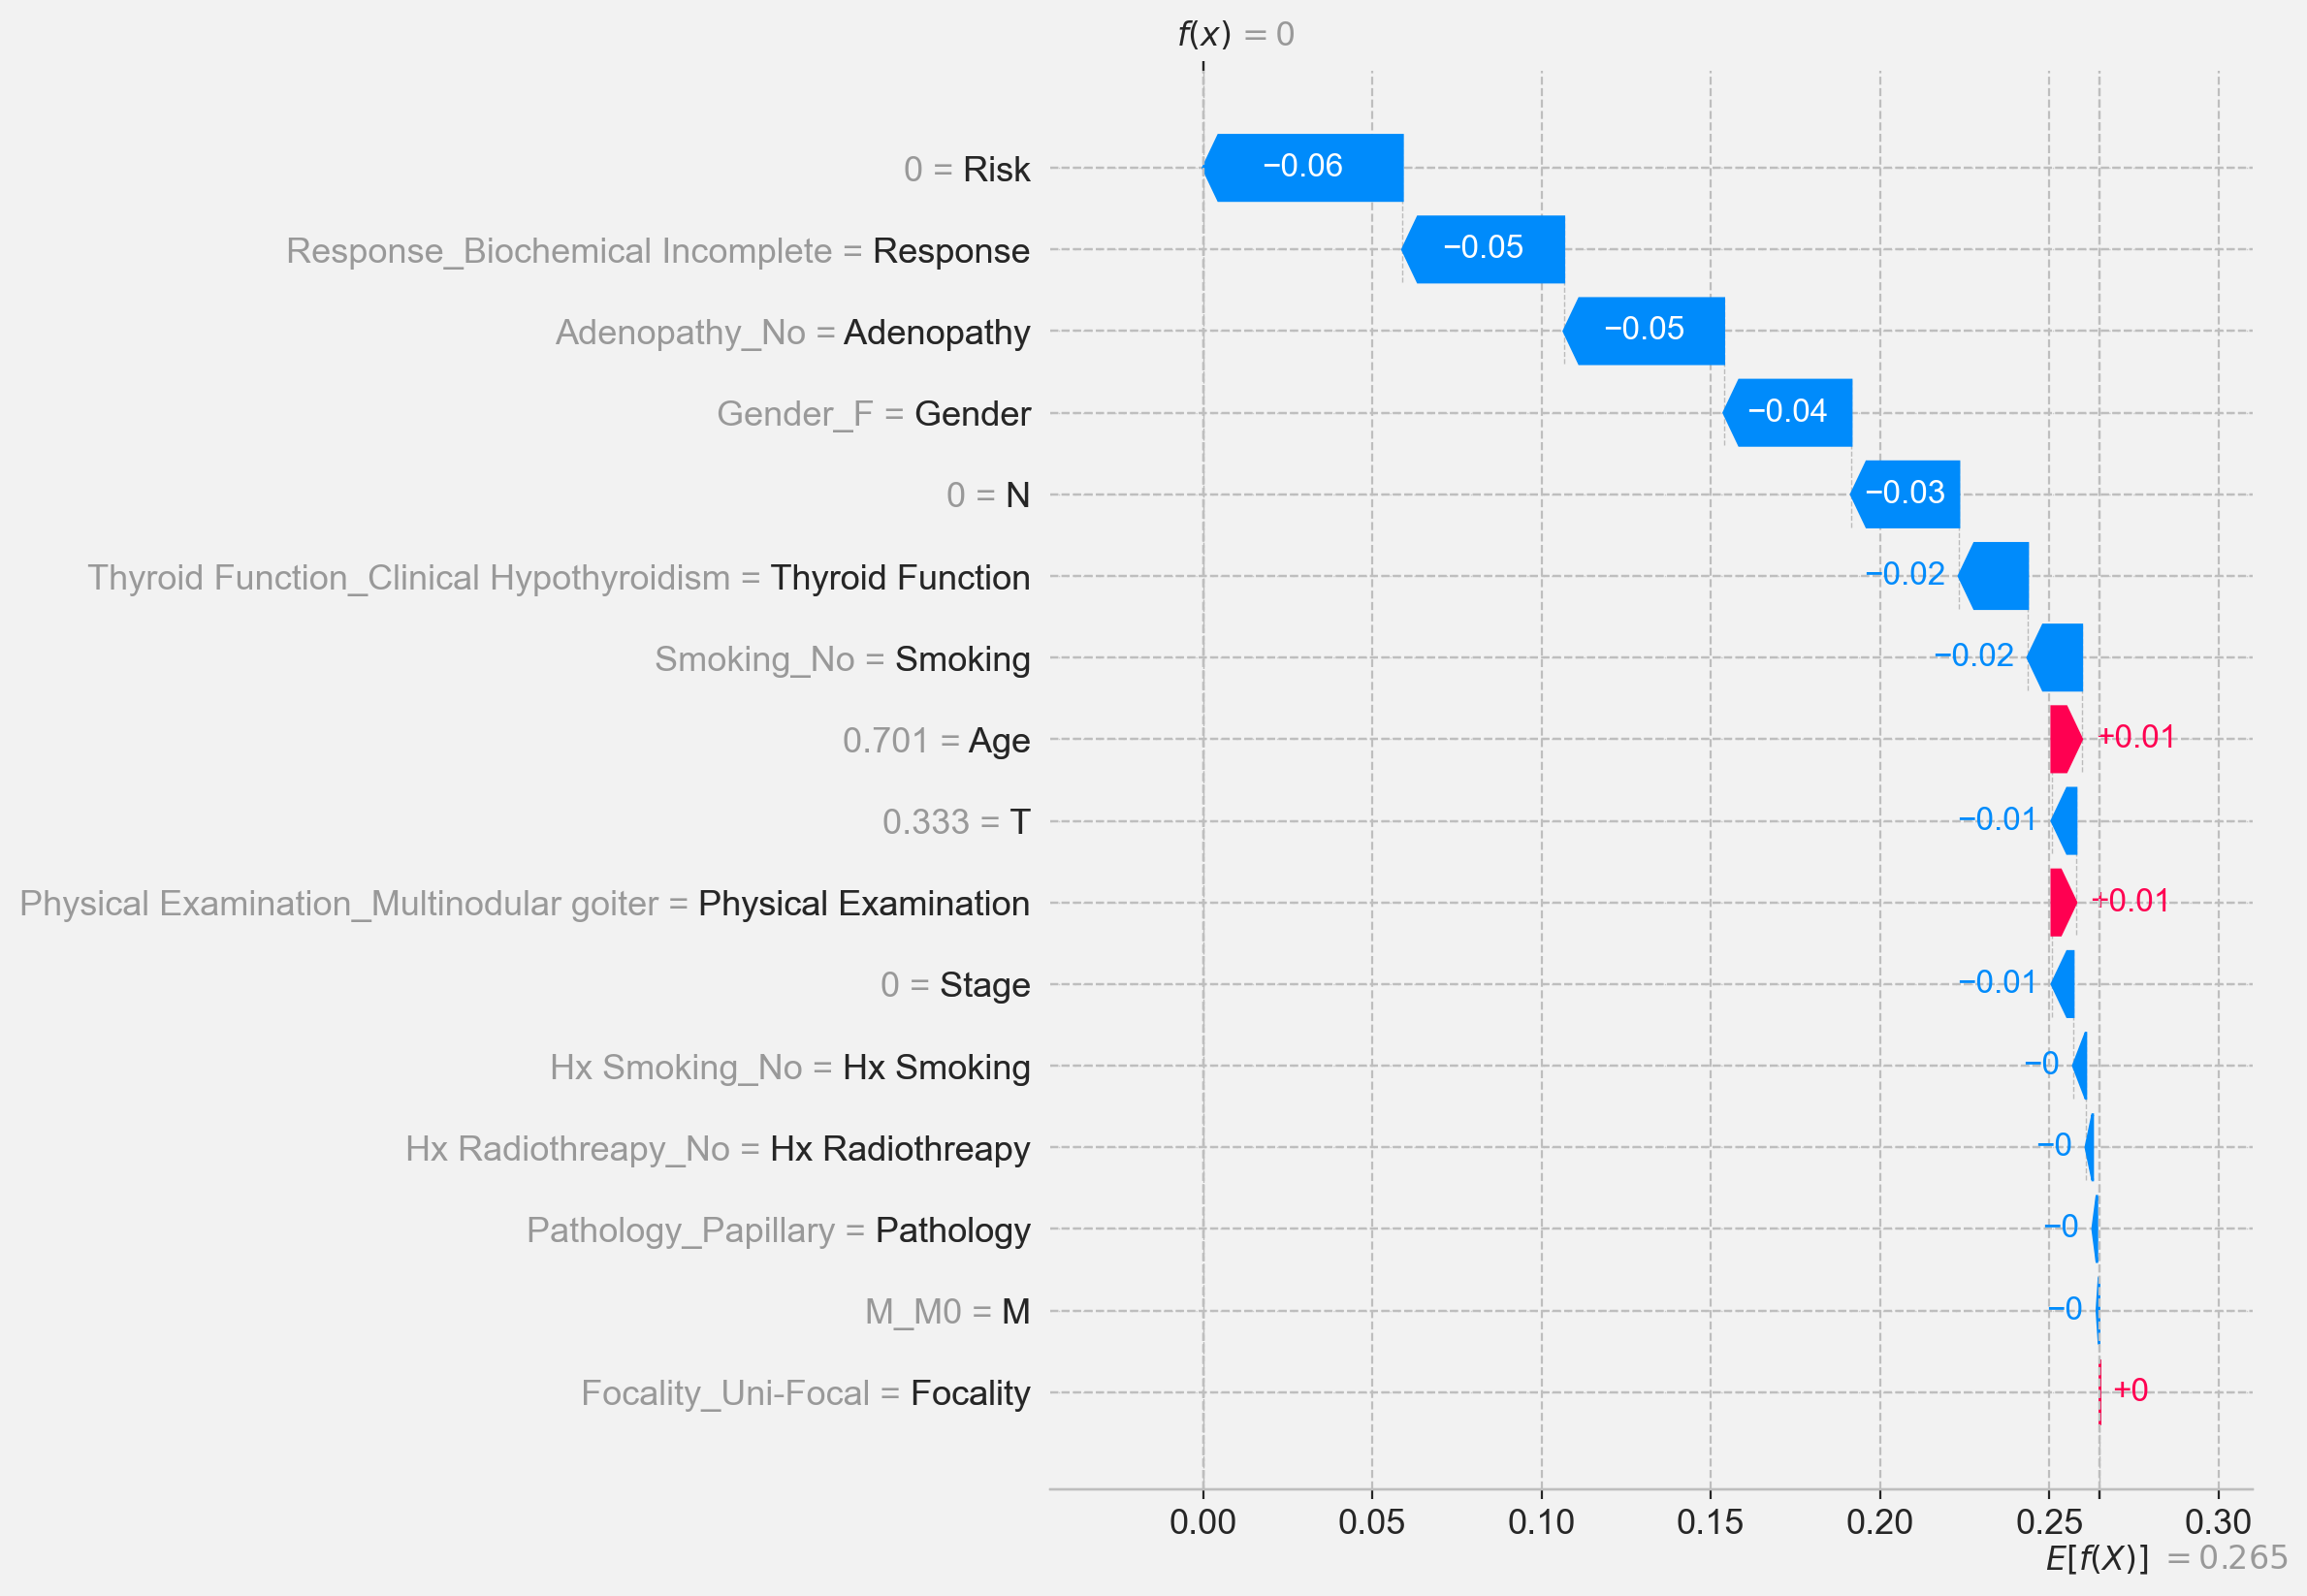

FP


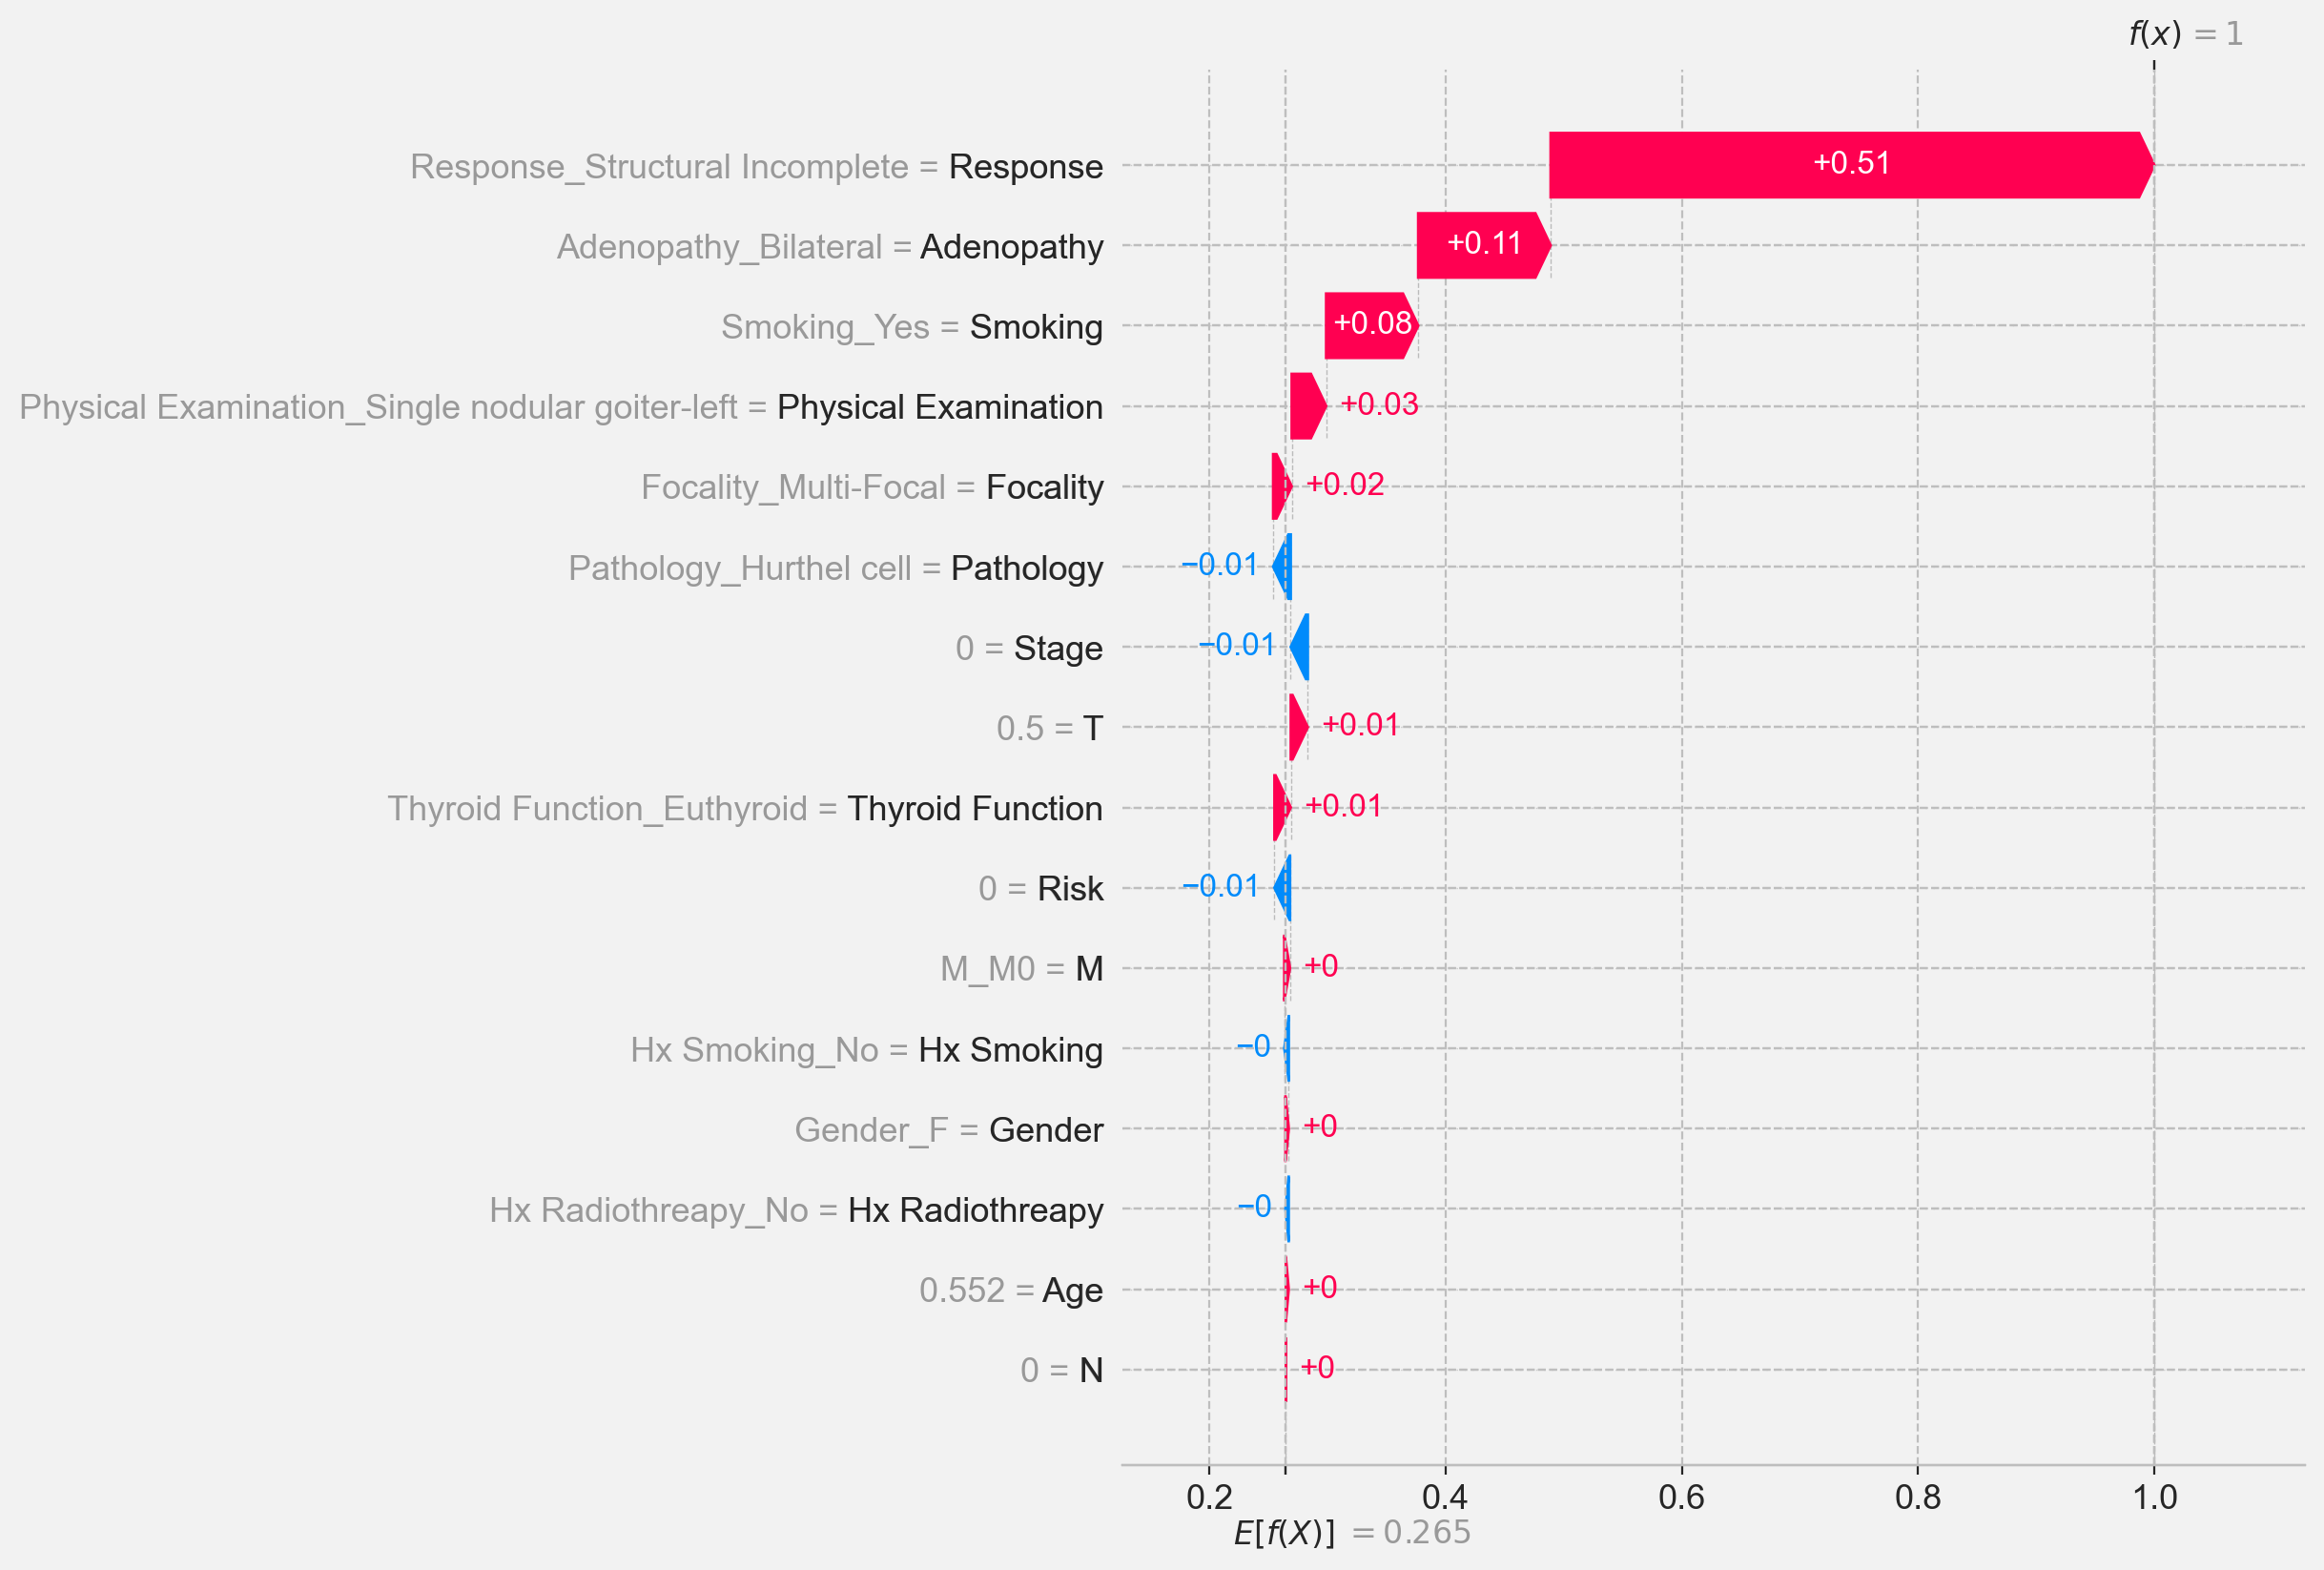

FN


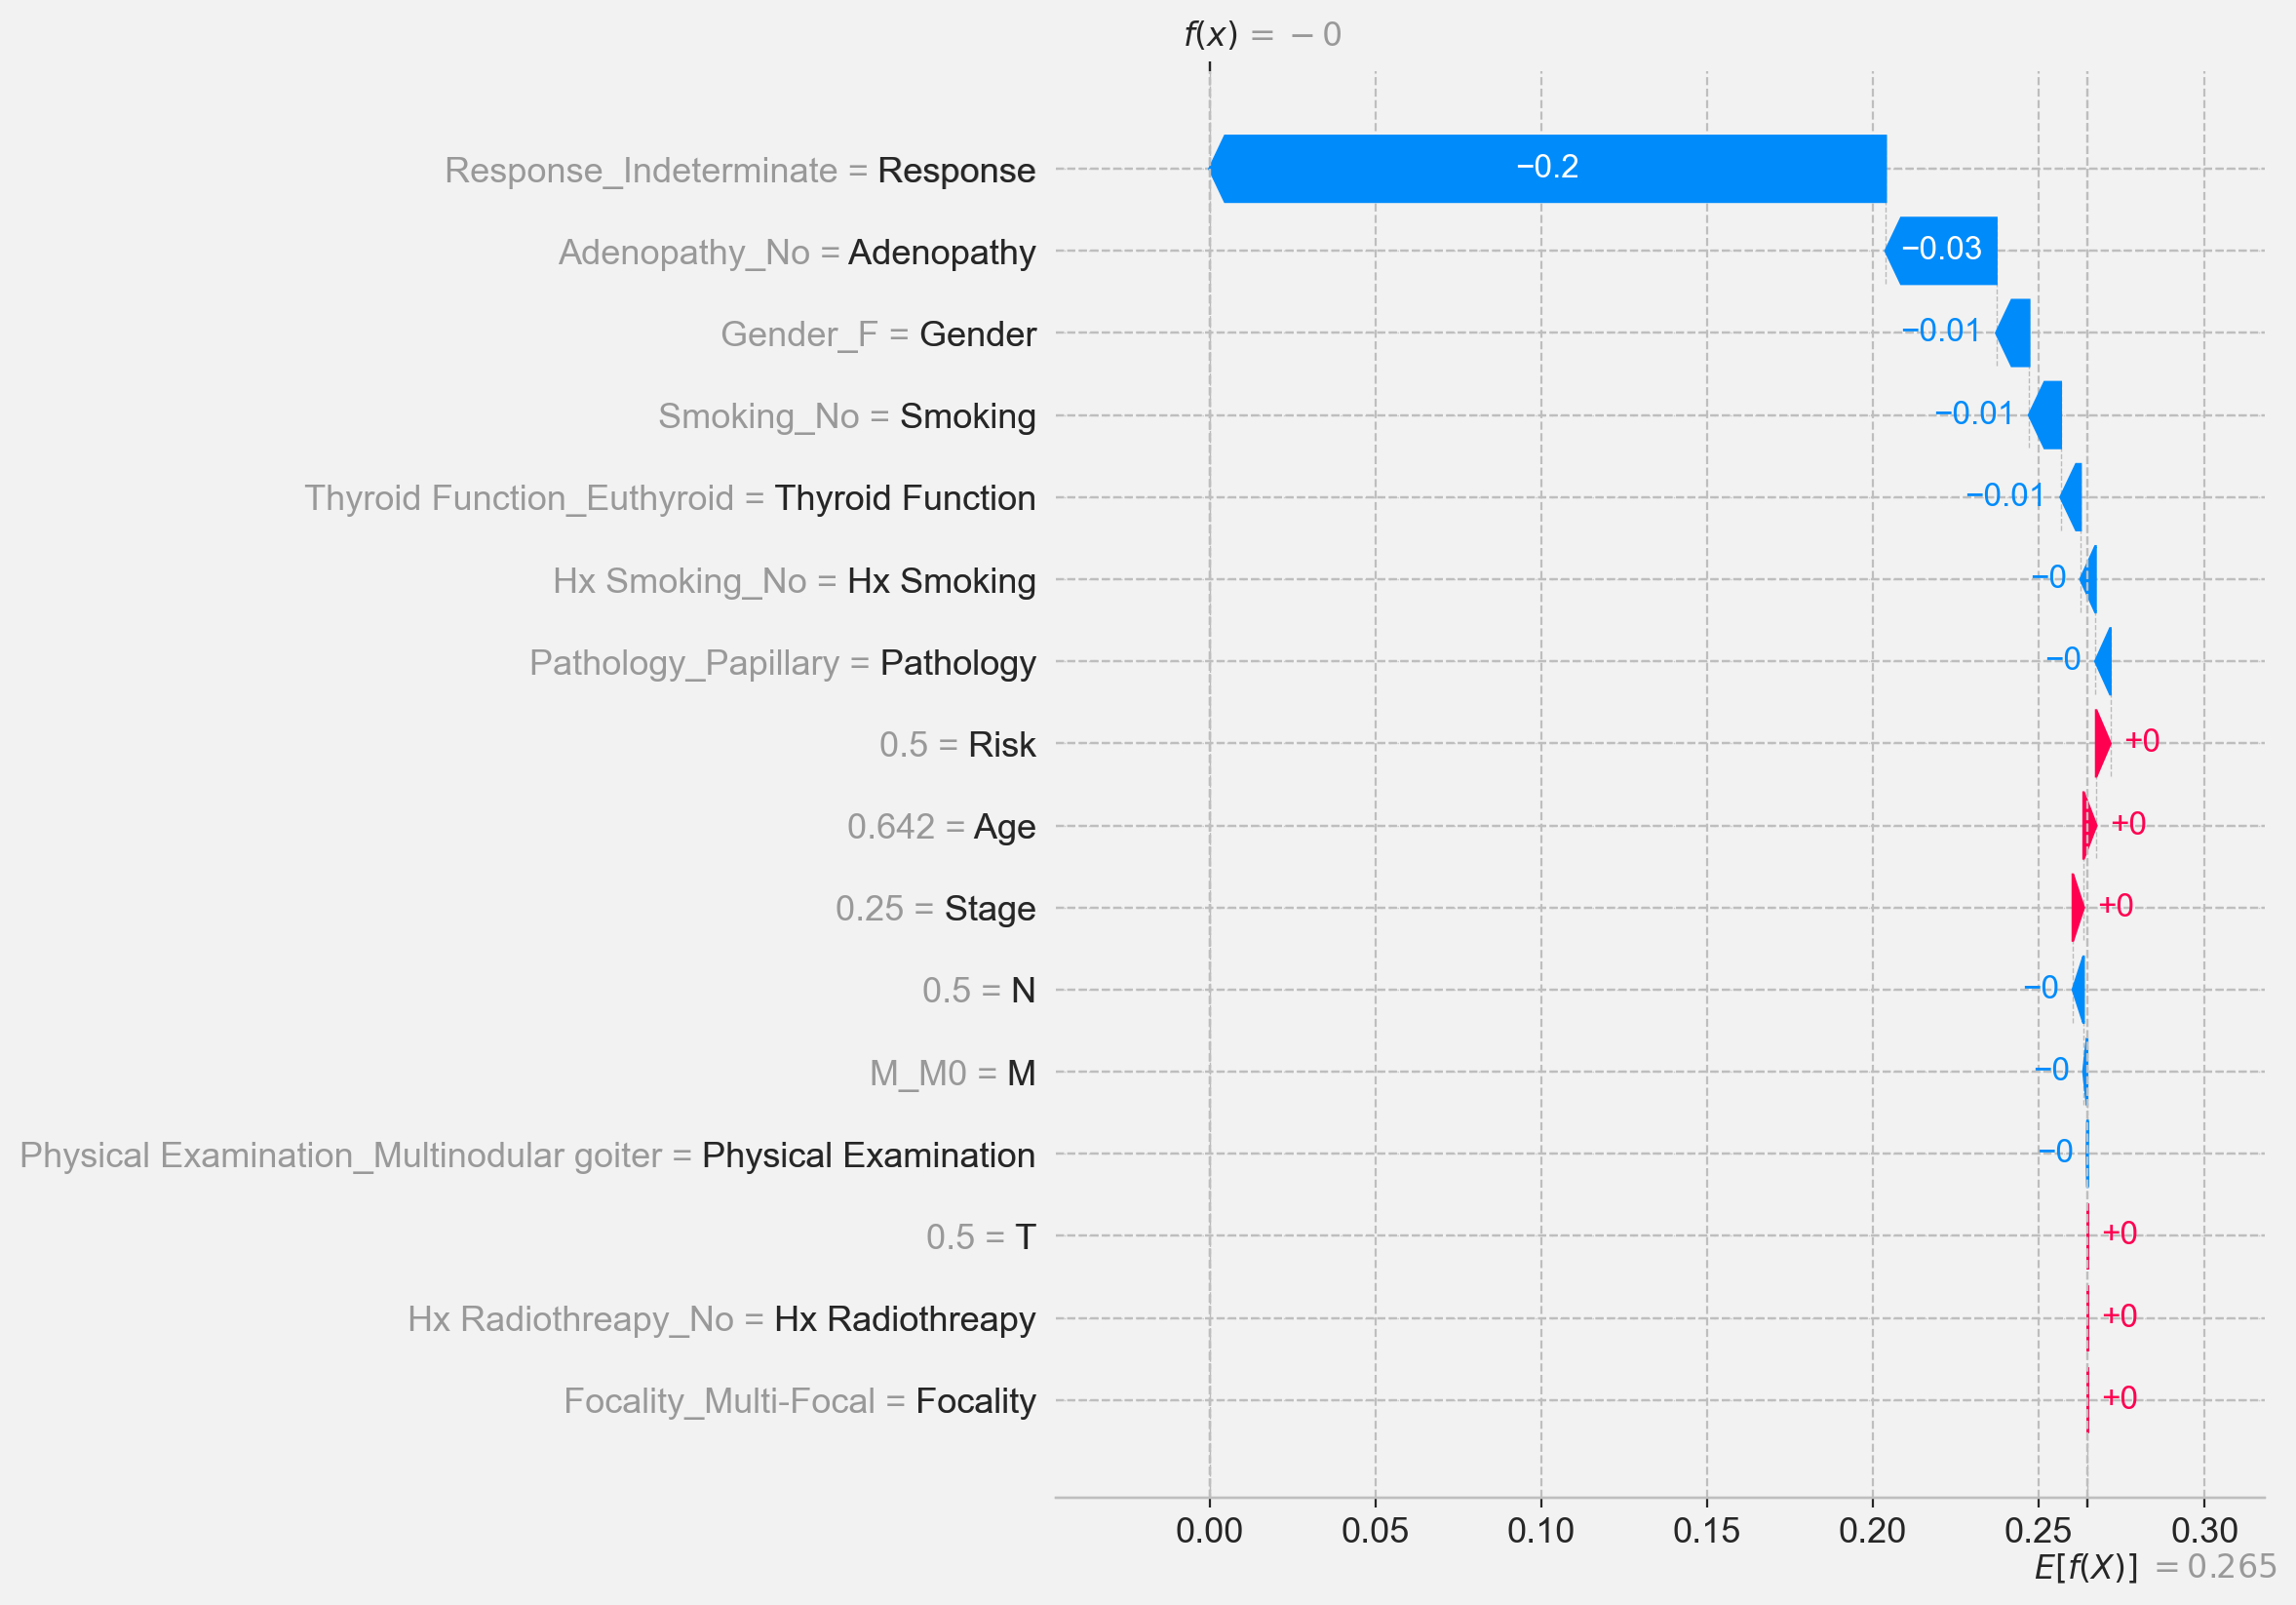

FN


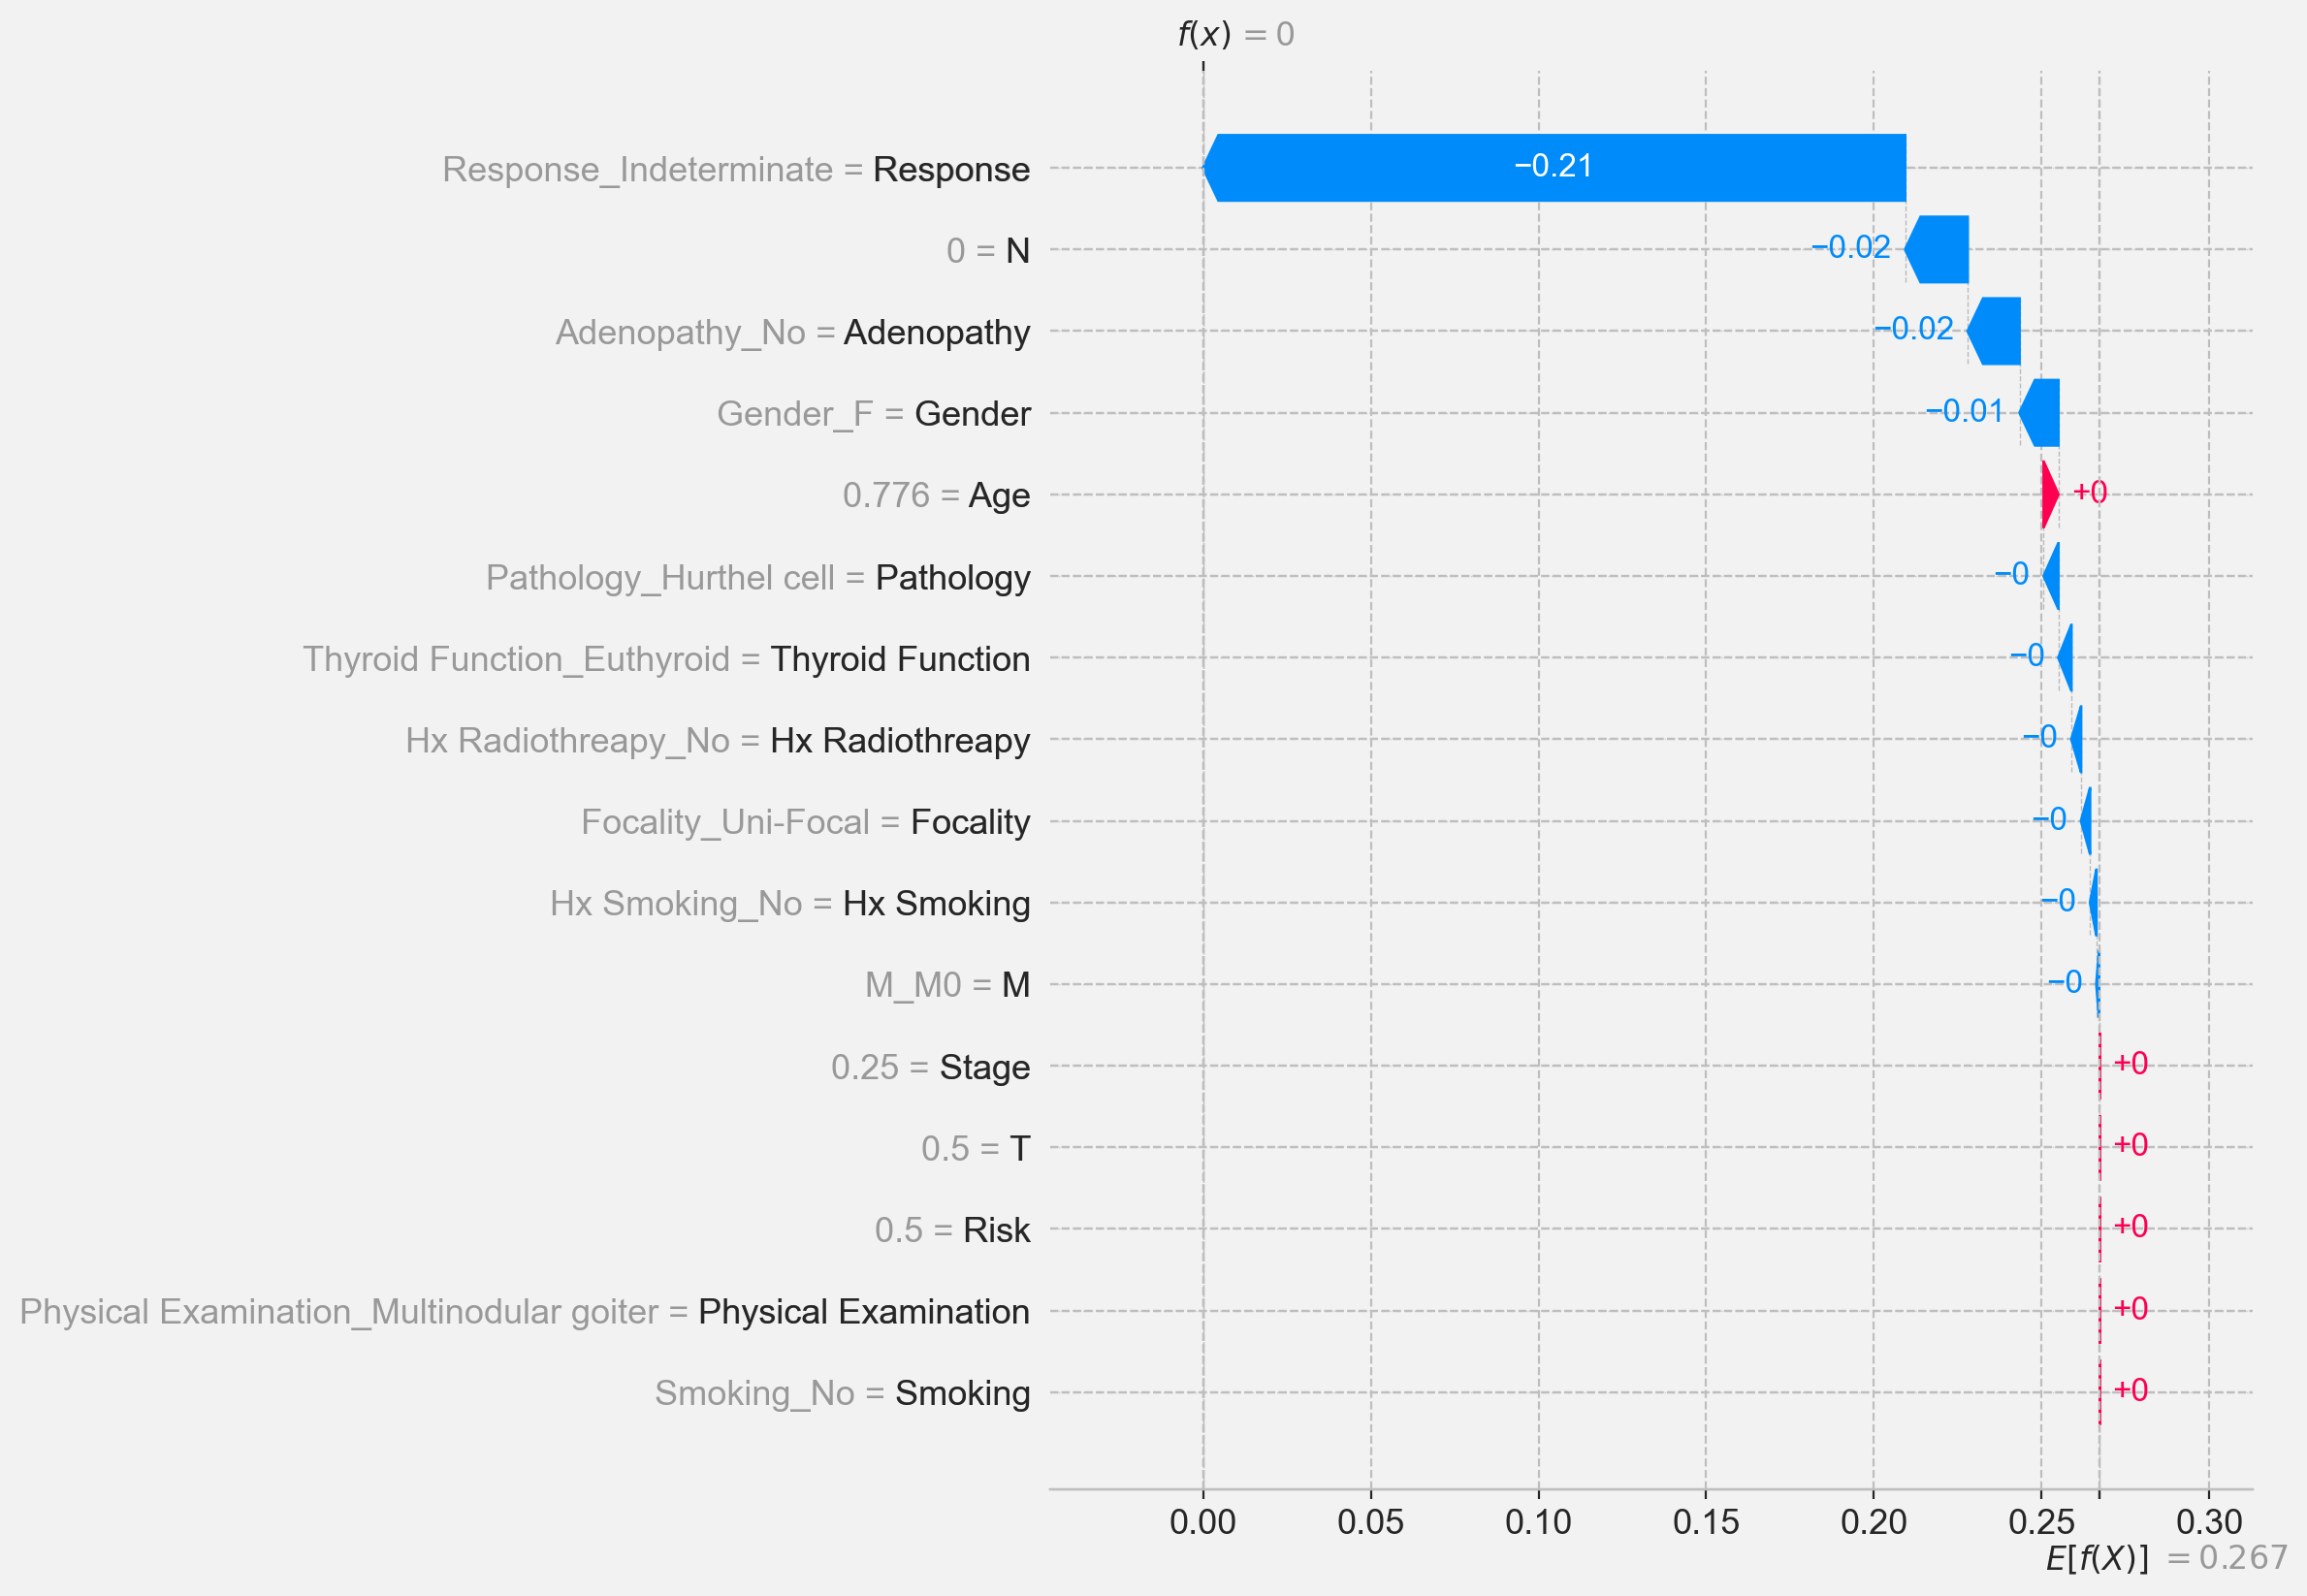

FN


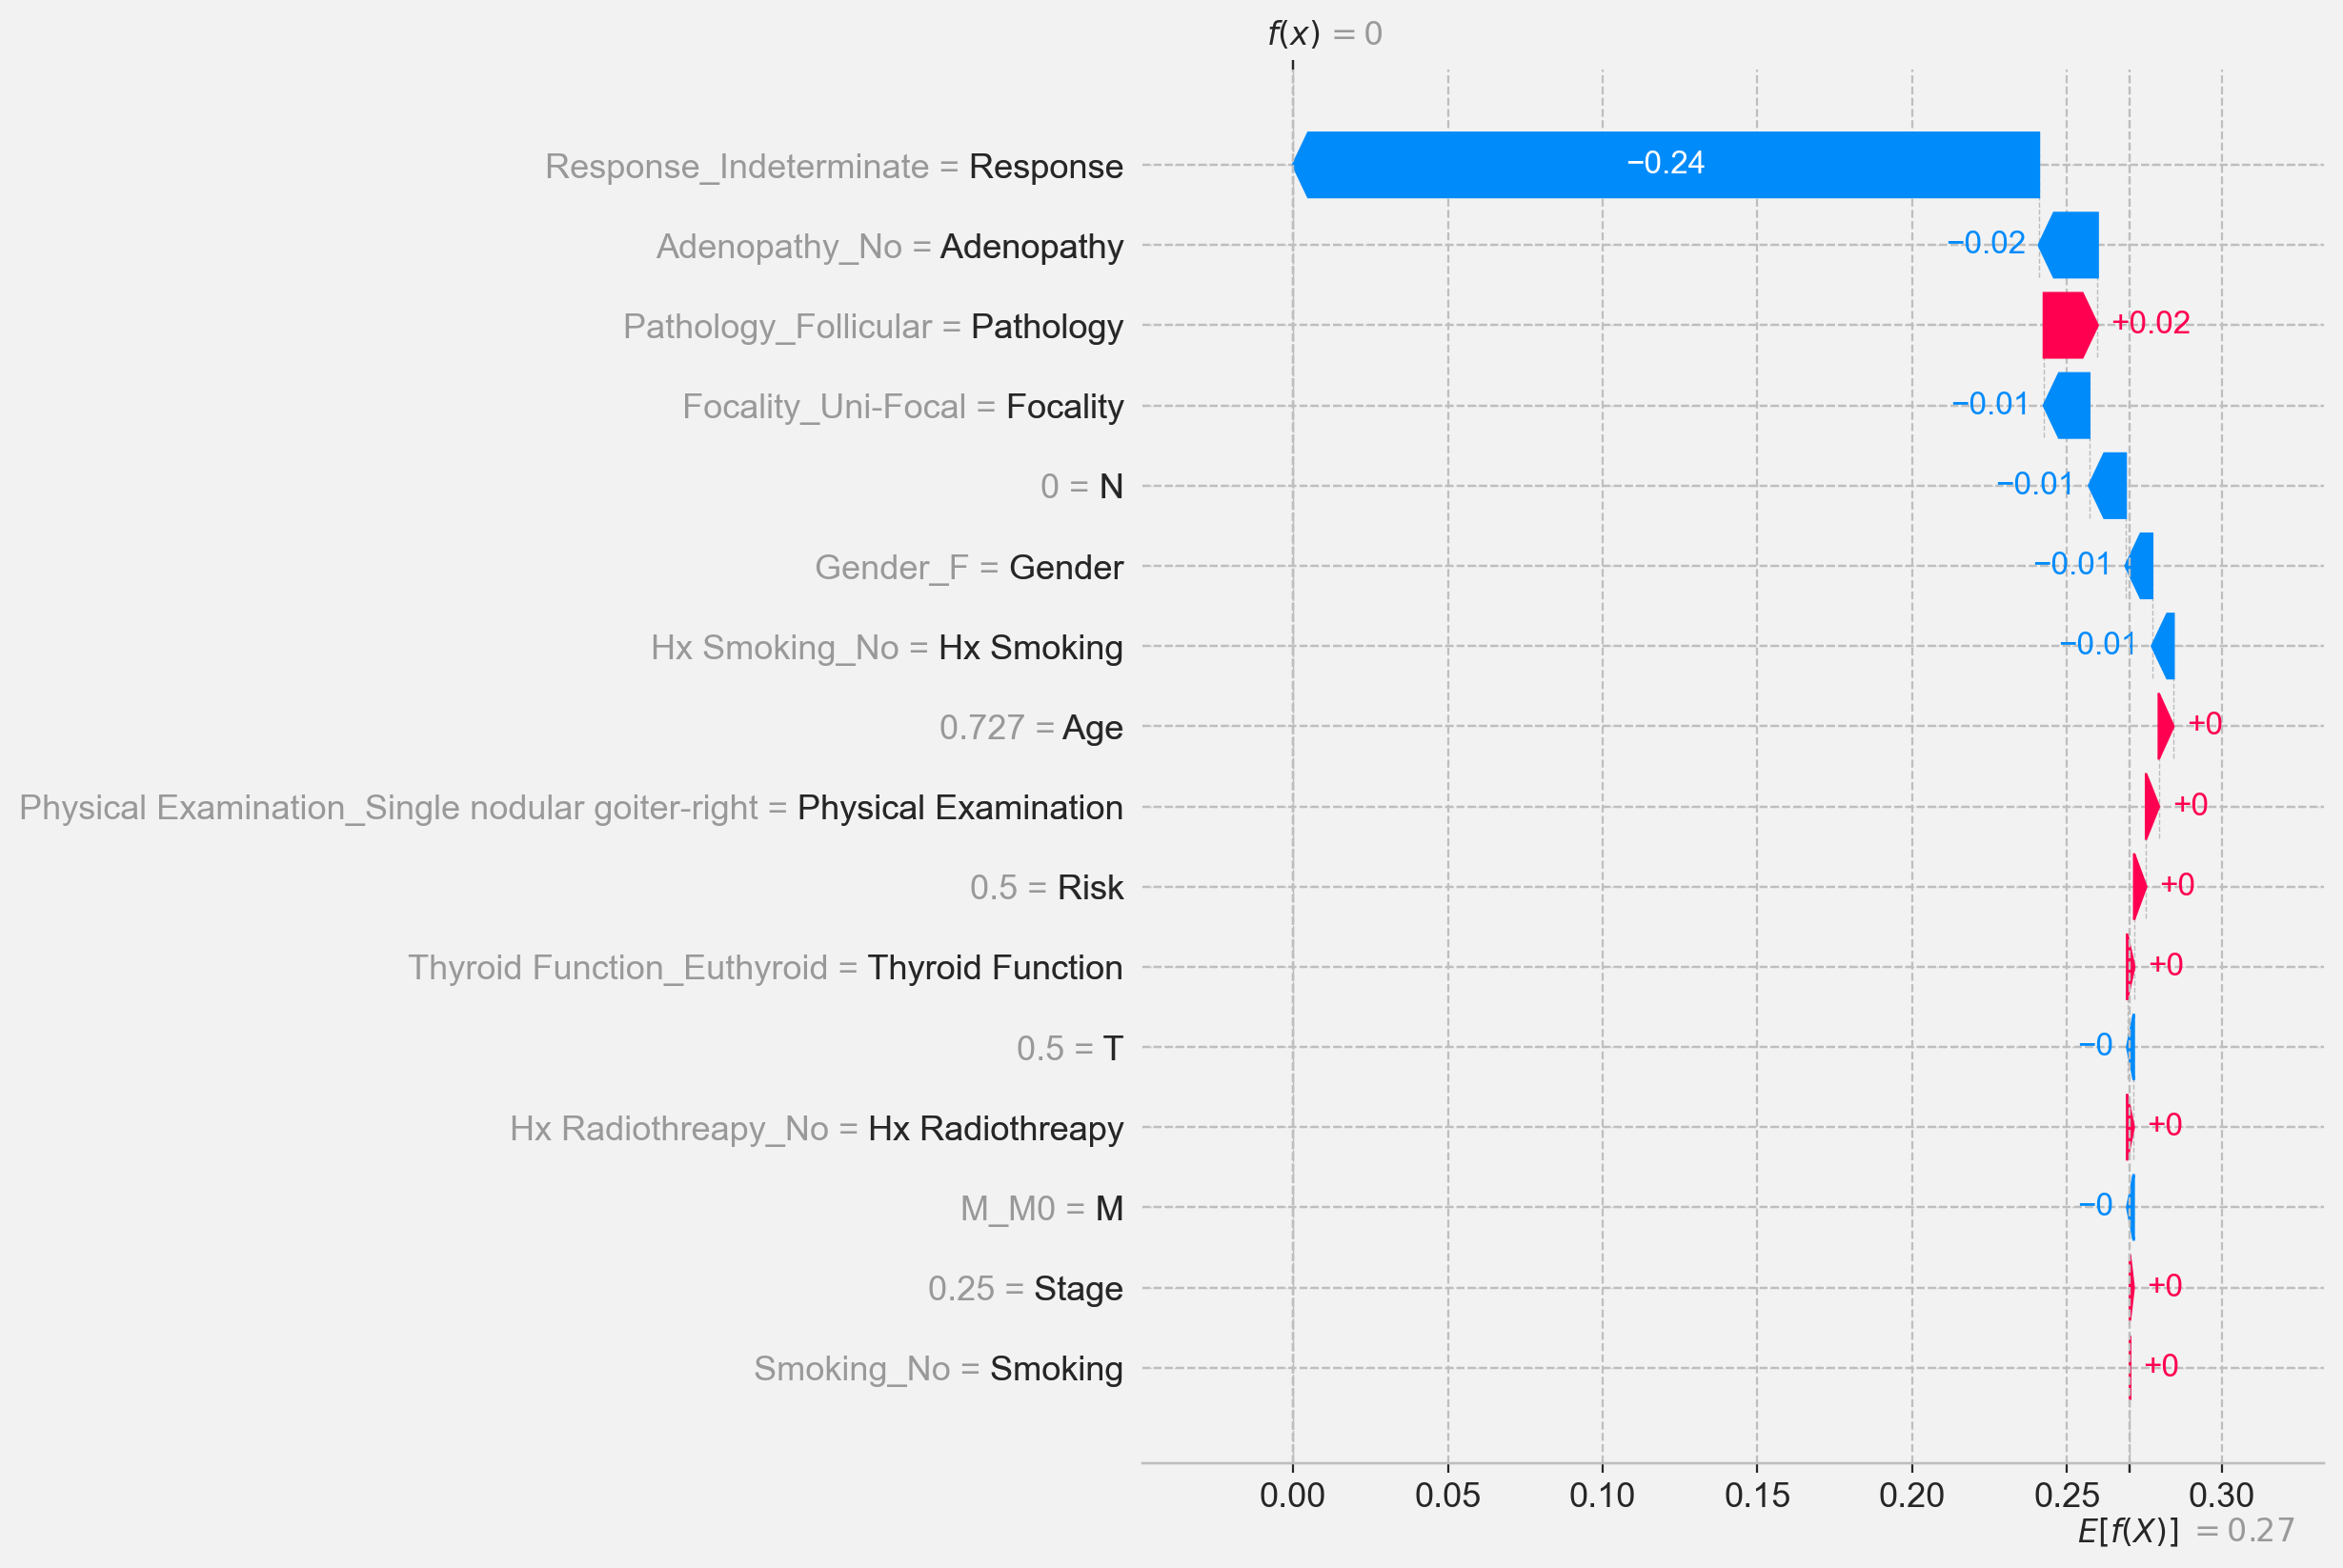

FN


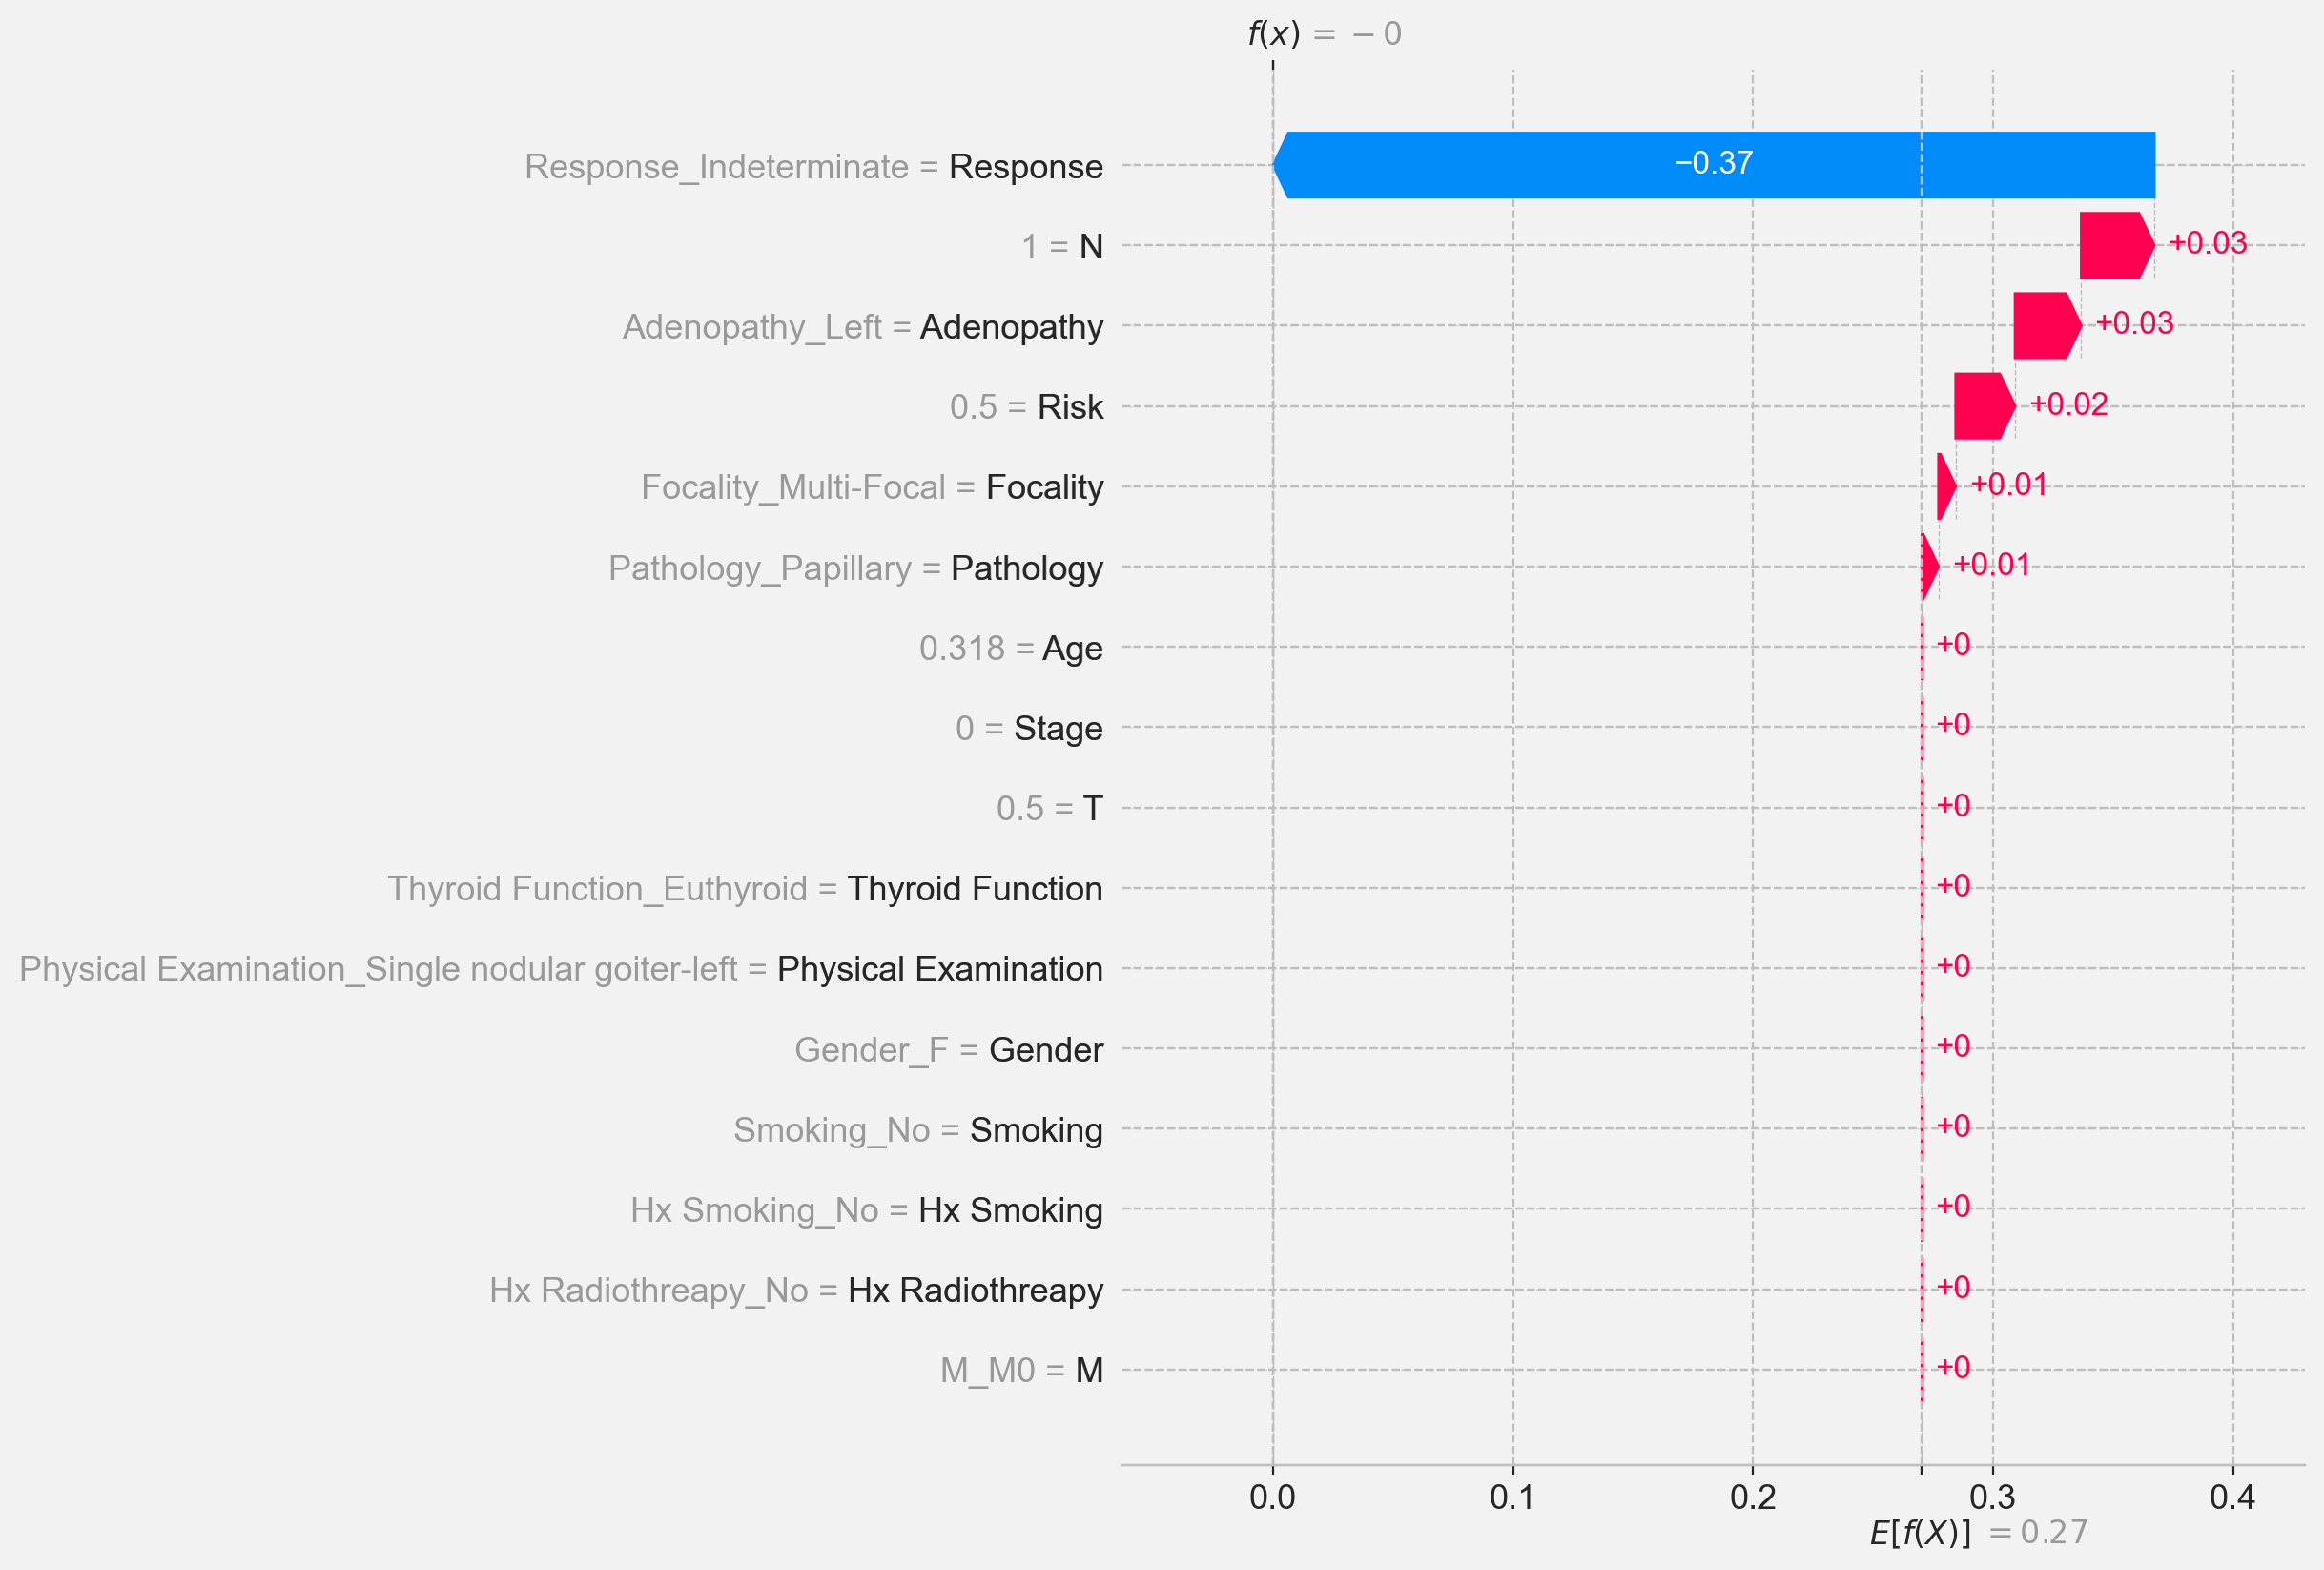

FN


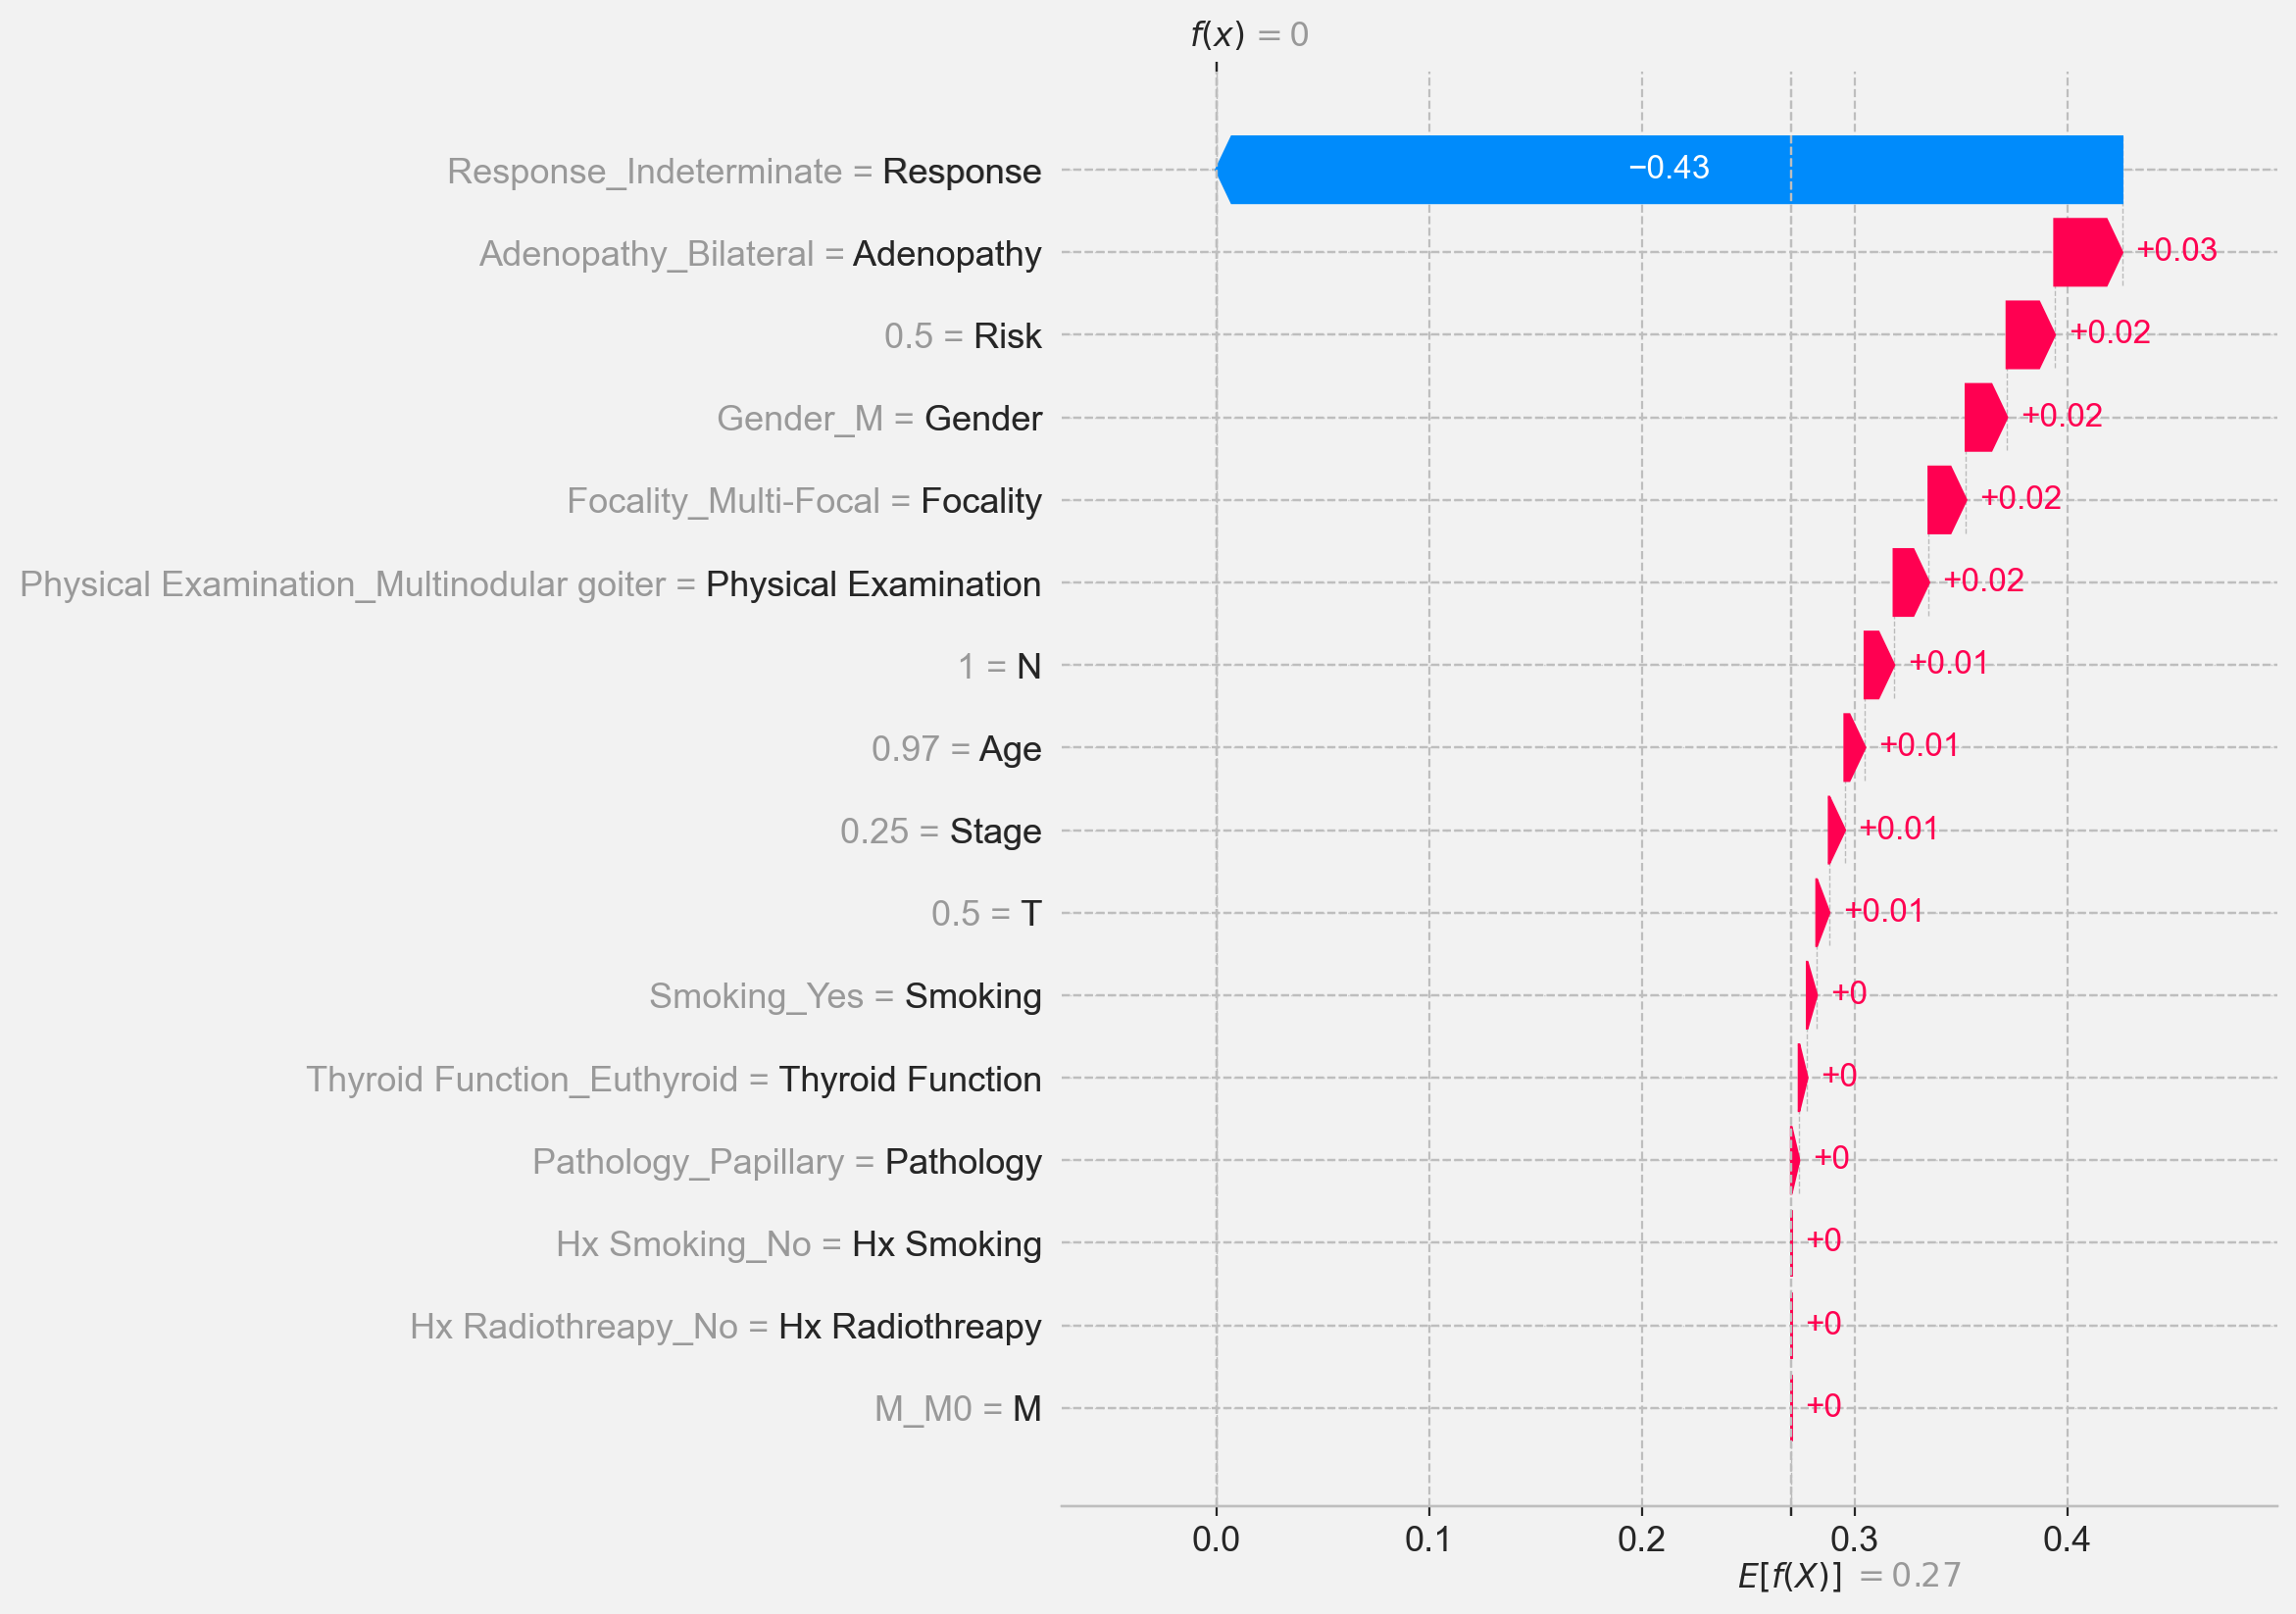

FN


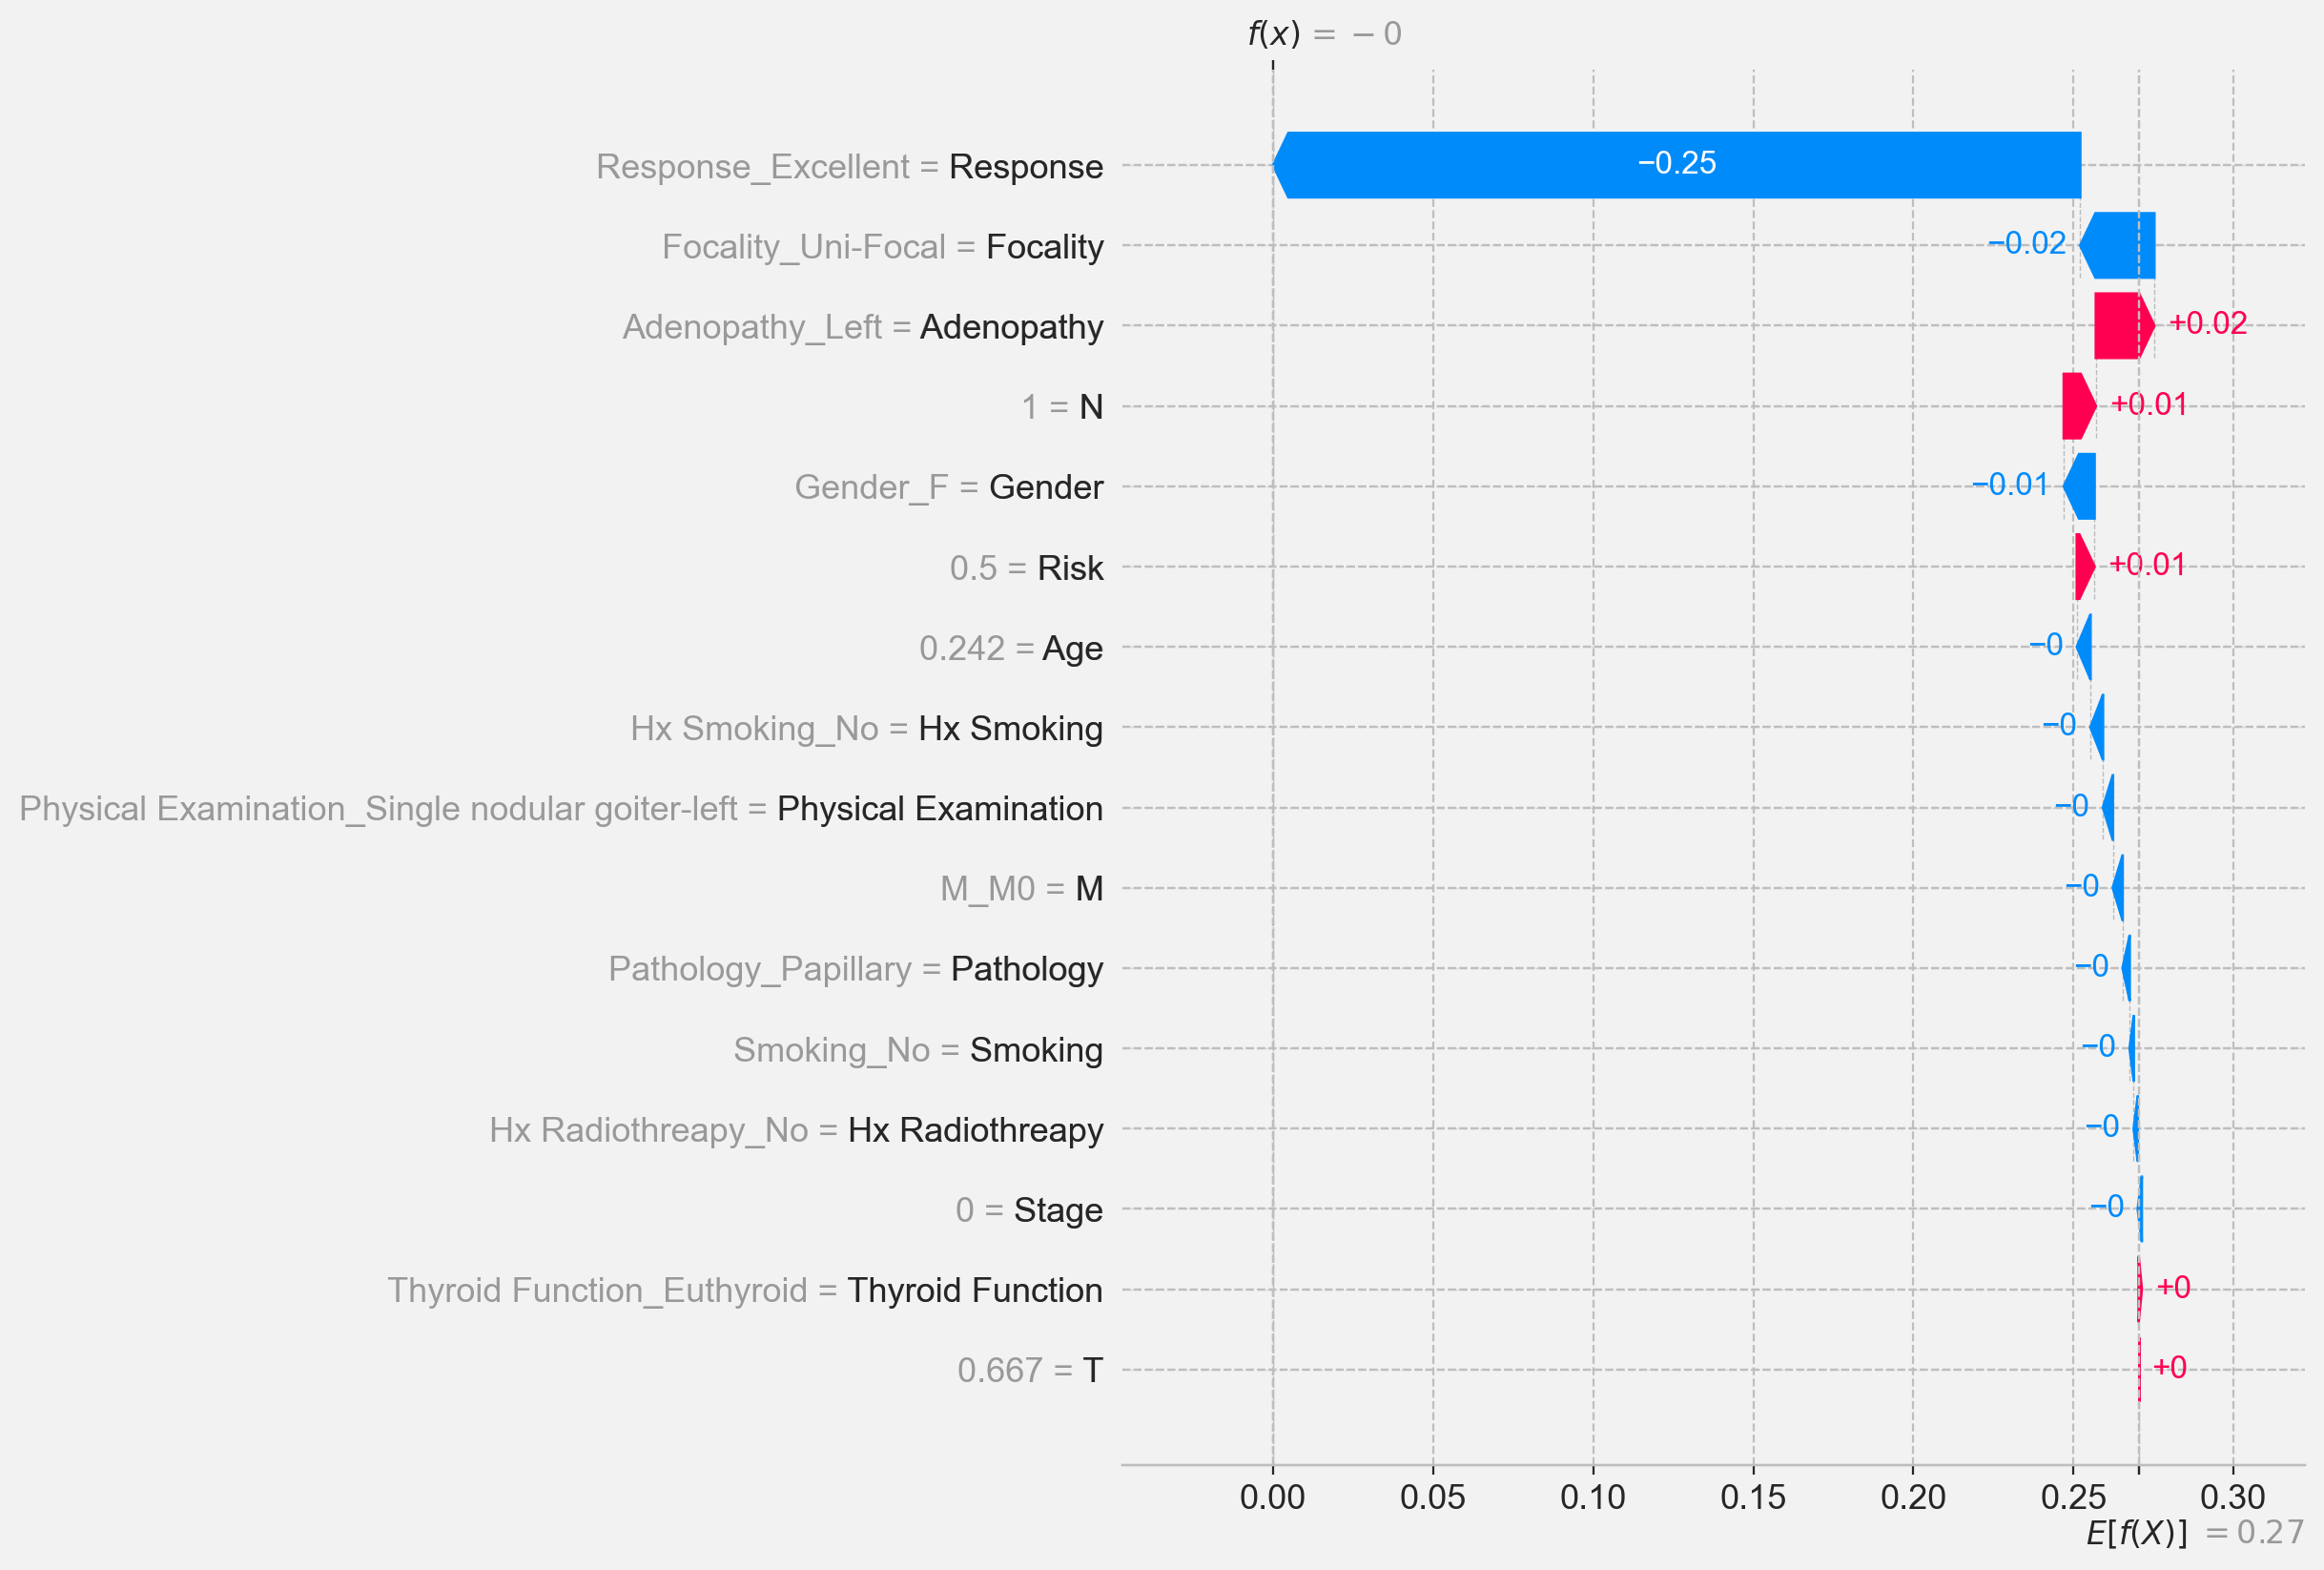

In [83]:
for x in misclassified_ix:
    print(x[1])
    shap.plots.waterfall(combined_shap_values[x[0]], max_display=20)


